## Проверка датасета (SIMPLE)

построение полной сцены 

По сгенерированному jsonl отрисуем по каждой строчке граф вместе с пространственными связями и выведем все параметры
(проверим что умеем строить графы для разных сцен)

Формат сцены:

```
{"scene": 
    {"location": "склад", 
     "objects": [
         {"коробка": []}, 
         {"паллета": ["деревянная"]}, 
         {"тележка": ["металлическая", "квадратная", "тяжелая"]}, 
         {"стеллаж": ["высокий"]}
     ], 
     "relations": [["коробка", "на", "паллета"], 
                   ["тележка", "рядом с", "паллета"], 
                   ["тележка", "у", "стеллаж"]]
     }, 
     "description": "Коробка лежит на деревянной паллете рядом с квадратной тяжелой металлической тележкой, которая стоит у высокого стеллажа."
}
```


In [1]:
import os
import sys
import json
import time
import random
import spacy
import re


from spacy.matcher import Matcher, DependencyMatcher
from dotenv import load_dotenv
from tqdm import tqdm

from collections import Counter, defaultdict
from openai import OpenAI

import networkx as nx
import matplotlib.pyplot as plt

lib_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(lib_path)


from library.graph_vizualization import draw_scene_graph_sp, scene_to_graph_sp

BATCH_NUM = "001" # или 1

### Проверим что отрисовка графа работает без spacial (старый формат сцен)

```
{
    "scene": 
        {"location": "монастырь", 
         "objects": [
             {"икона": ["деревянная"]}, 
             {"свеча": ["горящая"]}]
        }, 
     "description": "Деревянная икона висит перед горящей свечой."
}
```

In [13]:
line = """{"scene": {"location": "монастырь", "objects": [{"икона": ["деревянная"]}, {"свеча": ["горящая"]}]}, "description": "Деревянная икона висит перед горящей свечой."}"""
data = json.loads(line)

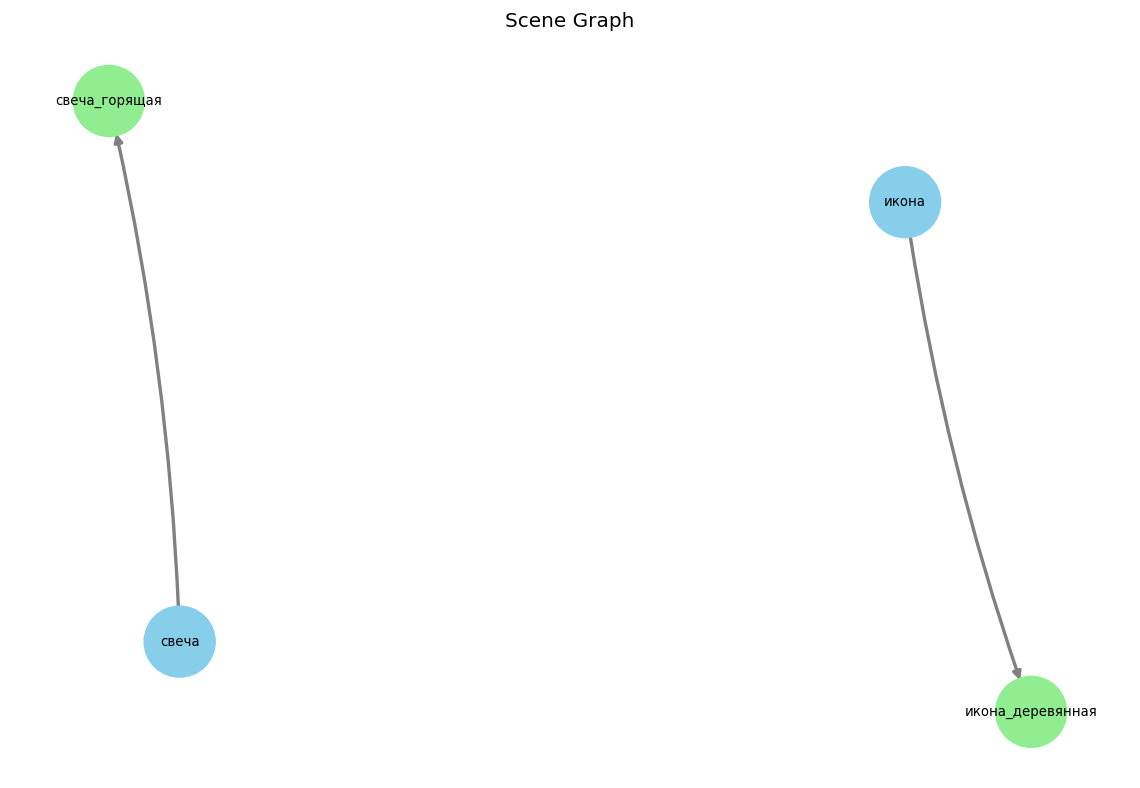

In [14]:
G = scene_to_graph_sp(data.get("scene", {}))
draw_scene_graph_sp(G) 

### Проверка на всем датасете

{"scene": {"location": "монастырь", "objects": [{"икона": ["деревянная"]}, {"свеча": ["горящая"]}], "relations": [["икона", "перед", "свеча"]]}, "description": "Деревянная икона висит перед горящей свечой."}



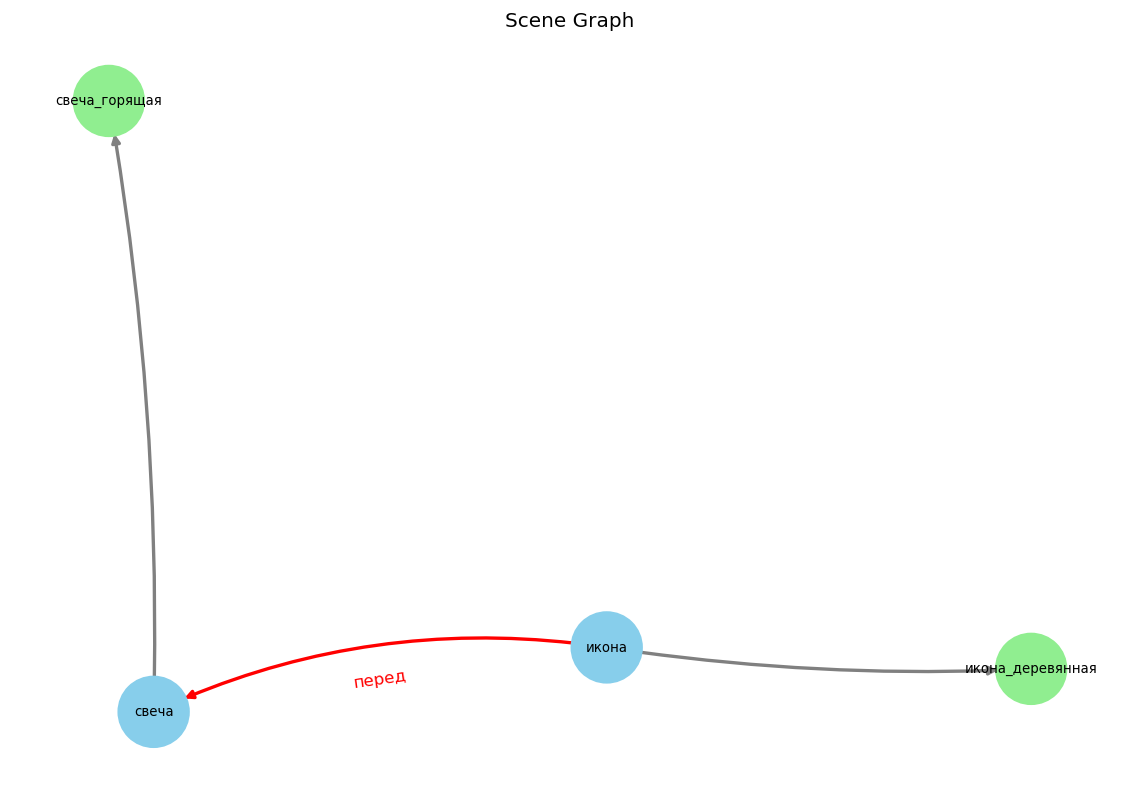


{"scene": {"location": "монастырь", "objects": [{"икона": ["деревянная"]}, {"свеча": ["горящая"]}], "relations": [["свеча", "перед", "икона"]]}, "description": "Горящая свеча стоит перед деревянной иконой."}



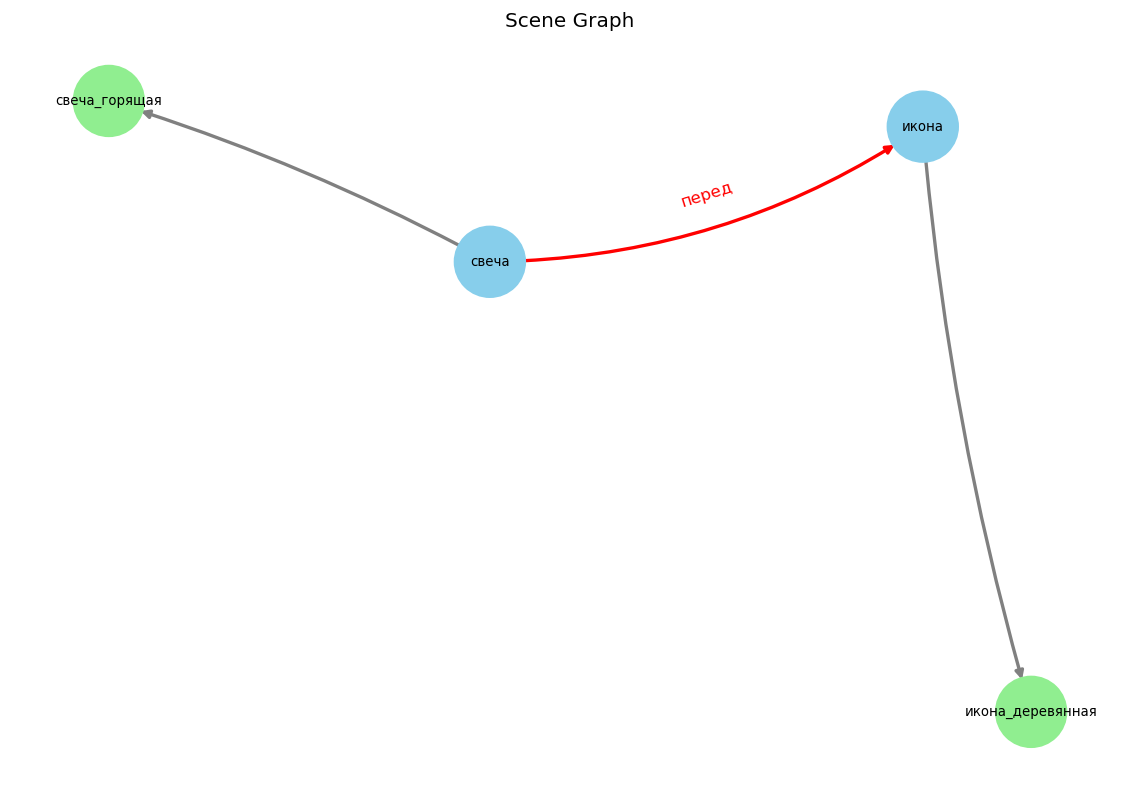


{"scene": {"location": "котельная", "objects": [{"котёл": []}, {"труба": ["металлическая"]}, {"насос": ["металлический", "тяжелый"]}], "relations": [["труба", "рядом с", "насос"], ["насос", "возле", "котёл"]]}, "description": "Металлическая труба проходит рядом с тяжелым металлическим насосом, который стоит возле котла."}



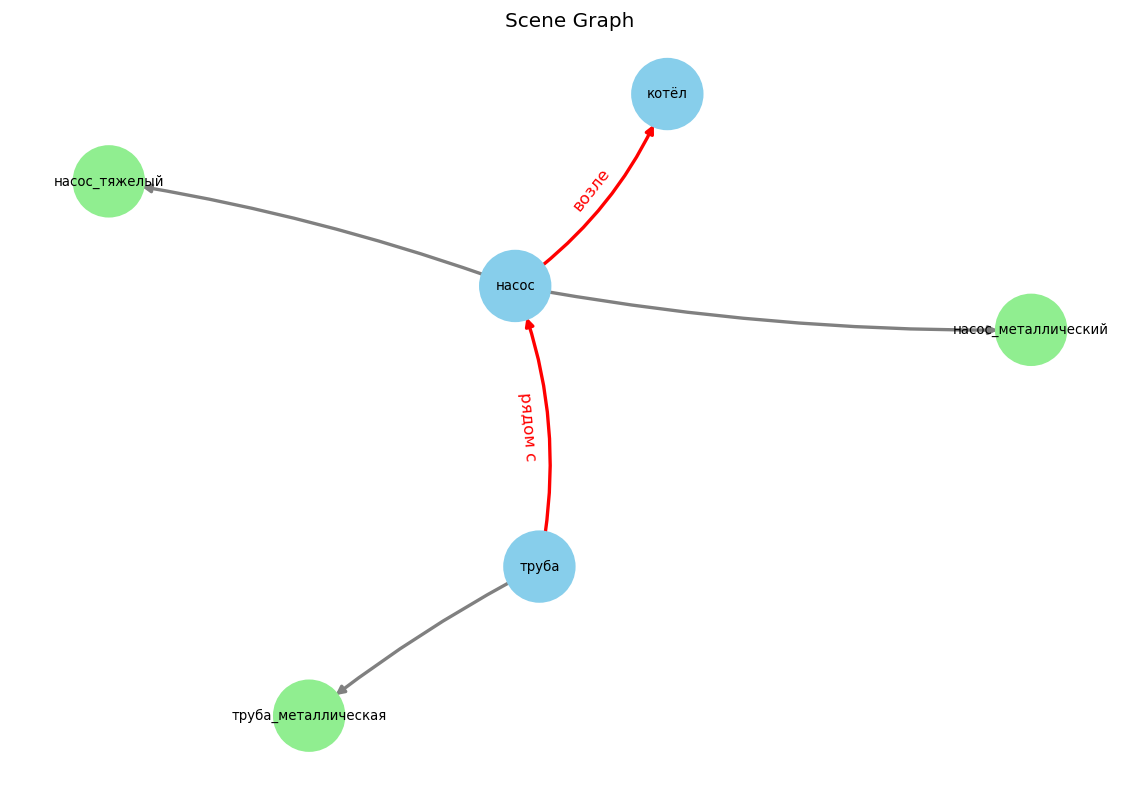


{"scene": {"location": "котельная", "objects": [{"котёл": []}, {"труба": ["металлическая"]}, {"насос": ["металлический", "тяжелый"]}], "relations": [["труба", "над", "котёл"], ["насос", "рядом с", "котёл"]]}, "description": "Металлическая труба проходит над котлом, рядом с которым стоит тяжелый металлический насос."}



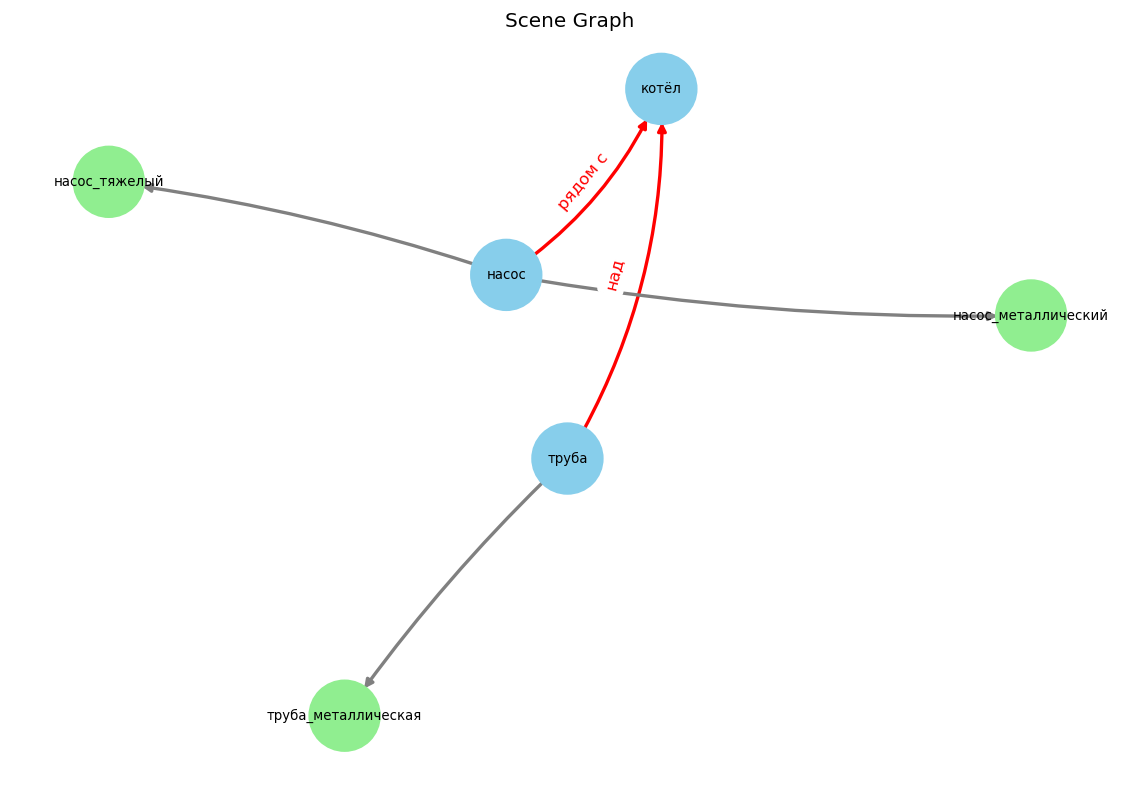


{"scene": {"location": "котельная", "objects": [{"котёл": []}, {"труба": ["металлическая"]}, {"насос": ["металлический", "тяжелый"]}], "relations": [["насос", "соединен с", "труба"], ["труба", "ведет к", "котёл"]]}, "description": "Металлический тяжелый насос соединен с металлической трубой, которая ведет к котлу."}



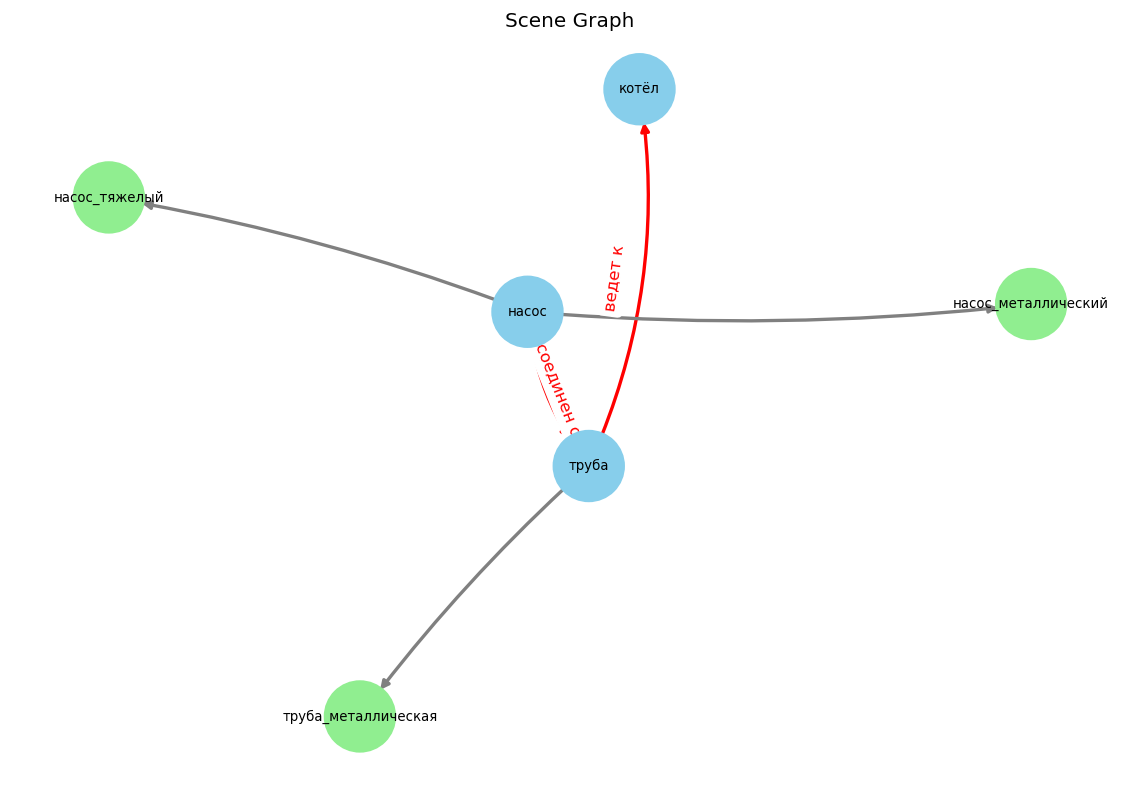


{"scene": {"location": "гримерка", "objects": [{"зеркало": ["плоское", "тяжелое"]}, {"стул": ["деревянный", "тяжёлый"]}, {"грим": ["яркий"]}], "relations": [["грим", "перед", "зеркало"], ["грим", "рядом с", "стул"]]}, "description": "Яркий грим лежит перед тяжелым плоским зеркалом, рядом с деревянным тяжелым стулом."}



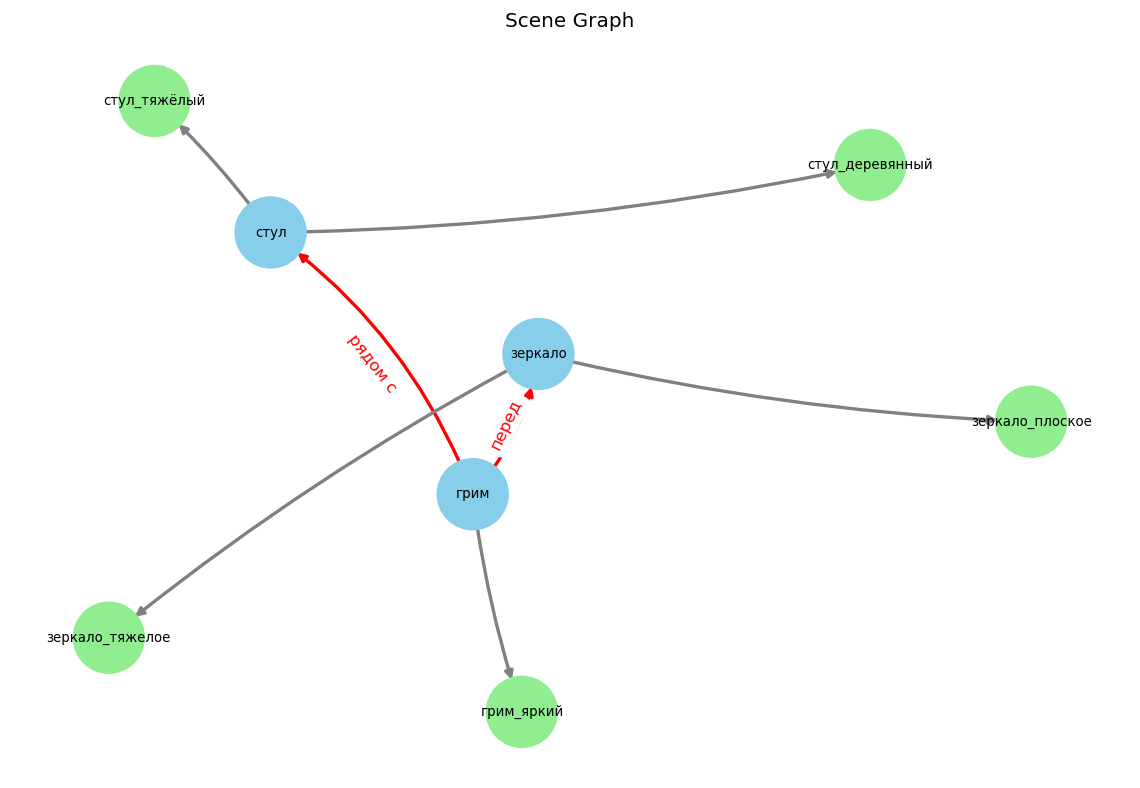


{"scene": {"location": "гримерка", "objects": [{"зеркало": ["плоское", "тяжелое"]}, {"стул": ["деревянный", "тяжёлый"]}, {"грим": ["яркий"]}], "relations": [["грим", "перед", "зеркало"], ["стул", "рядом с", "зеркало"]]}, "description": "Яркий грим размазан перед тяжелым плоским зеркалом, рядом стоит деревянный тяжелый стул."}



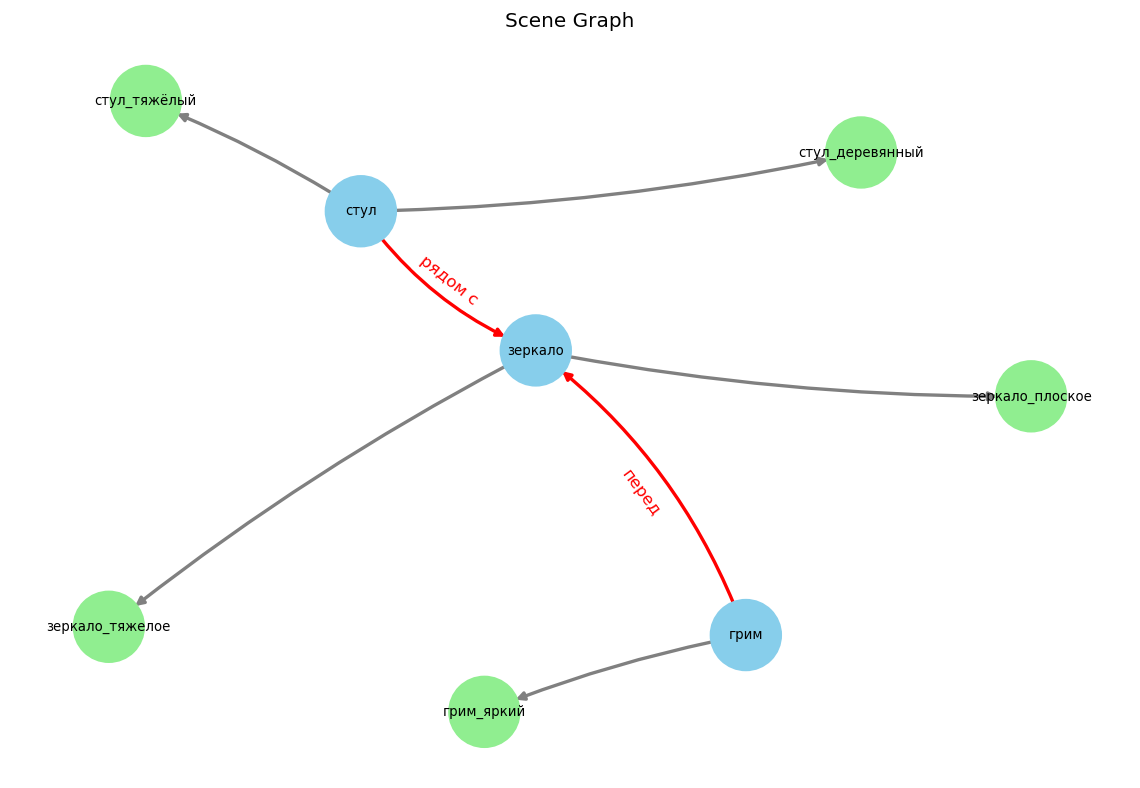


{"scene": {"location": "гримерка", "objects": [{"зеркало": ["плоское", "тяжелое"]}, {"стул": ["деревянный", "тяжёлый"]}, {"грим": ["яркий"]}], "relations": [["стул", "перед", "зеркало"], ["грим", "на", "зеркало"]]}, "description": "Деревянный тяжелый стул стоит перед тяжелым плоским зеркалом, на котором размазан яркий грим."}



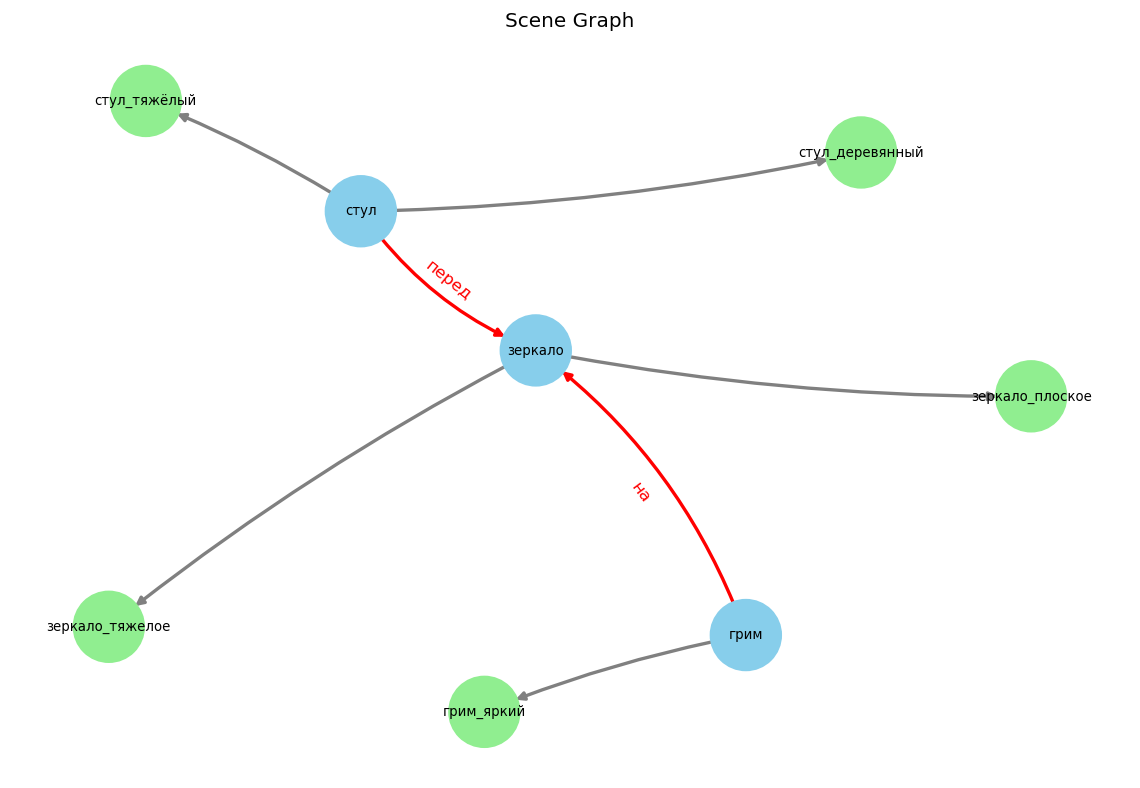


{"scene": {"location": "коридор", "objects": [{"лампа": ["яркая"]}, {"ковер": ["мягкий"]}, {"шкаф": []}], "relations": [["шкаф", "рядом с", "ковер"], ["лампа", "над", "ковер"]]}, "description": "Шкаф стоит рядом с мягким ковром, над которым висит яркая лампа."}



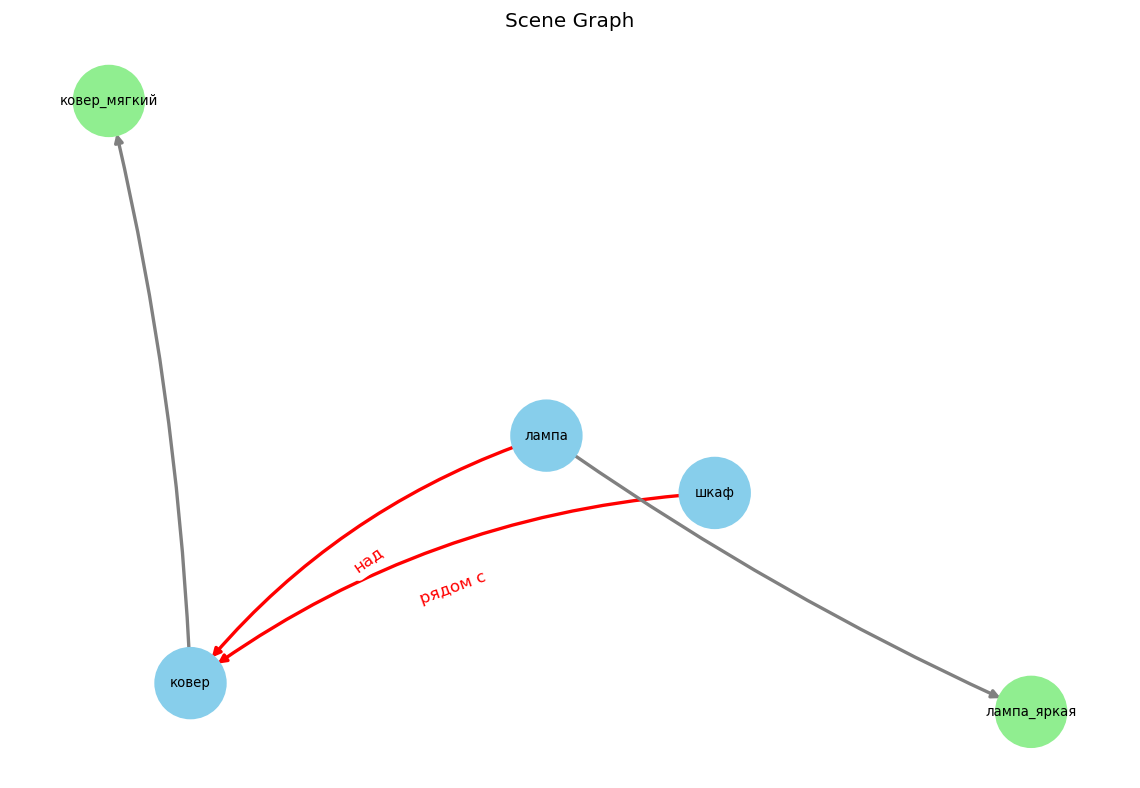


{"scene": {"location": "коридор", "objects": [{"лампа": ["яркая"]}, {"ковер": ["мягкий"]}, {"шкаф": []}], "relations": [["ковер", "рядом с", "шкаф"], ["лампа", "над", "шкаф"]]}, "description": "Мягкий ковер лежит рядом со шкафом, над которым висит яркая лампа."}



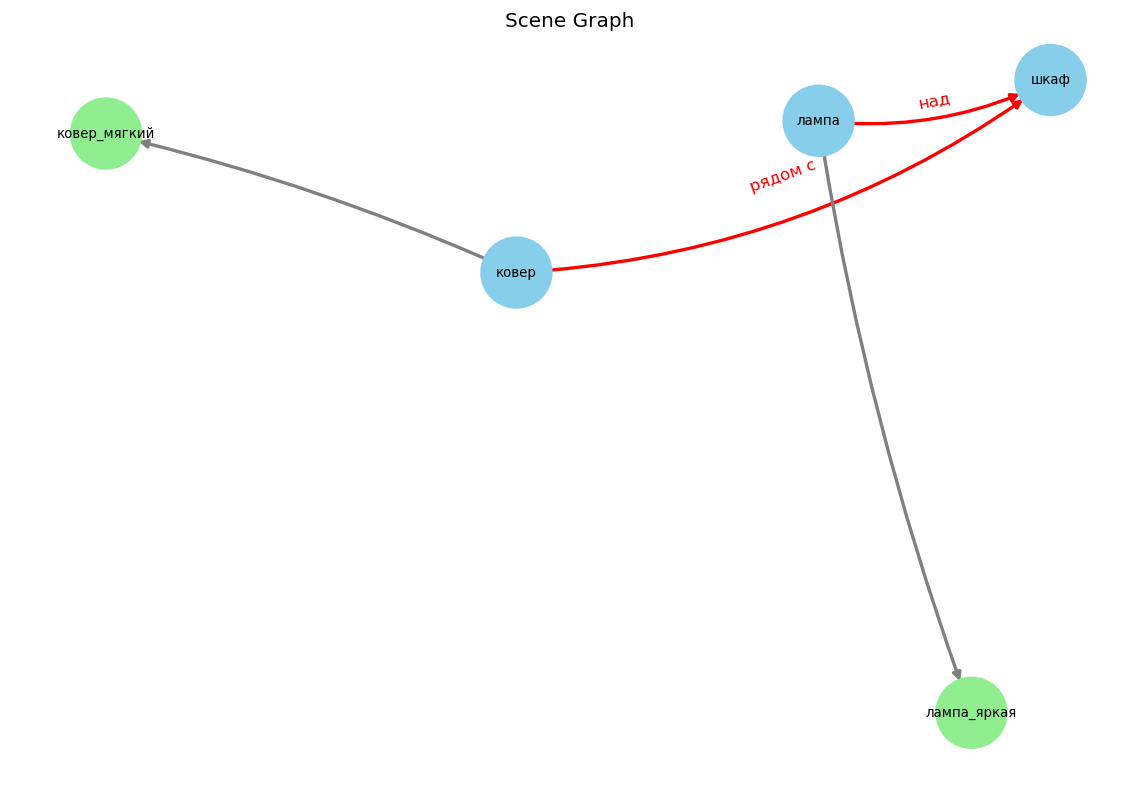


{"scene": {"location": "коридор", "objects": [{"лампа": ["яркая"]}, {"ковер": ["мягкий"]}, {"шкаф": []}], "relations": [["лампа", "над", "ковер"], ["шкаф", "рядом с", "ковер"]]}, "description": "Яркая лампа висит над мягким ковром, рядом стоит шкаф."}



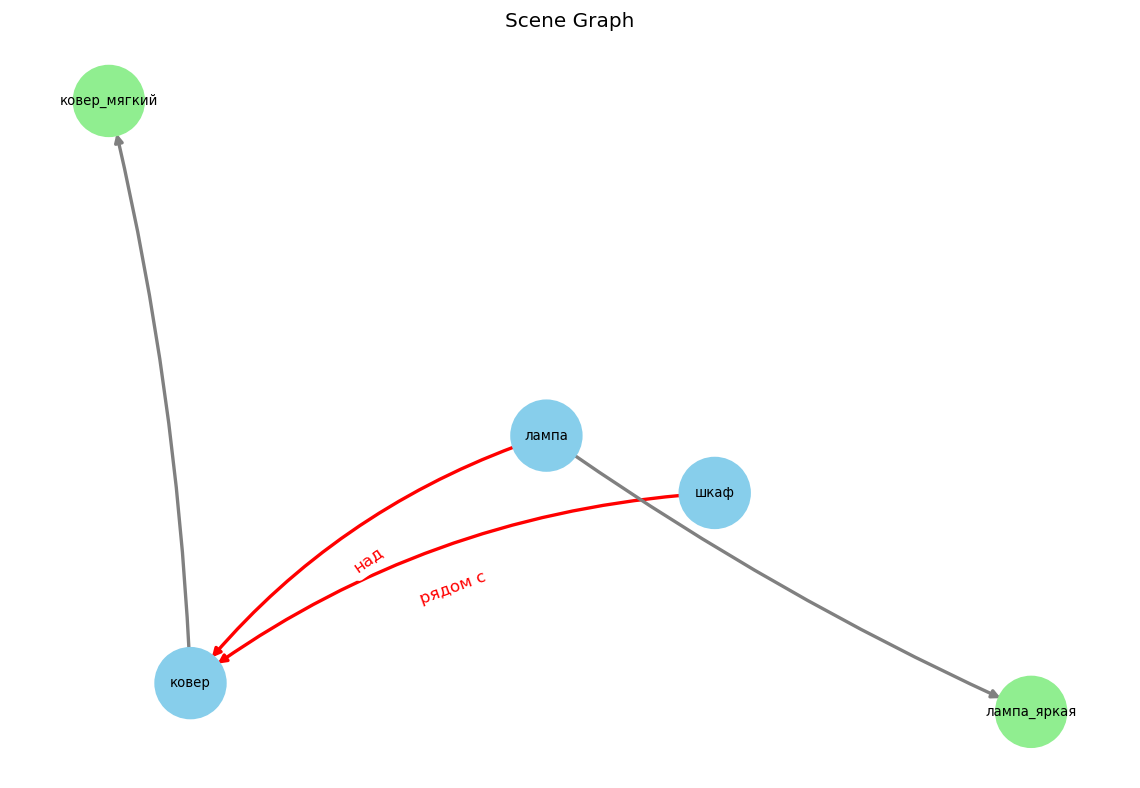


{"scene": {"location": "спортзал", "objects": [{"гантель": ["тяжёлая"]}, {"скамья": ["деревянная"]}, {"коврик": []}], "relations": [["гантель", "на", "коврик"], ["скамья", "рядом с", "коврик"]]}, "description": "Деревянная скамья стоит рядом с ковриком, на котором лежит тяжелая гантель."}



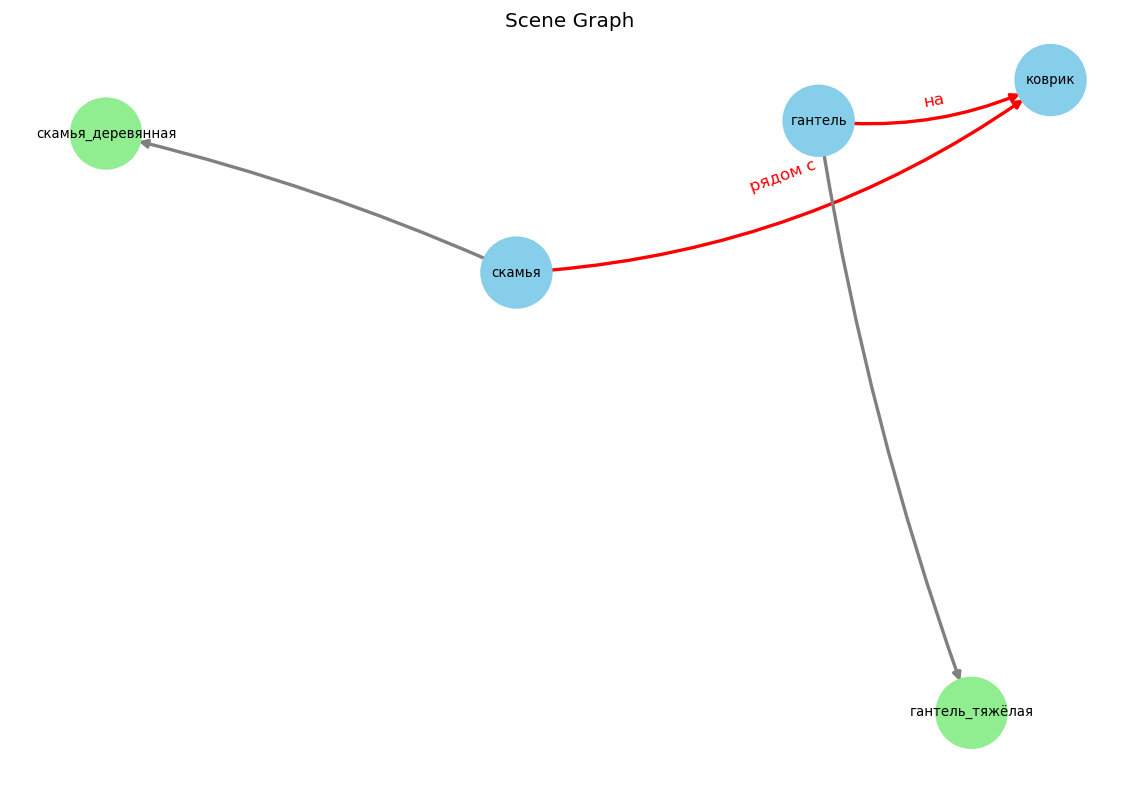


{"scene": {"location": "спортзал", "objects": [{"гантель": ["тяжёлая"]}, {"скамья": ["деревянная"]}, {"коврик": []}], "relations": [["коврик", "рядом с", "гантель"], ["гантель", "возле", "скамья"]]}, "description": "Коврик лежит рядом с тяжелой гантелью, возле деревянной скамьи."}



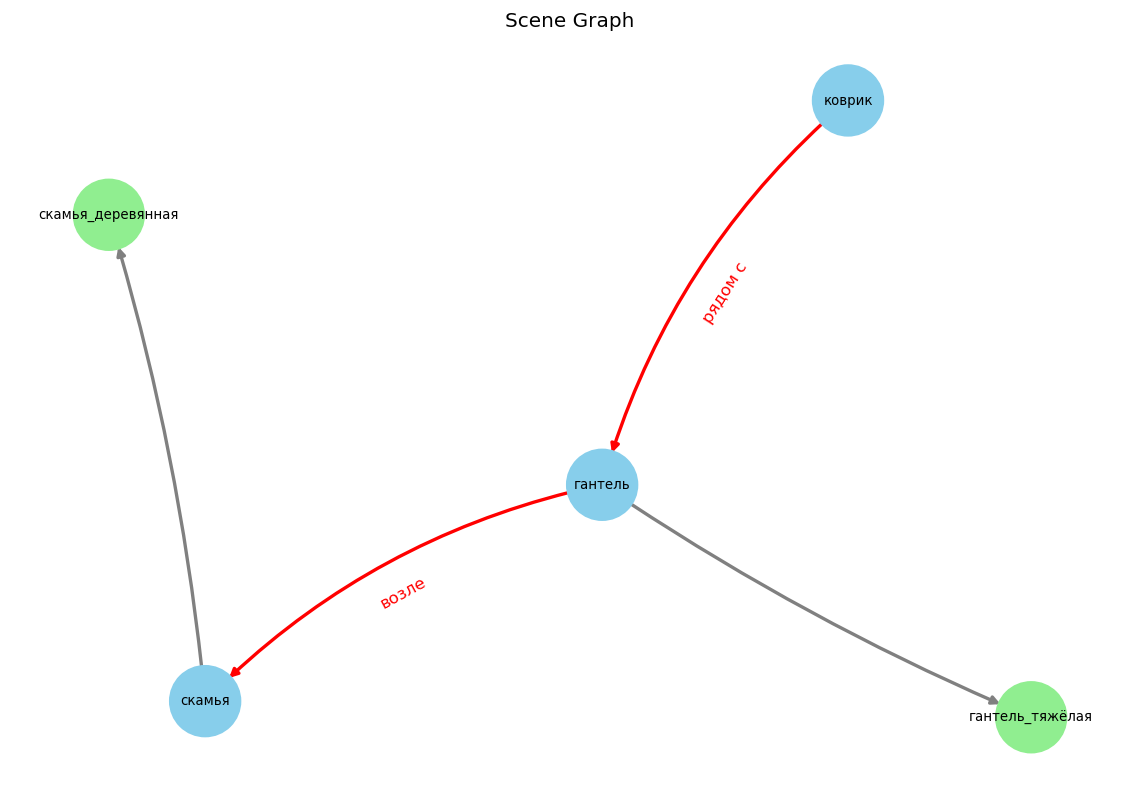


{"scene": {"location": "спортзал", "objects": [{"гантель": ["тяжёлая"]}, {"скамья": ["деревянная"]}, {"коврик": []}], "relations": [["гантель", "на", "скамья"], ["коврик", "рядом с", "скамья"]]}, "description": "Коврик лежит рядом с деревянной скамьей, на которой стоит тяжелая гантель."}



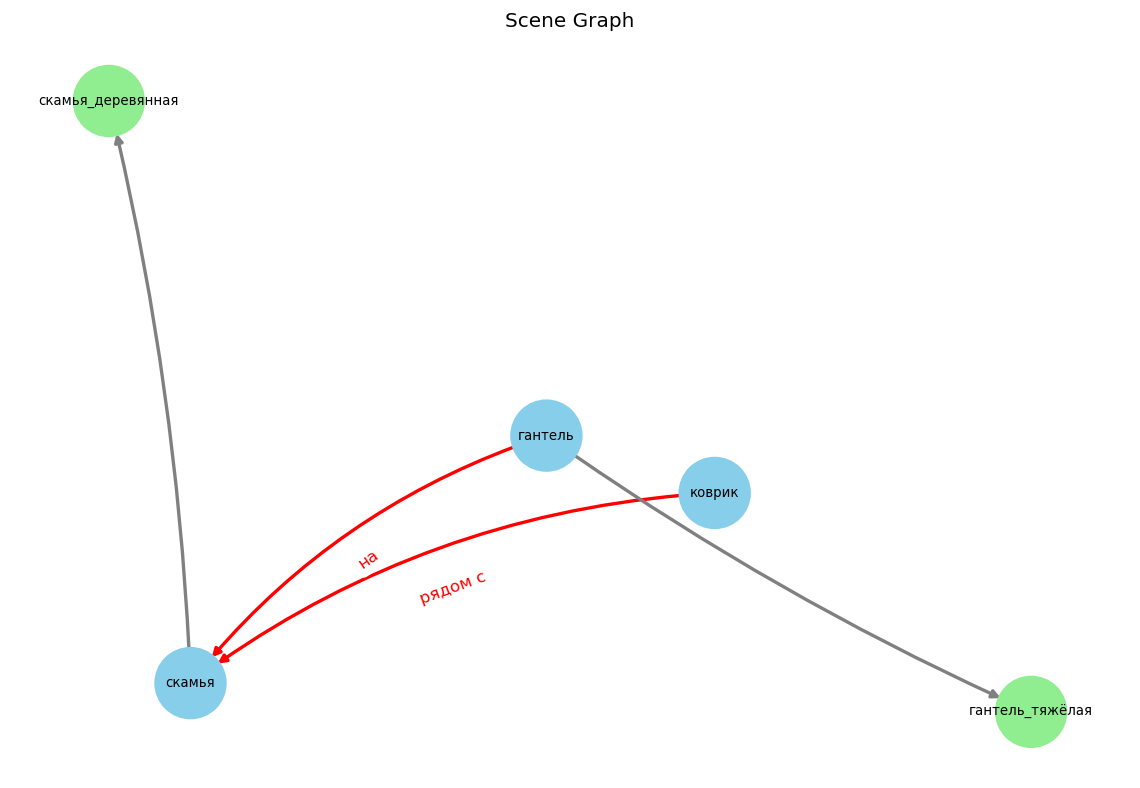


{"scene": {"location": "тренажерный зал", "objects": [{"гантель": ["тяжёлая"]}, {"штанга": ["тяжелая", "металлическая"]}, {"скамья": ["деревянная", "тяжелая"]}], "relations": [["гантель", "рядом с", "штанга"], ["штанга", "возле", "скамья"]]}, "description": "Тяжелая гантель лежит рядом с тяжелой металлической штангой, которая стоит возле тяжелой деревянной скамьи."}



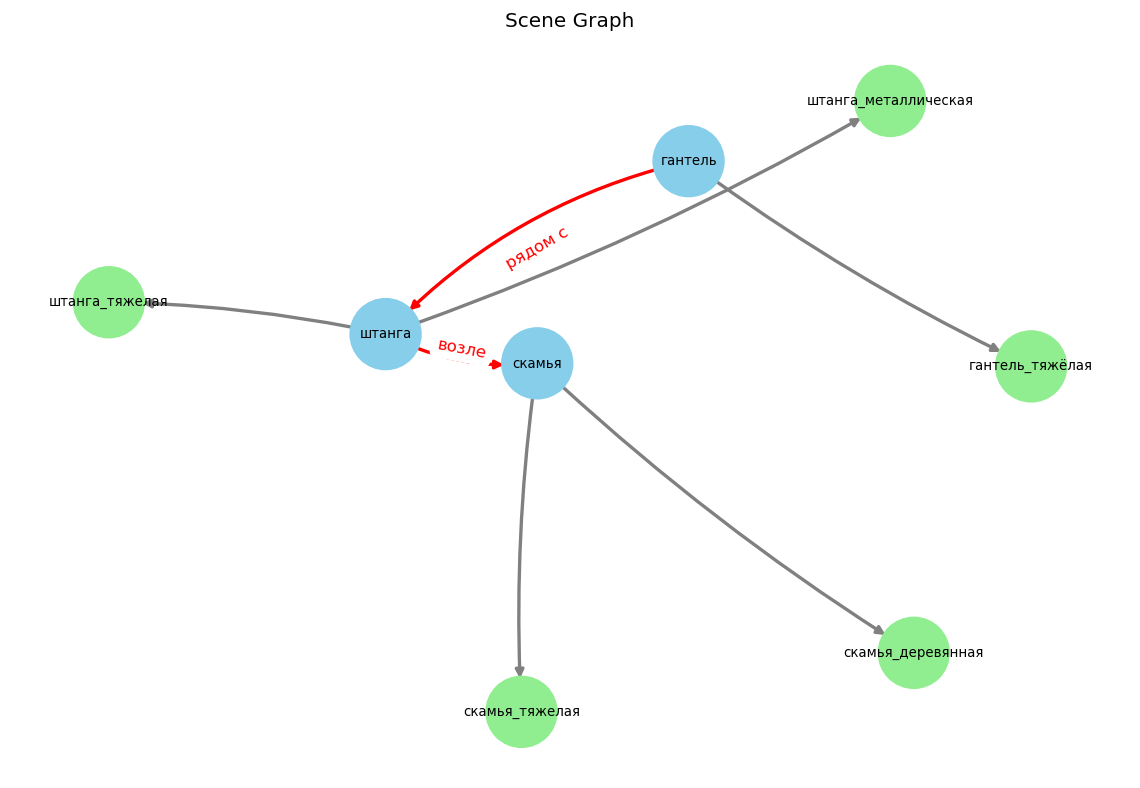


{"scene": {"location": "тренажерный зал", "objects": [{"гантель": ["тяжёлая"]}, {"штанга": ["тяжелая", "металлическая"]}, {"скамья": ["деревянная", "тяжелая"]}], "relations": [["гантель", "на", "скамья"], ["гантель", "рядом с", "штанга"]]}, "description": "Тяжелая гантель лежит на деревянной тяжелой скамье рядом с тяжелой металлической штангой."}



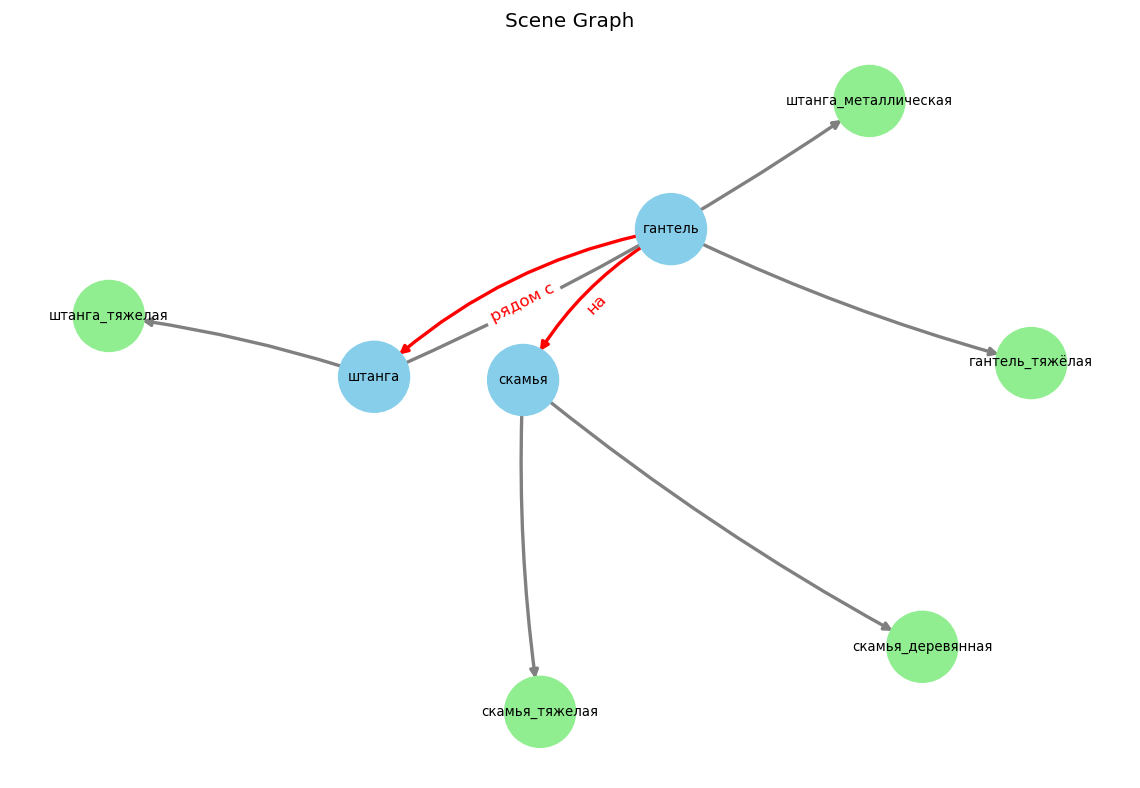


{"scene": {"location": "тренажерный зал", "objects": [{"гантель": ["тяжёлая"]}, {"штанга": ["тяжелая", "металлическая"]}, {"скамья": ["деревянная", "тяжелая"]}], "relations": [["скамья", "рядом с", "штанга"], ["гантель", "возле", "штанга"]]}, "description": "Тяжелая деревянная скамья стоит рядом с тяжелой металлической штангой, возле которой лежит тяжелая гантель."}



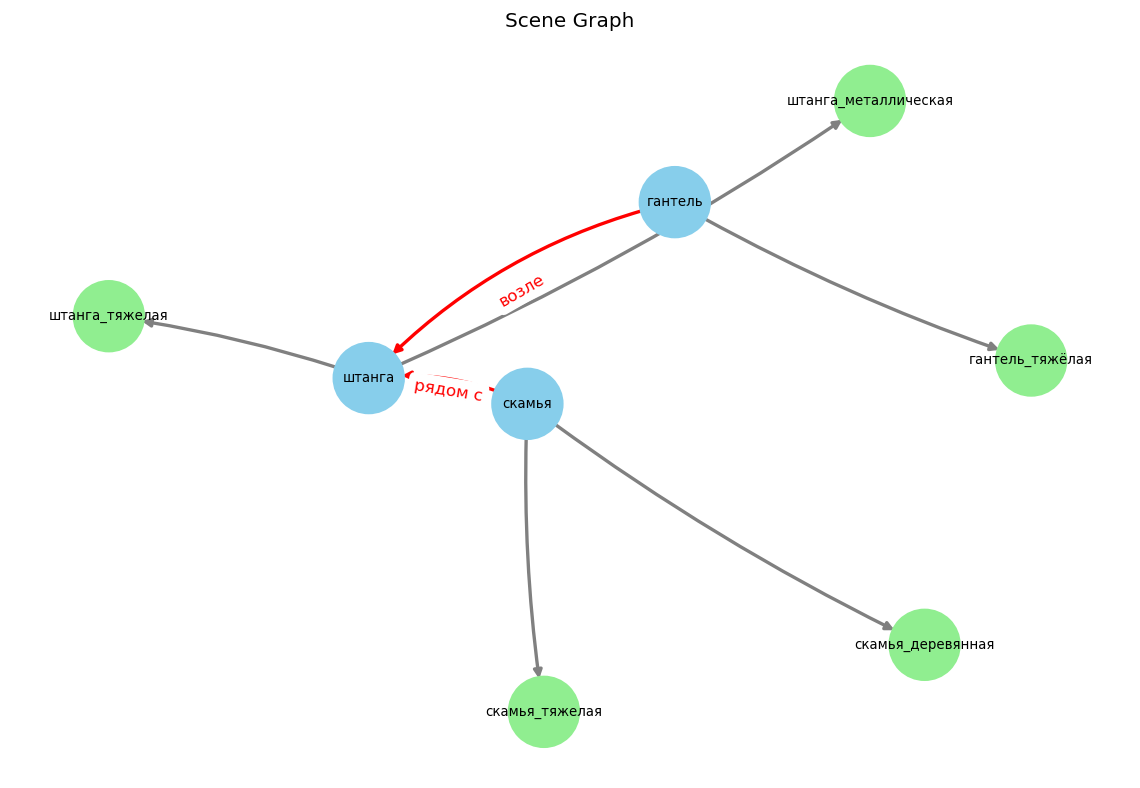


{"scene": {"location": "бассейн", "objects": [{"полотенце": []}, {"шезлонг": ["складной"]}, {"очки": []}], "relations": [["полотенце", "на", "шезлонг"], ["очки", "рядом с", "шезлонг"]]}, "description": "Полотенце лежит на складном шезлонге, рядом с которым — очки."}



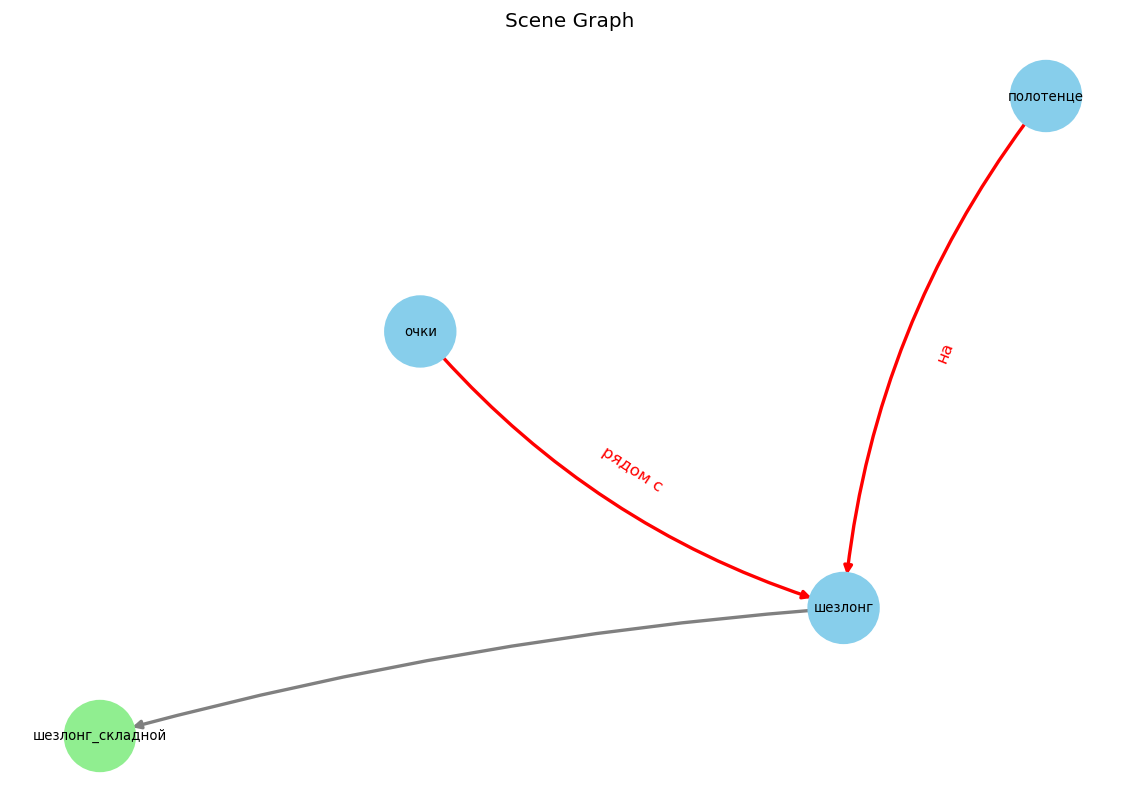


{"scene": {"location": "бассейн", "objects": [{"полотенце": []}, {"шезлонг": ["складной"]}, {"очки": []}], "relations": [["очки", "на", "шезлонг"], ["очки", "рядом с", "полотенце"]]}, "description": "Очки лежат на складном шезлонге, рядом с полотенцем."}



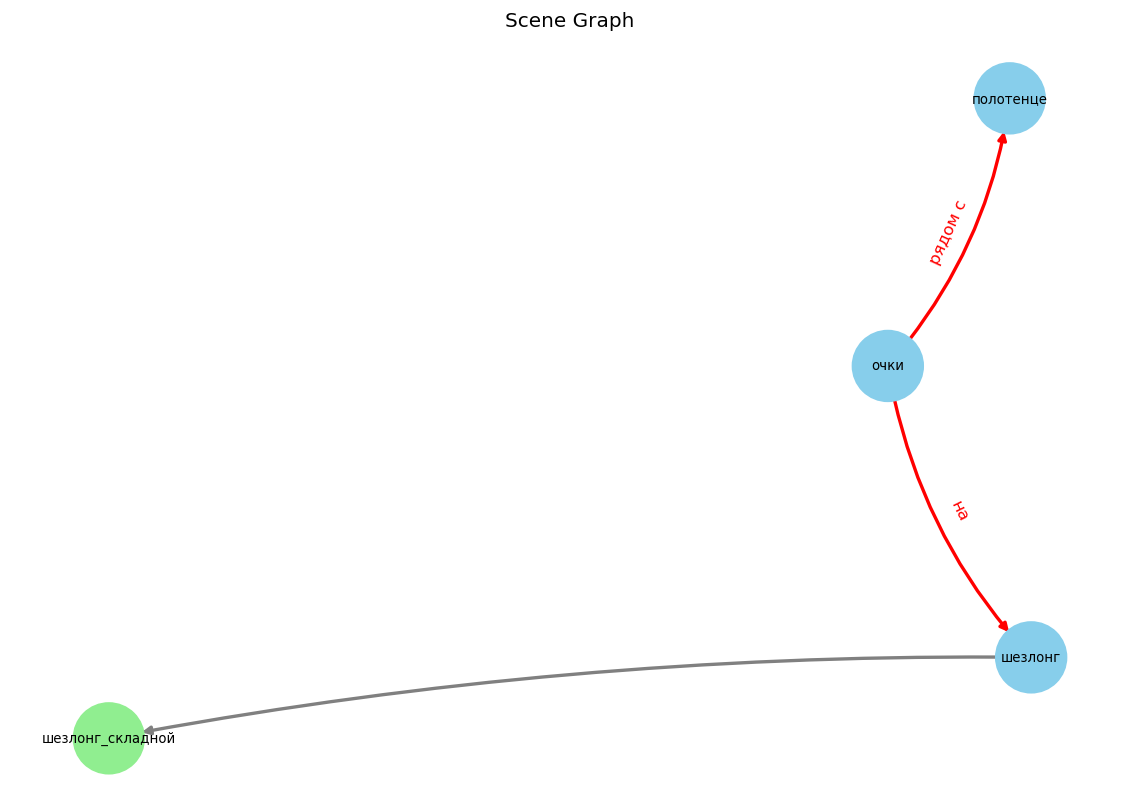


{"scene": {"location": "бассейн", "objects": [{"полотенце": []}, {"шезлонг": ["складной"]}, {"очки": []}], "relations": [["очки", "на", "полотенце"]]}, "description": "Складной шезлонг стоит рядом с полотенцем, на котором лежат очки."}



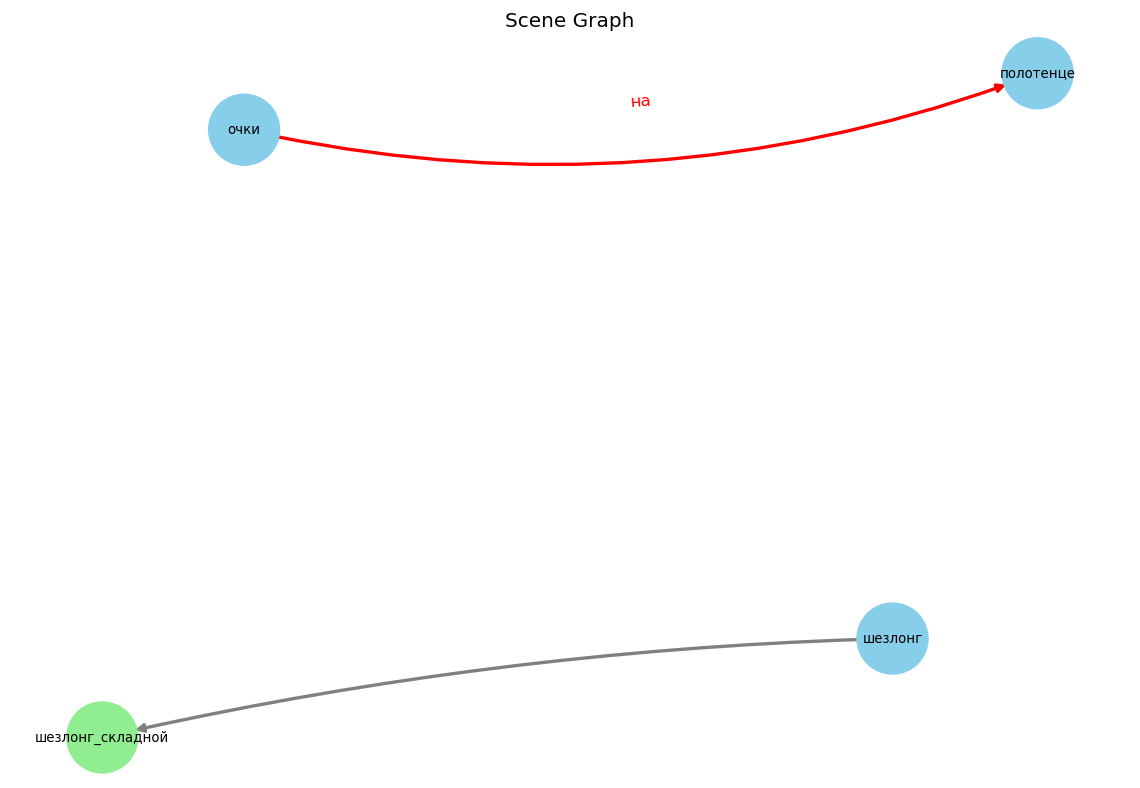


{"scene": {"location": "павильон", "objects": [{"стол": ["круглый"]}, {"стул": ["деревянный", "круглый", "тяжёлый"]}], "relations": [["стул", "рядом с", "стол"]]}, "description": "Круглый тяжелый деревянный стул стоит рядом с круглым столом."}



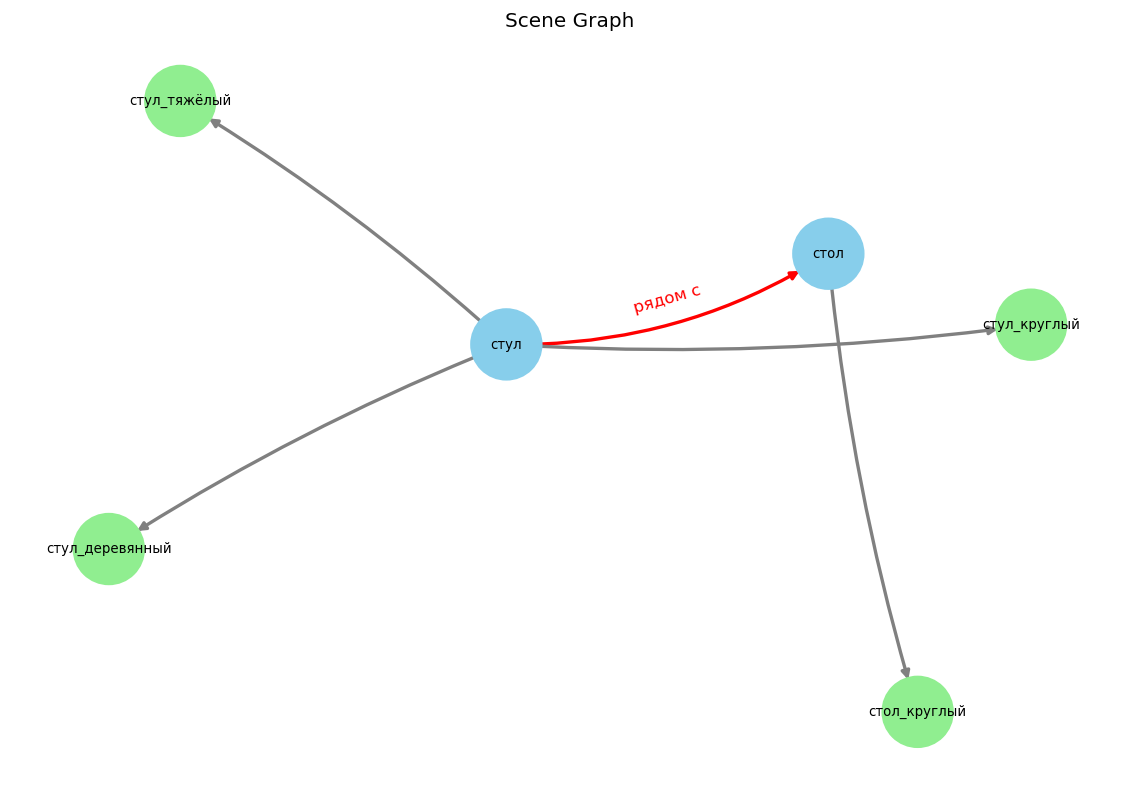


{"scene": {"location": "павильон", "objects": [{"стол": ["круглый"]}, {"стул": ["деревянный", "круглый", "тяжёлый"]}], "relations": [["стол", "рядом с", "стул"]]}, "description": "Круглый стол стоит рядом с тяжелым деревянным круглым стулом."}



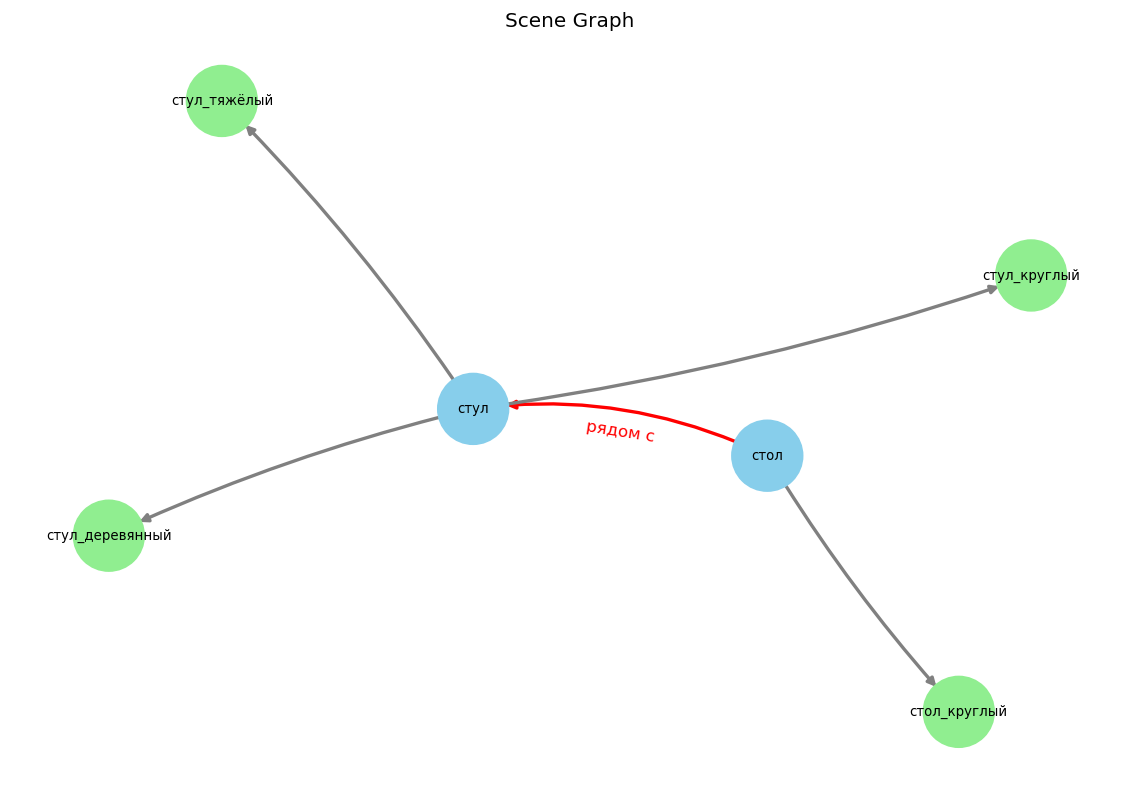


{"scene": {"location": "павильон", "objects": [{"стол": ["круглый"]}, {"стул": ["деревянный", "круглый", "тяжёлый"]}], "relations": [["стол", "рядом с", "стул"]]}, "description": "Круглый стол стоит рядом с деревянным, тяжелым, круглым стулом."}



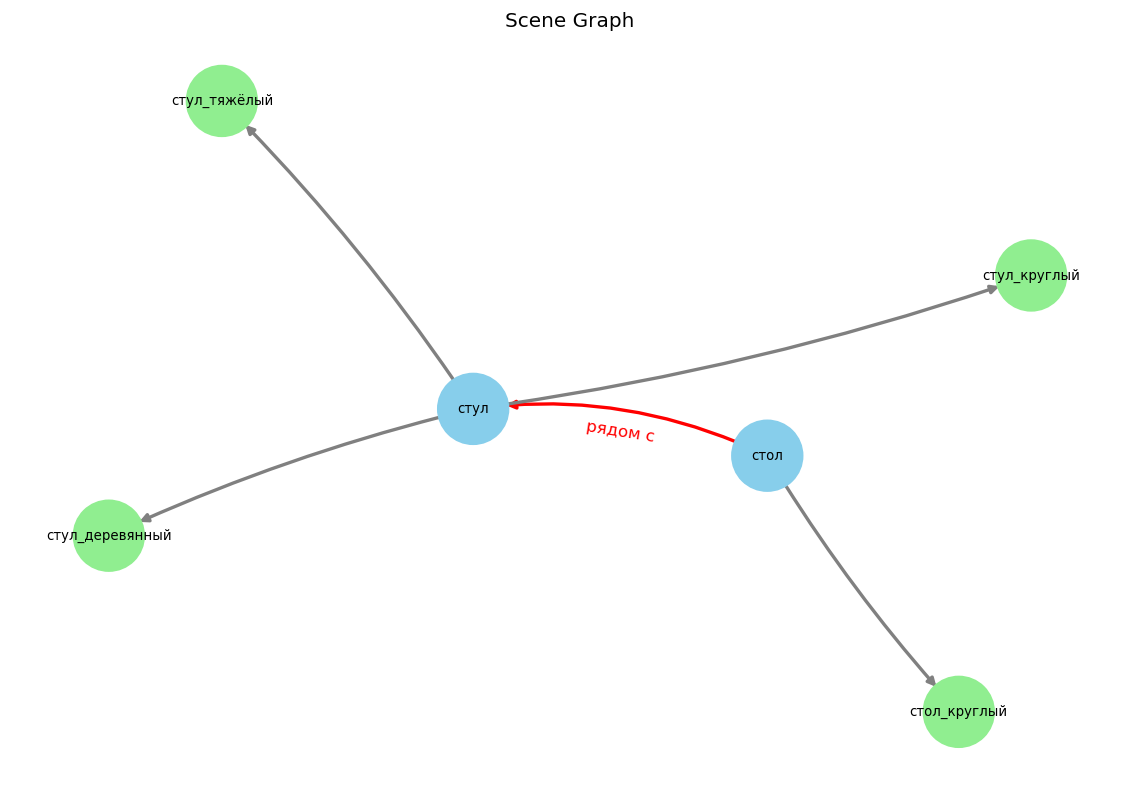


{"scene": {"location": "автосервис", "objects": [{"гаечный ключ": ["металлический"]}, {"домкрат": ["металлический"]}, {"аккумулятор": ["тяжёлый", "плоский", "квадратный"]}, {"шина": []}], "relations": [["гаечный ключ", "рядом с", "аккумулятор"], ["шина", "возле", "домкрат"]]}, "description": "Металлический гаечный ключ лежит рядом с плоским квадратным тяжелым аккумулятором.  \n\nШина находится возле металлического домкрата."}



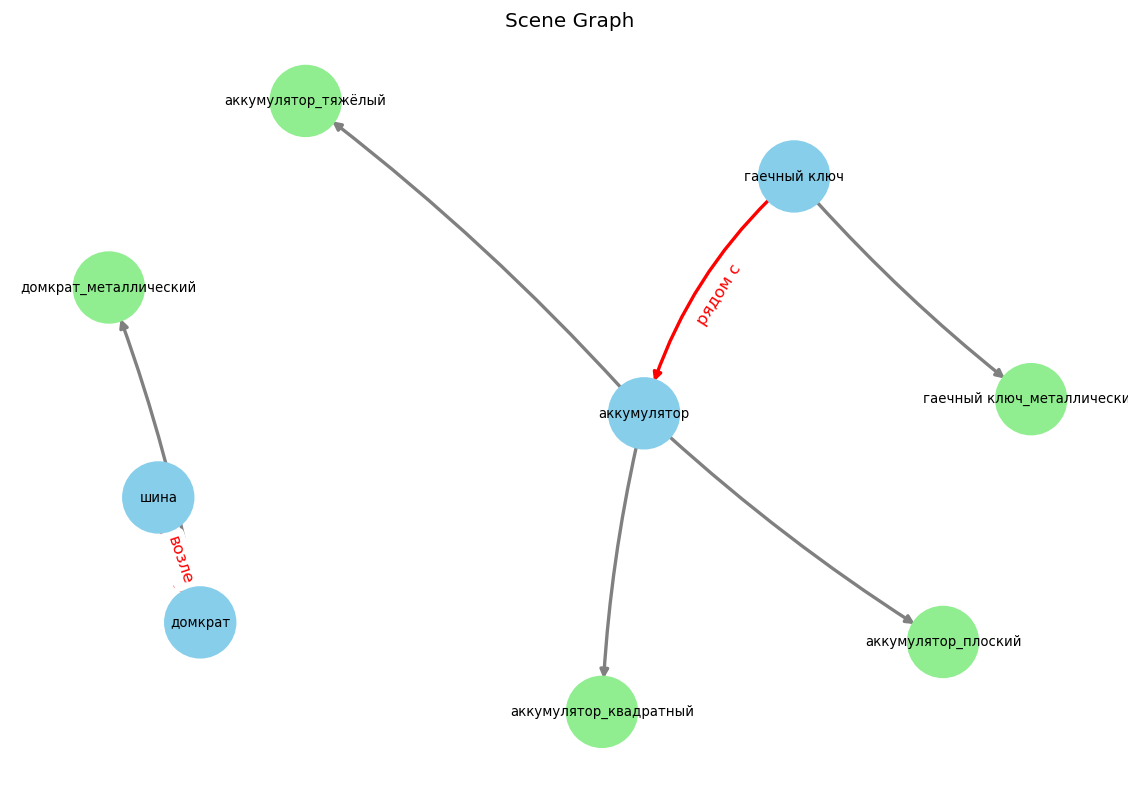


{"scene": {"location": "автосервис", "objects": [{"гаечный ключ": ["металлический"]}, {"домкрат": ["металлический"]}, {"аккумулятор": ["тяжёлый", "плоский", "квадратный"]}, {"шина": []}], "relations": [["домкрат", "рядом с", "гаечный ключ"], ["аккумулятор", "недалеко от", "домкрат"], ["шина", "рядом с", "аккумулятор"]]}, "description": "Металлический домкрат стоит рядом с металлическим гаечным ключом. Квадратный, плоский и тяжелый аккумулятор лежит неподалеку. Шина расположена рядом."}



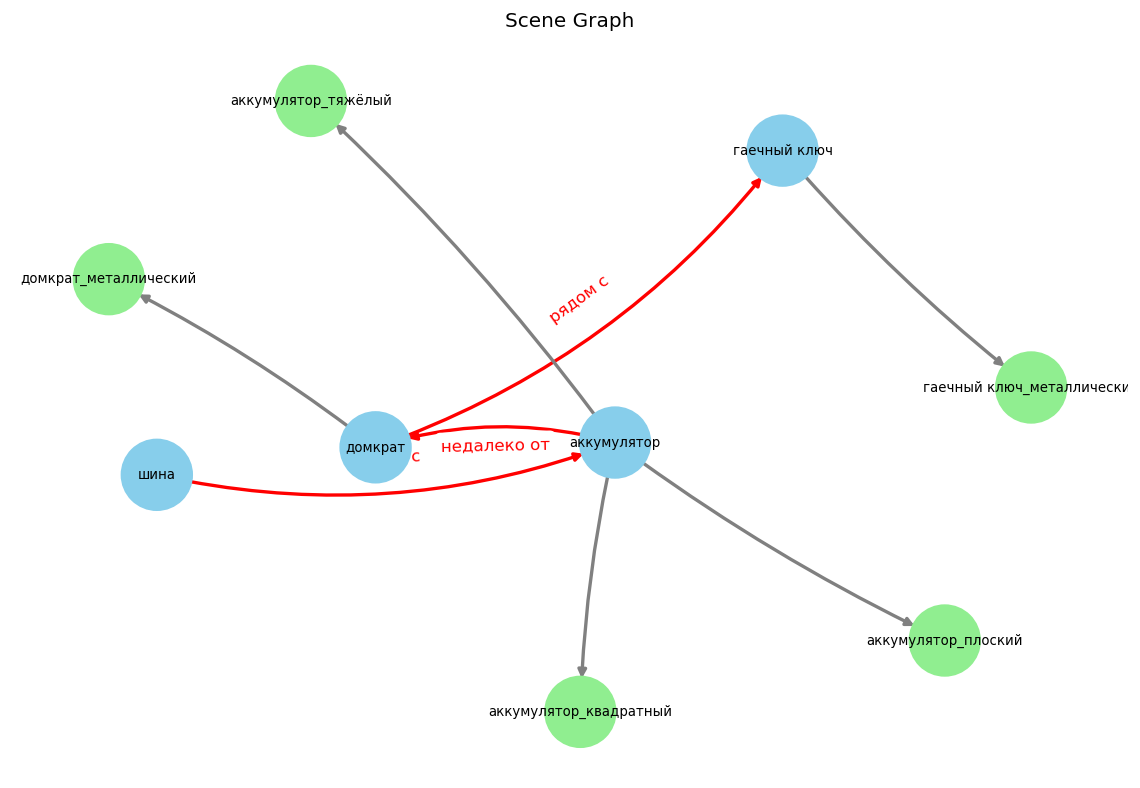


{"scene": {"location": "автосервис", "objects": [{"гаечный ключ": ["металлический"]}, {"домкрат": ["металлический"]}, {"аккумулятор": ["тяжёлый", "плоский", "квадратный"]}, {"шина": []}], "relations": [["аккумулятор", "рядом с", "шина"], ["гаечный ключ", "возле", "домкрат"]]}, "description": "Квадратный тяжелый плоский аккумулятор стоит рядом с шиной.  \n\nМеталлический гаечный ключ лежит возле металлического домкрата."}



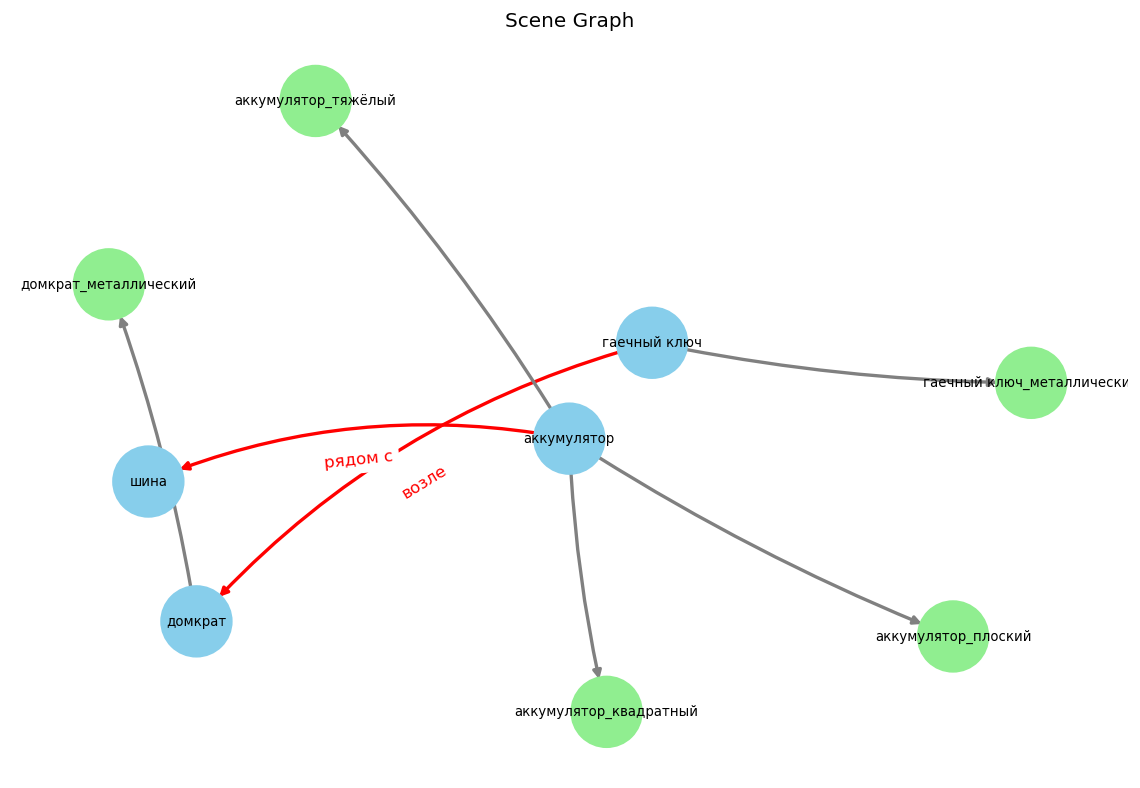


{"scene": {"location": "завод", "objects": [{"станок": []}, {"труба": ["металлическая", "длинная", "тяжелая"]}, {"конвейер": []}], "relations": [["труба", "рядом с", "конвейер"], ["станок", "за", "конвейер"]]}, "description": "Тяжелая, длинная, металлическая труба лежит рядом с конвейером, за которым стоит станок."}



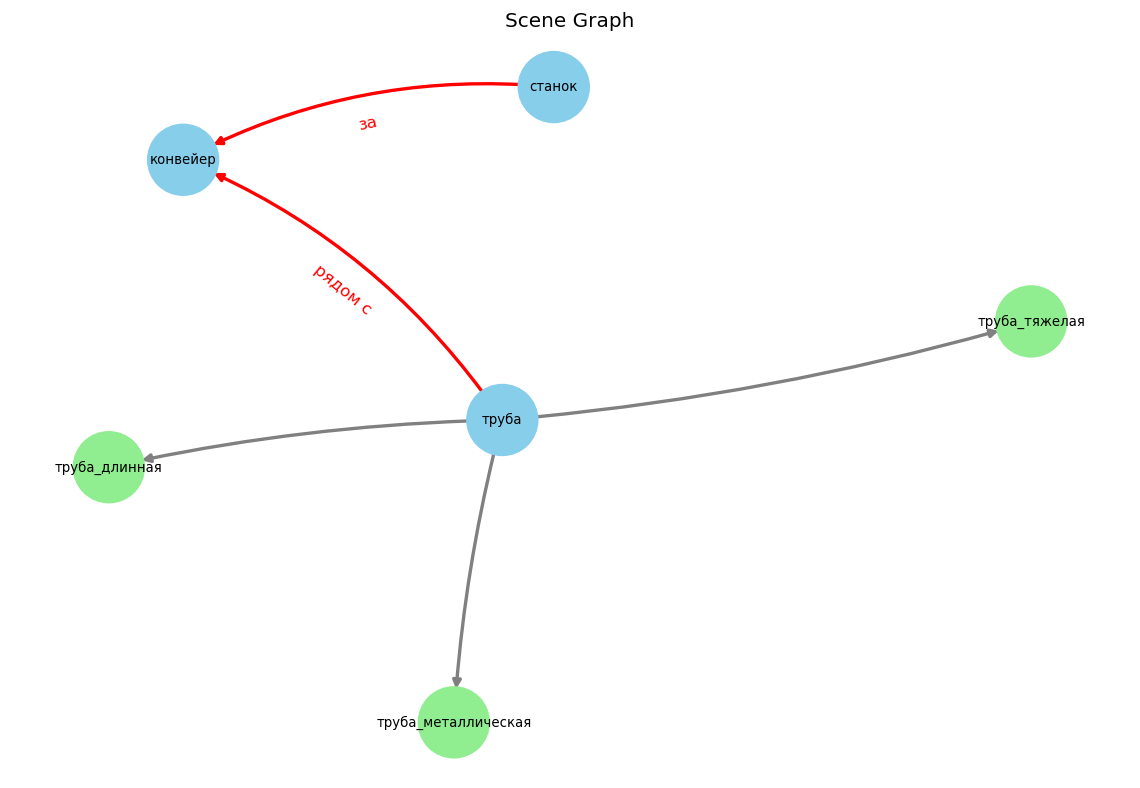


{"scene": {"location": "завод", "objects": [{"станок": []}, {"труба": ["металлическая", "длинная", "тяжелая"]}, {"конвейер": []}], "relations": [["труба", "рядом с", "станок"], ["конвейер", "за", "станок"]]}, "description": "Длинная тяжелая металлическая труба лежит рядом со станком, за которым расположен конвейер."}



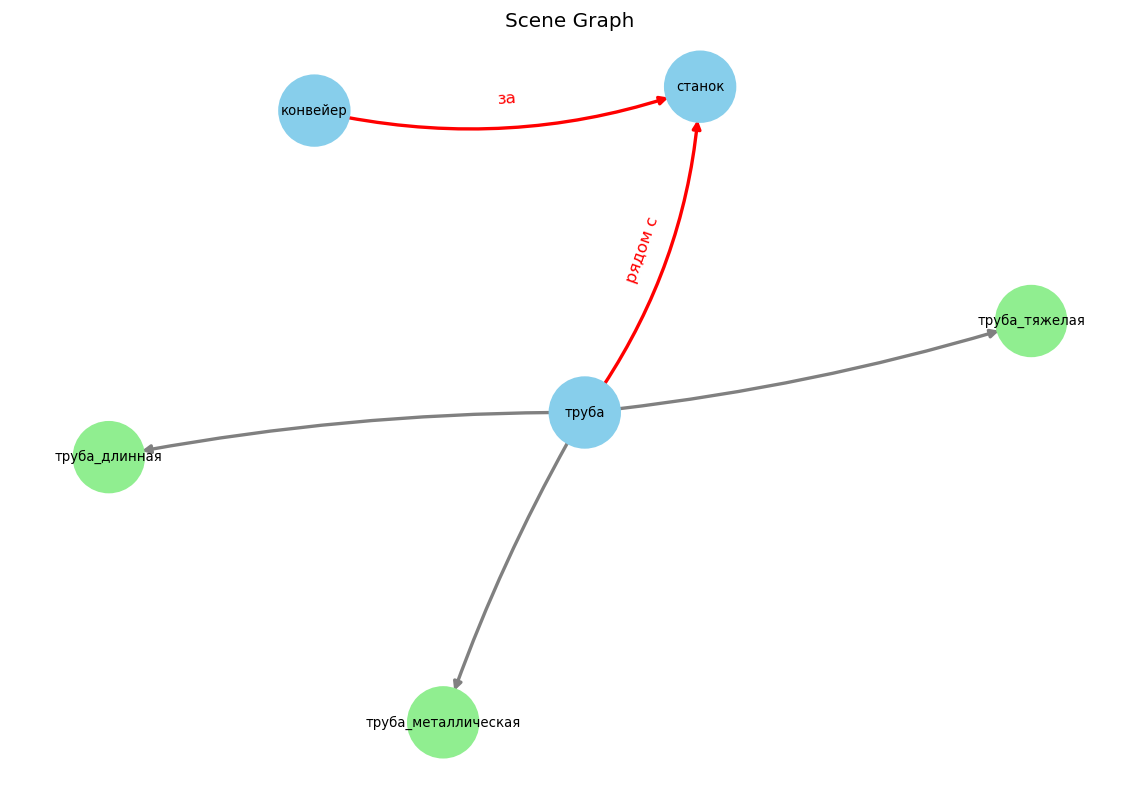


{"scene": {"location": "завод", "objects": [{"станок": []}, {"труба": ["металлическая", "длинная", "тяжелая"]}, {"конвейер": []}], "relations": [["труба", "рядом с", "конвейер"], ["конвейер", "за", "станок"]]}, "description": "Длинная тяжелая металлическая труба лежит рядом с конвейером, за которым расположен станок."}



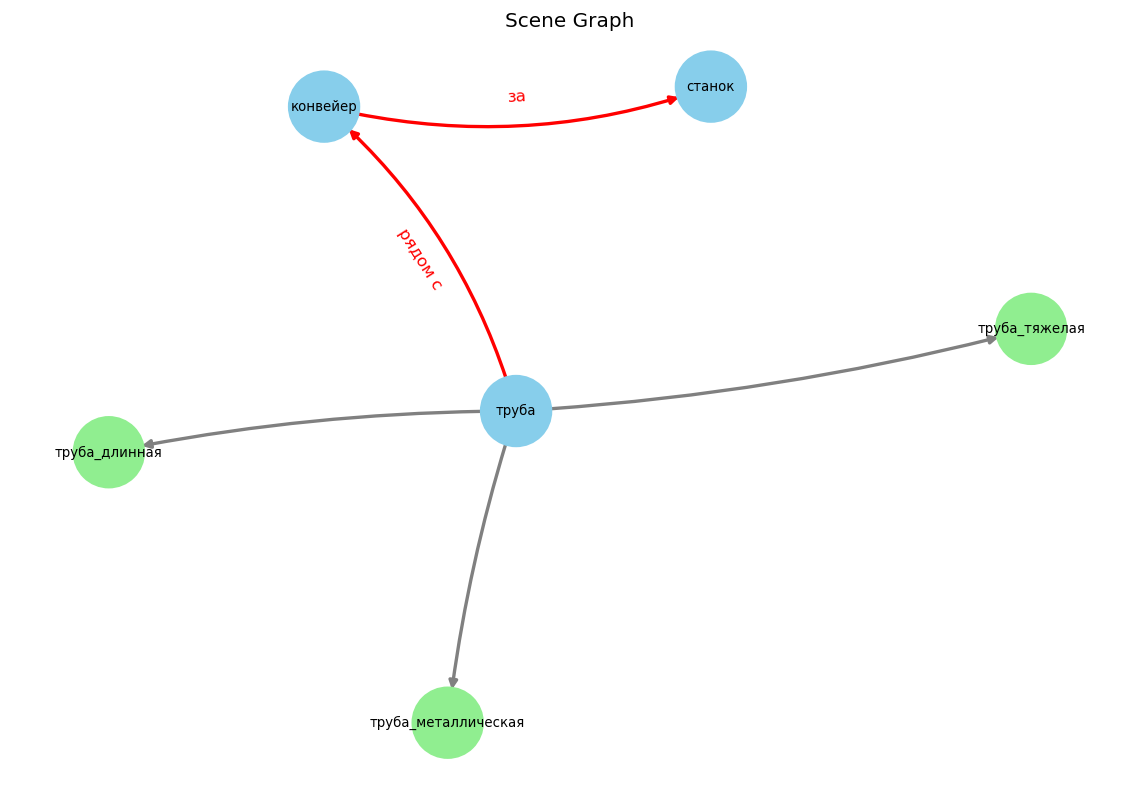


{"scene": {"location": "спортзал", "objects": [{"гантель": ["тяжёлая", "металлическая"]}, {"скамья": ["деревянная"]}], "relations": [["гантель", "на", "скамья"]]}, "description": "Тяжелая металлическая гантель лежит на деревянной скамье."}



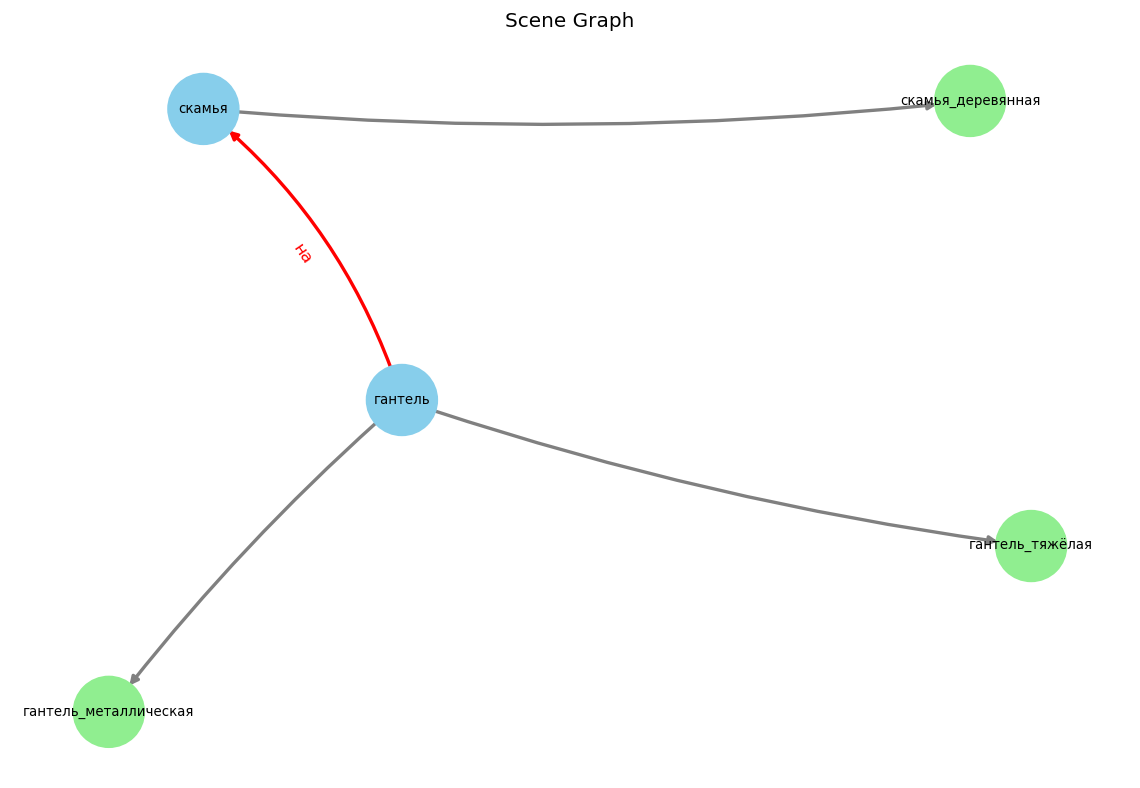


{"scene": {"location": "спортзал", "objects": [{"гантель": ["тяжёлая", "металлическая"]}, {"скамья": ["деревянная"]}], "relations": [["скамья", "рядом с", "гантель"]]}, "description": "Деревянная скамья стоит рядом с тяжелой металлической гантелью."}




{"scene": {"location": "спортзал", "objects": [{"гантель": ["тяжёлая", "металлическая"]}, {"скамья": ["деревянная"]}], "relations": [["гантель", "рядом с", "скамья"]]}, "description": "Металлическая тяжелая гантель лежит рядом с деревянной скамьей."}




{"scene": {"location": "чердак", "objects": [{"сундук": ["большой", "тяжелый", "деревянный"]}, {"лестница": ["высокая", "металлическая"]}, {"фонарь": ["яркий"]}], "relations": [["лестница", "ведет к", "сундук"], ["фонарь", "рядом с", "сундук"]]}, "description": "Высокая металлическая лестница ведет к большому тяжелому деревянному сундуку, рядом с которым стоит яркий фонарь."}



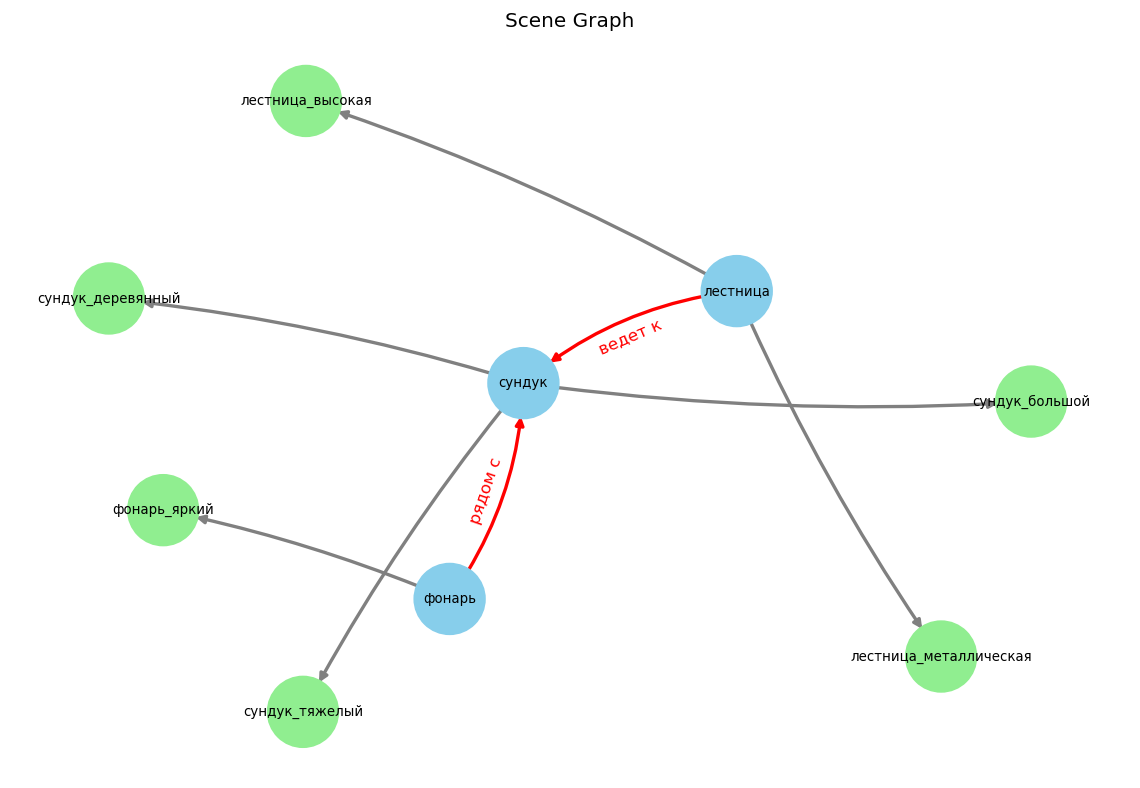


{"scene": {"location": "чердак", "objects": [{"сундук": ["большой", "тяжелый", "деревянный"]}, {"лестница": ["высокая", "металлическая"]}, {"фонарь": ["яркий"]}], "relations": [["сундук", "рядом с", "лестница"]]}, "description": "Яркий фонарь освещает большой деревянный тяжелый сундук, стоящий рядом с высокой металлической лестницей."}



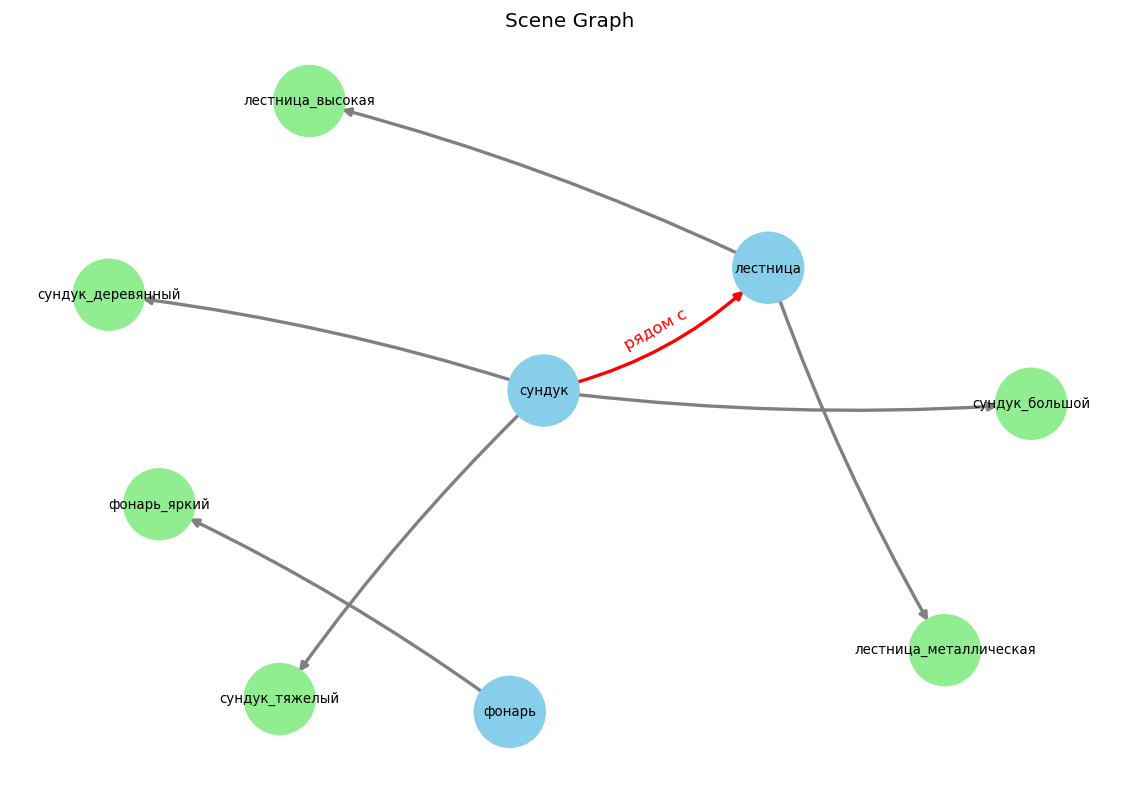


{"scene": {"location": "чердак", "objects": [{"сундук": ["большой", "тяжелый", "деревянный"]}, {"лестница": ["высокая", "металлическая"]}, {"фонарь": ["яркий"]}], "relations": [["сундук", "рядом с", "фонарь"], ["фонарь", "за", "лестница"]]}, "description": "Большой тяжелый деревянный сундук стоит рядом с ярким фонарем, за которым возвышается высокая металлическая лестница."}



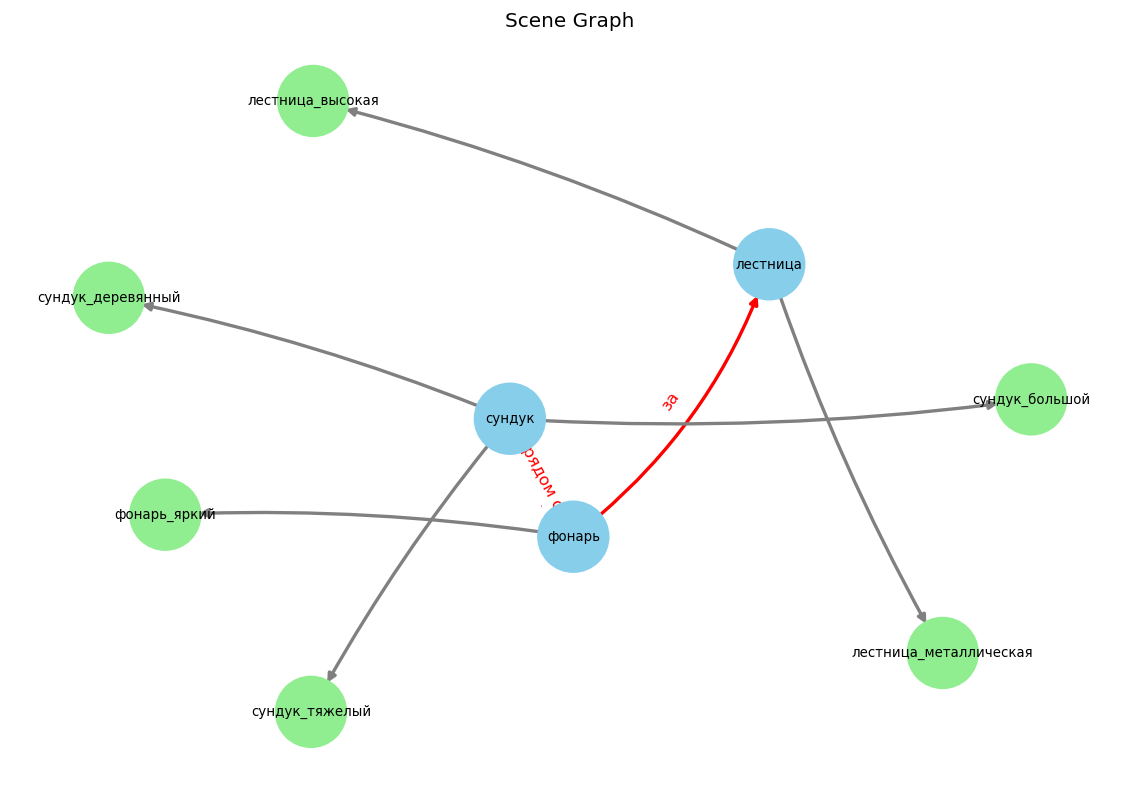


{"scene": {"location": "коридор", "objects": [{"дверь": ["тяжелая"]}, {"лампа": ["яркая", "тяжёлая"]}, {"ковер": ["мягкий"]}], "relations": [["дверь", "под", "лампа"], ["дверь", "рядом с", "ковер"]]}, "description": "Тяжелая дверь стоит под тяжелой яркой лампой, рядом с мягким ковром."}



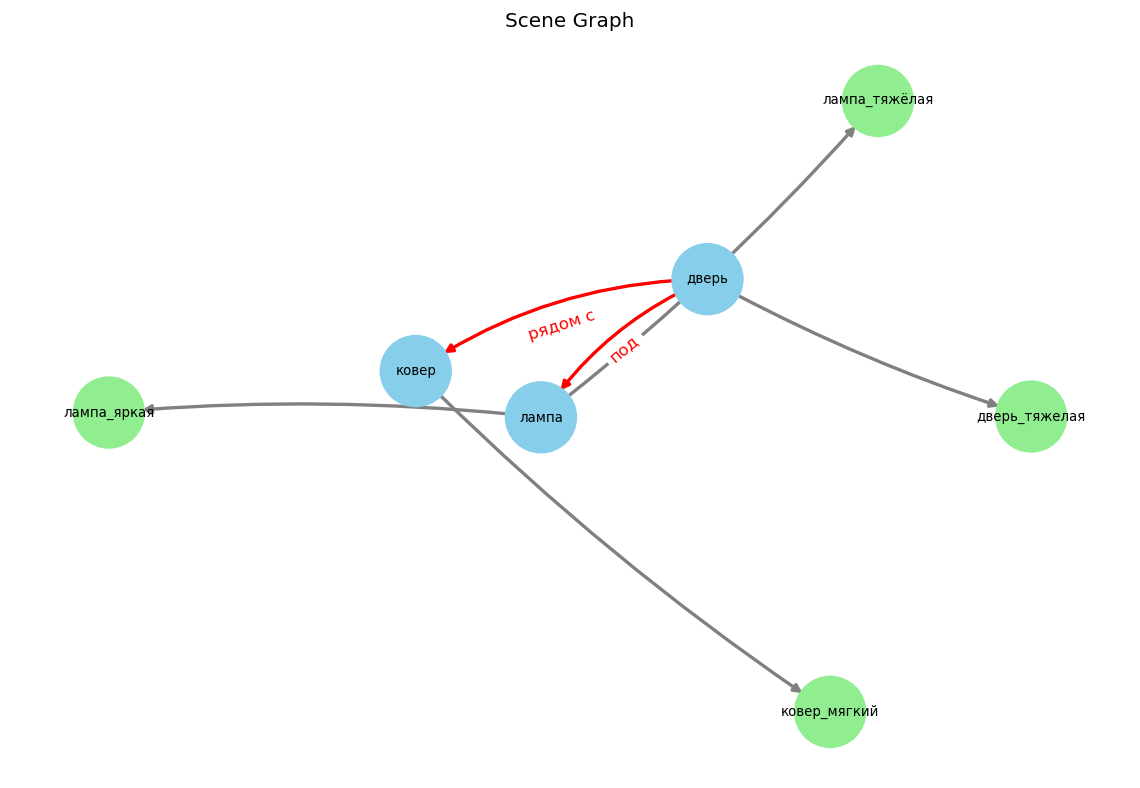


{"scene": {"location": "коридор", "objects": [{"дверь": ["тяжелая"]}, {"лампа": ["яркая", "тяжёлая"]}, {"ковер": ["мягкий"]}], "relations": [["ковер", "перед", "дверь"], ["лампа", "над", "дверь"]]}, "description": "Мягкий ковер лежит перед тяжелой дверью, над которой висит яркая и тяжелая лампа."}



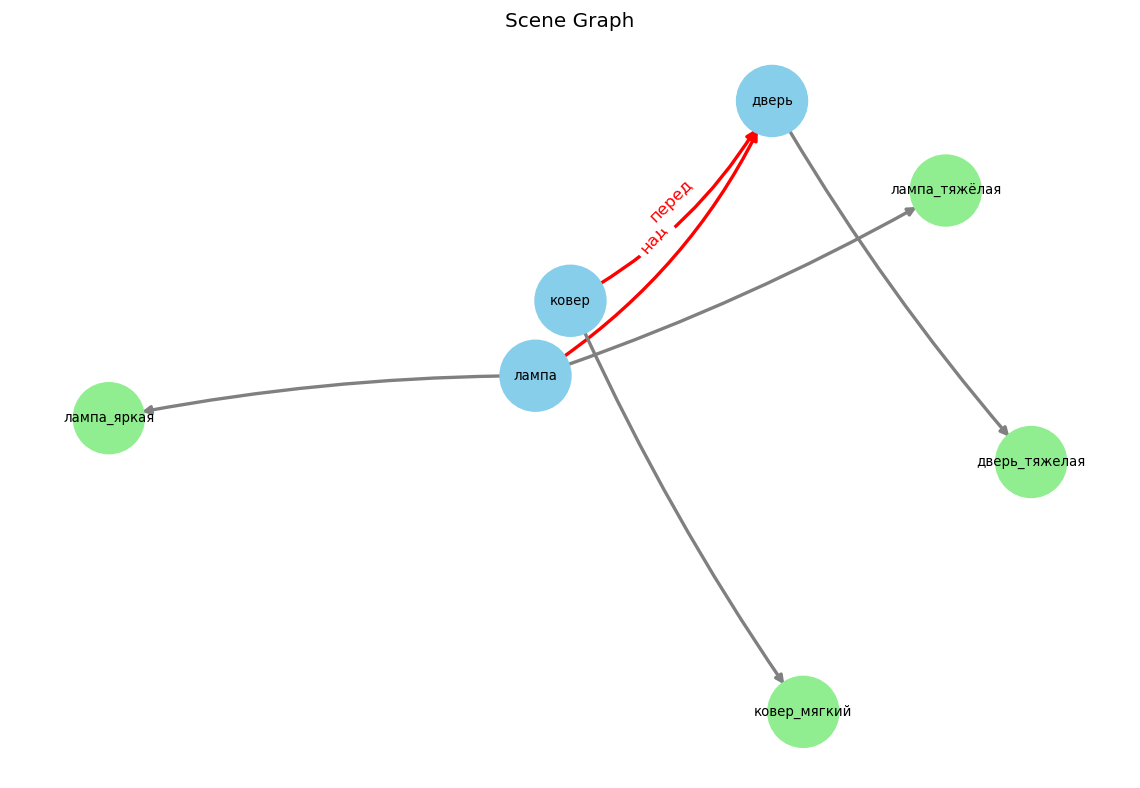


{"scene": {"location": "коридор", "objects": [{"дверь": ["тяжелая"]}, {"лампа": ["яркая", "тяжёлая"]}, {"ковер": ["мягкий"]}], "relations": [["дверь", "под", "лампа"], ["дверь", "рядом с", "ковер"]]}, "description": "Тяжелая дверь стоит под яркой и тяжелой лампой, рядом с мягким ковром."}



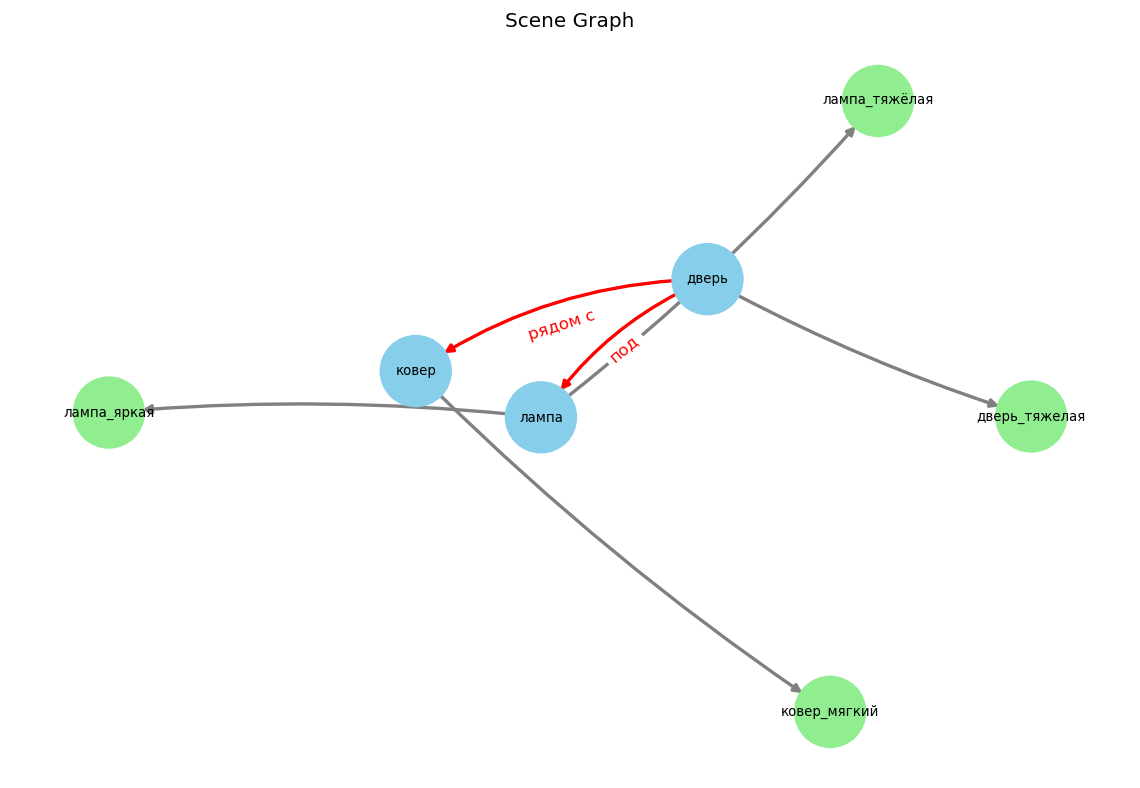


{"scene": {"location": "сад", "objects": [{"дерево": ["зелёное", "высокое"]}, {"скамейка": ["деревянная"]}], "relations": []}, "description": "Деревянная скамейка стоит рядом с высоким зеленым деревом."}




{"scene": {"location": "сад", "objects": [{"дерево": ["зелёное", "высокое"]}, {"скамейка": ["деревянная"]}], "relations": [["дерево", "над", "скамейка"]]}, "description": "Высокое зелёное дерево возвышается над деревянной скамейкой."}



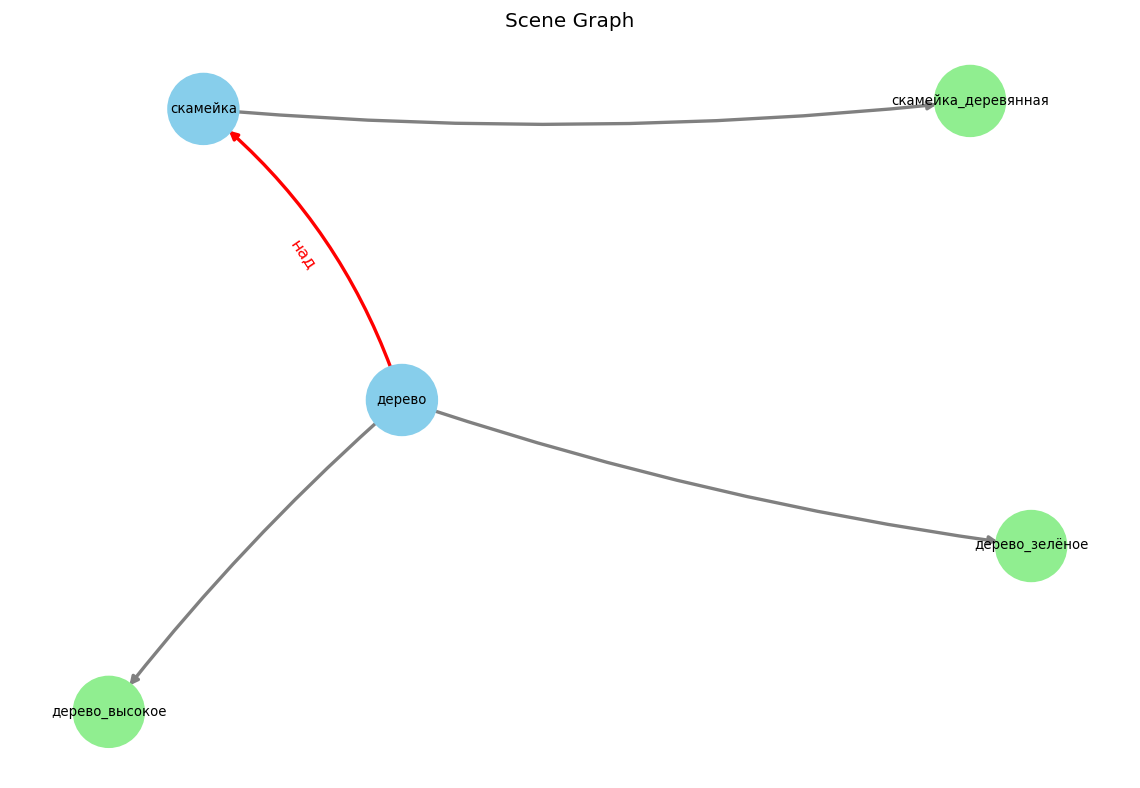


{"scene": {"location": "сад", "objects": [{"дерево": ["зелёное", "высокое"]}, {"скамейка": ["деревянная"]}], "relations": []}, "description": "Деревянная скамейка стоит под высоким зеленым деревом."}



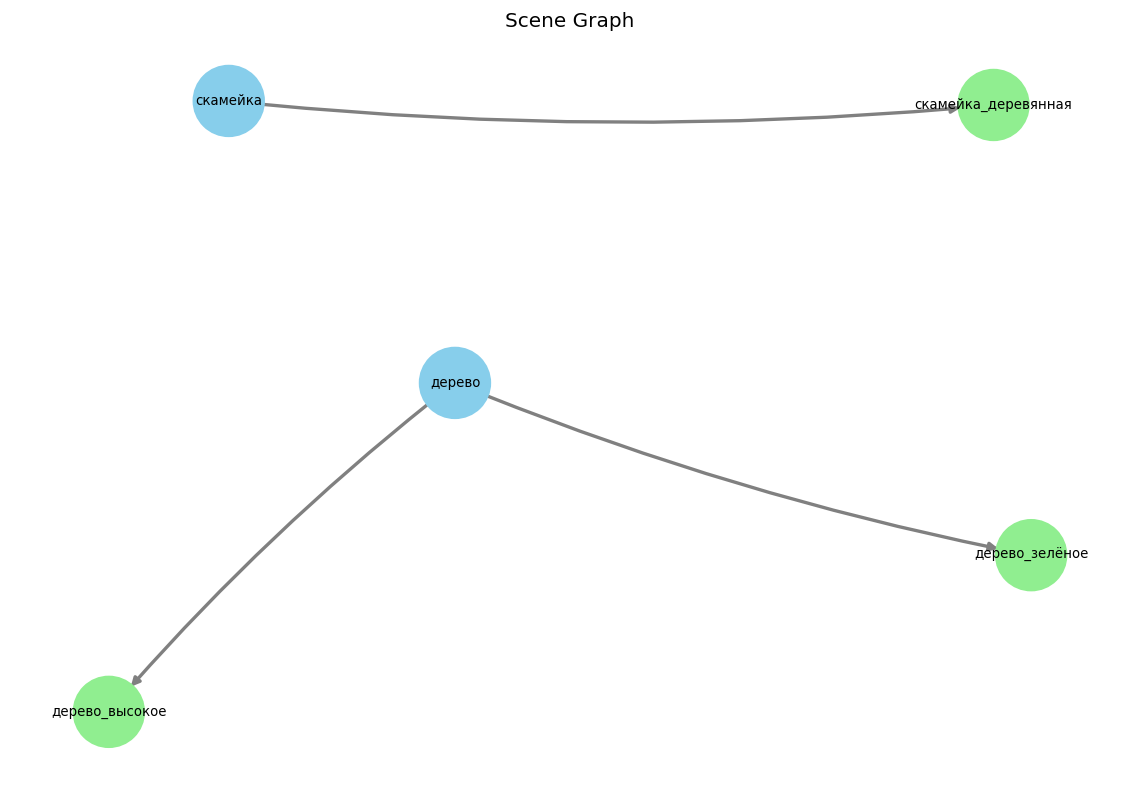


{"scene": {"location": "павильон", "objects": [{"стол": ["деревянный"]}, {"стул": ["деревянный"]}, {"лампа": ["яркая", "тяжёлая"]}], "relations": [["стул", "рядом с", "стол"], ["лампа", "над", "стол"]]}, "description": "Деревянный стул стоит рядом с деревянным столом, над которым висит яркая тяжелая лампа."}




{"scene": {"location": "павильон", "objects": [{"стол": ["деревянный"]}, {"стул": ["деревянный"]}, {"лампа": ["яркая", "тяжёлая"]}], "relations": [["стол", "рядом с", "лампа"], ["стул", "возле", "лампа"]]}, "description": "Деревянный стол стоит рядом с тяжелой яркой лампой, возле которой расположен деревянный стул."}




{"scene": {"location": "павильон", "objects": [{"стол": ["деревянный"]}, {"стул": ["деревянный"]}, {"лампа": ["яркая", "тяжёлая"]}], "relations": [["лампа", "над", "стол"], ["стул", "рядом с", "стол"]]}, "description": "Тяжелая яркая лампа висит над деревянным столом, рядом с которым стоит деревянный стул."}




{"scene": {"location": "сцена", "objects": [{"стул": ["деревянный"]}, {"сцена": ["большая", "прямоугольная", "тяжёлая"]}, {"микрофон": ["чёрный"]}], "relations": [["микрофон", "на", "сцена"], ["стул", "рядом с", "микрофон"]]}, "description": "Большая, тяжелая, прямоугольная сцена; на ней стоит черный микрофон, рядом с которым лежит деревянный стул."}



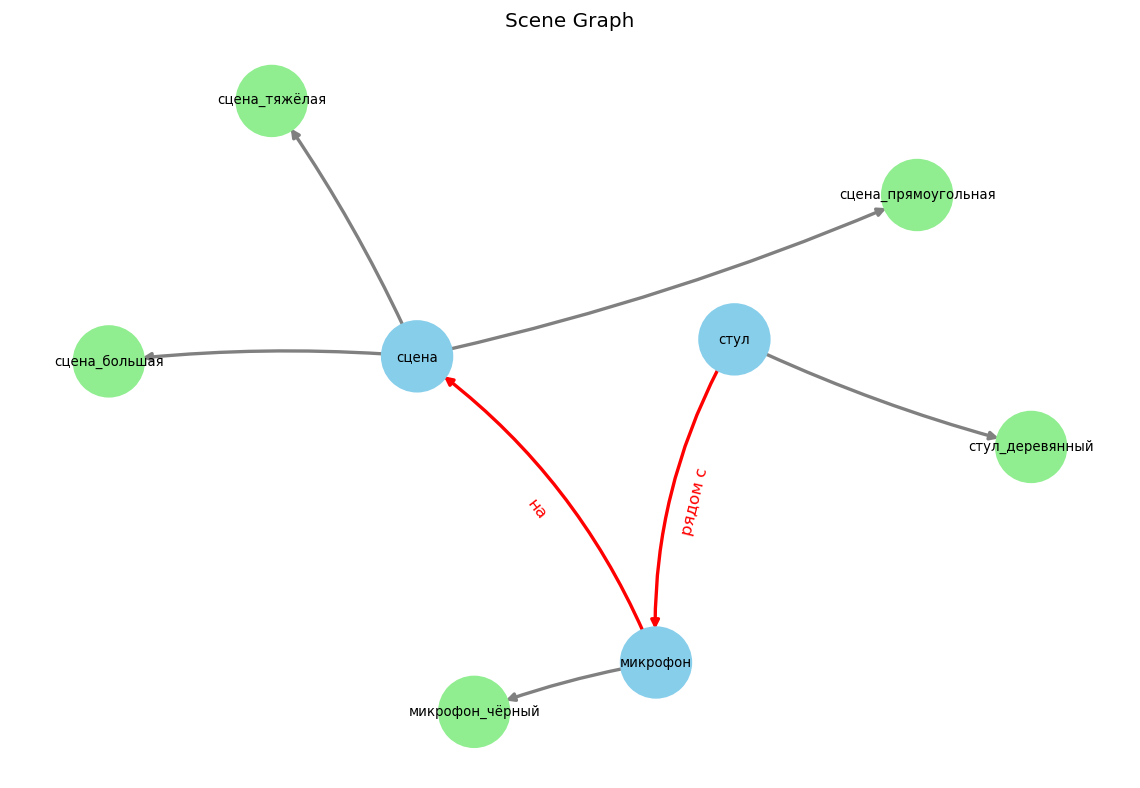


{"scene": {"location": "сцена", "objects": [{"стул": ["деревянный"]}, {"сцена": ["большая", "прямоугольная", "тяжёлая"]}, {"микрофон": ["чёрный"]}], "relations": [["микрофон", "рядом с", "стул"]]}, "description": "Черный микрофон стоит на большой прямоугольной тяжелой сцене рядом с деревянным стулом."}




{"scene": {"location": "сцена", "objects": [{"стул": ["деревянный"]}, {"сцена": ["большая", "прямоугольная", "тяжёлая"]}, {"микрофон": ["чёрный"]}], "relations": [["стул", "на", "сцена"], ["микрофон", "рядом с", "стул"]]}, "description": "Большая прямоугольная тяжелая сцена, на которой стоит деревянный стул, рядом с ним лежит черный микрофон."}




{"scene": {"location": "спальня", "objects": [{"кровать": []}, {"шкаф": ["большой"]}, {"лампа": ["яркая", "круглая", "тяжелая"]}], "relations": [["шкаф", "рядом с", "кровать"], ["лампа", "на", "кровать"]]}, "description": "Большой шкаф стоит рядом с кроватью, на которой лежит тяжелая круглая яркая лампа."}



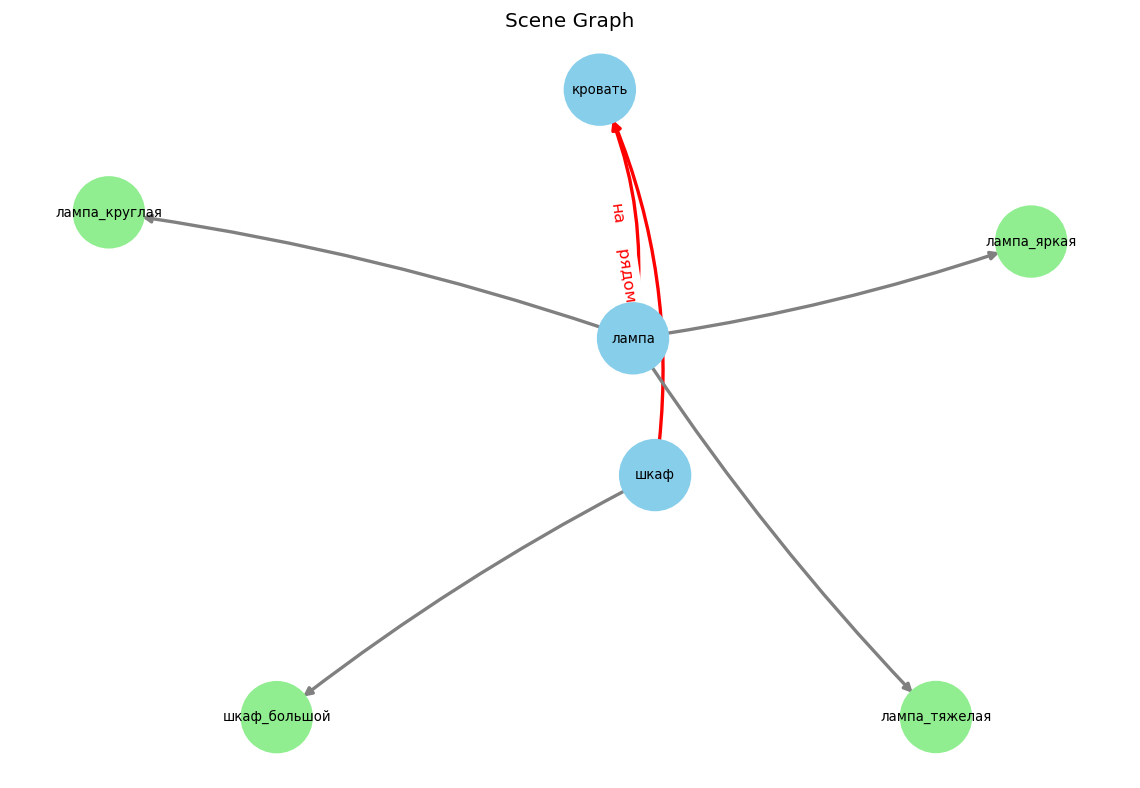


{"scene": {"location": "спальня", "objects": [{"кровать": []}, {"шкаф": ["большой"]}, {"лампа": ["яркая", "круглая", "тяжелая"]}], "relations": [["лампа", "над", "кровать"], ["шкаф", "рядом с", "кровать"]]}, "description": "Тяжелая, яркая, круглая лампа висит над кроватью, рядом с которой стоит большой шкаф."}



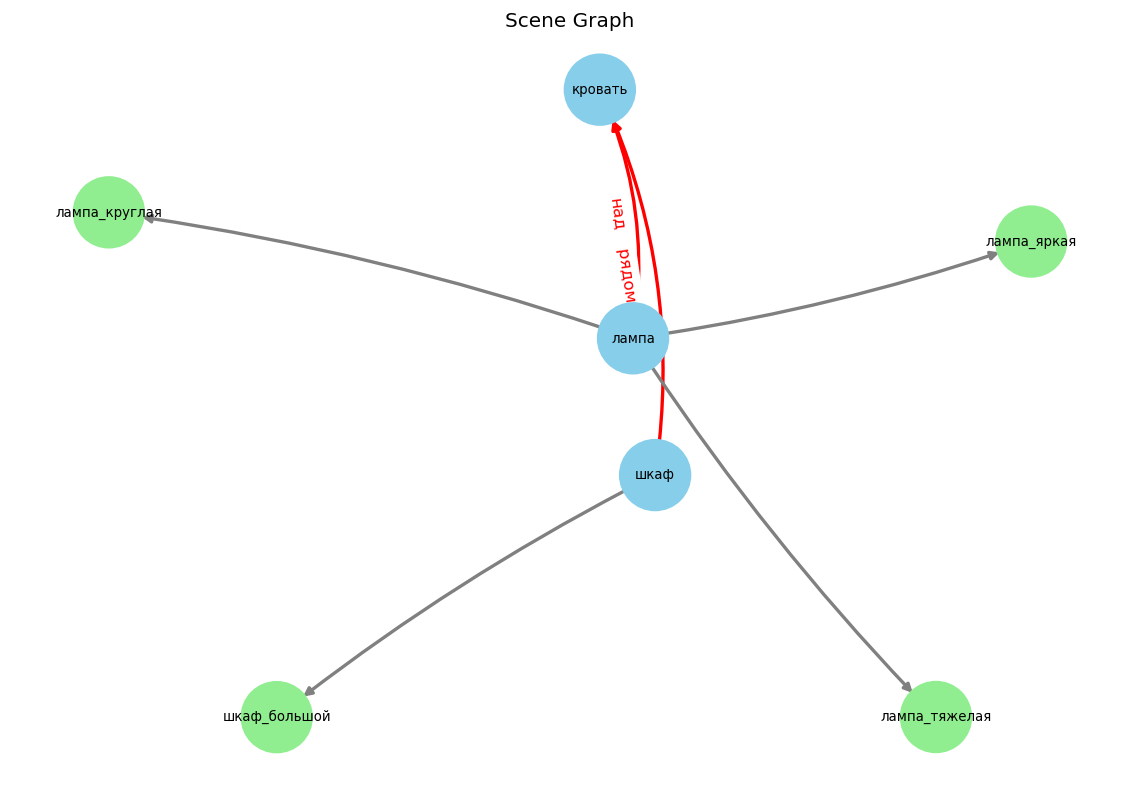


{"scene": {"location": "спальня", "objects": [{"кровать": []}, {"шкаф": ["большой"]}, {"лампа": ["яркая", "круглая", "тяжелая"]}], "relations": [["шкаф", "рядом с", "кровать"], ["лампа", "на", "кровать"]]}, "description": "Большой шкаф стоит рядом с кроватью, на которой лежит тяжелая, яркая, круглая лампа."}



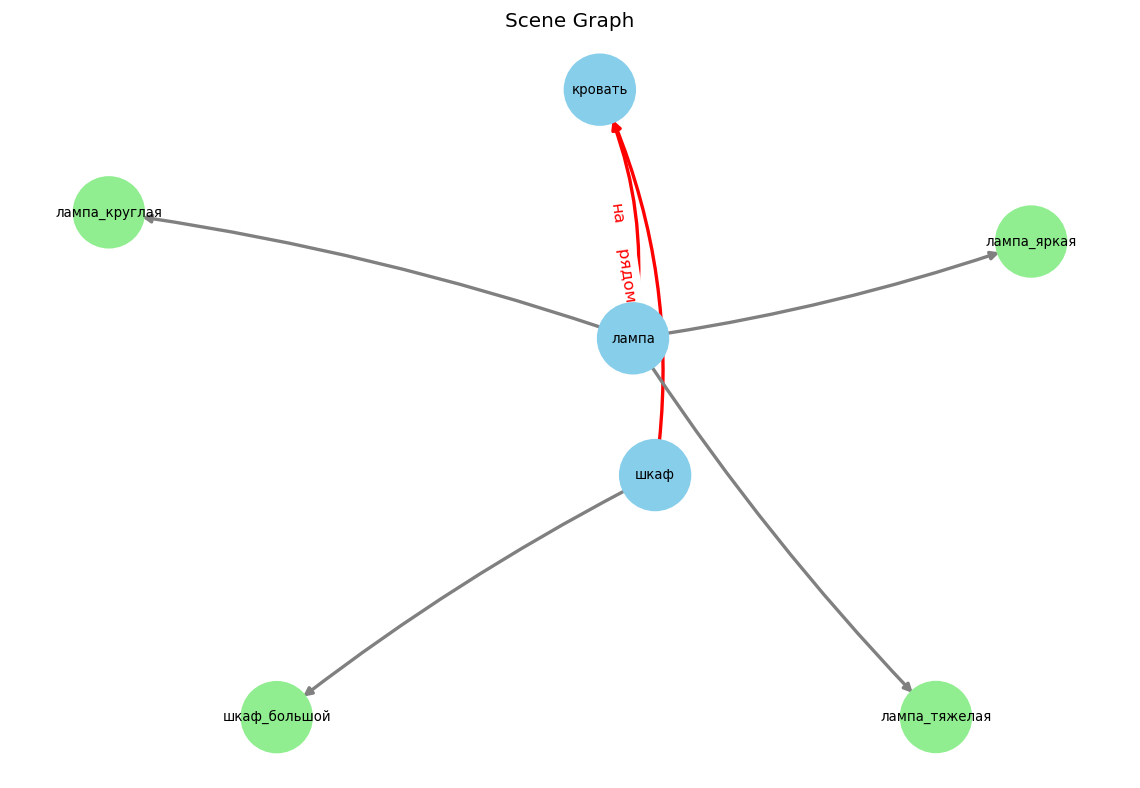


{"scene": {"location": "монастырь", "objects": [{"икона": []}, {"свеча": []}, {"книга": ["тяжелая"]}], "relations": [["икона", "над", "книга"], ["свеча", "рядом с", "книга"]]}, "description": "Икона висит над тяжелой книгой, рядом с которой стоит свеча."}



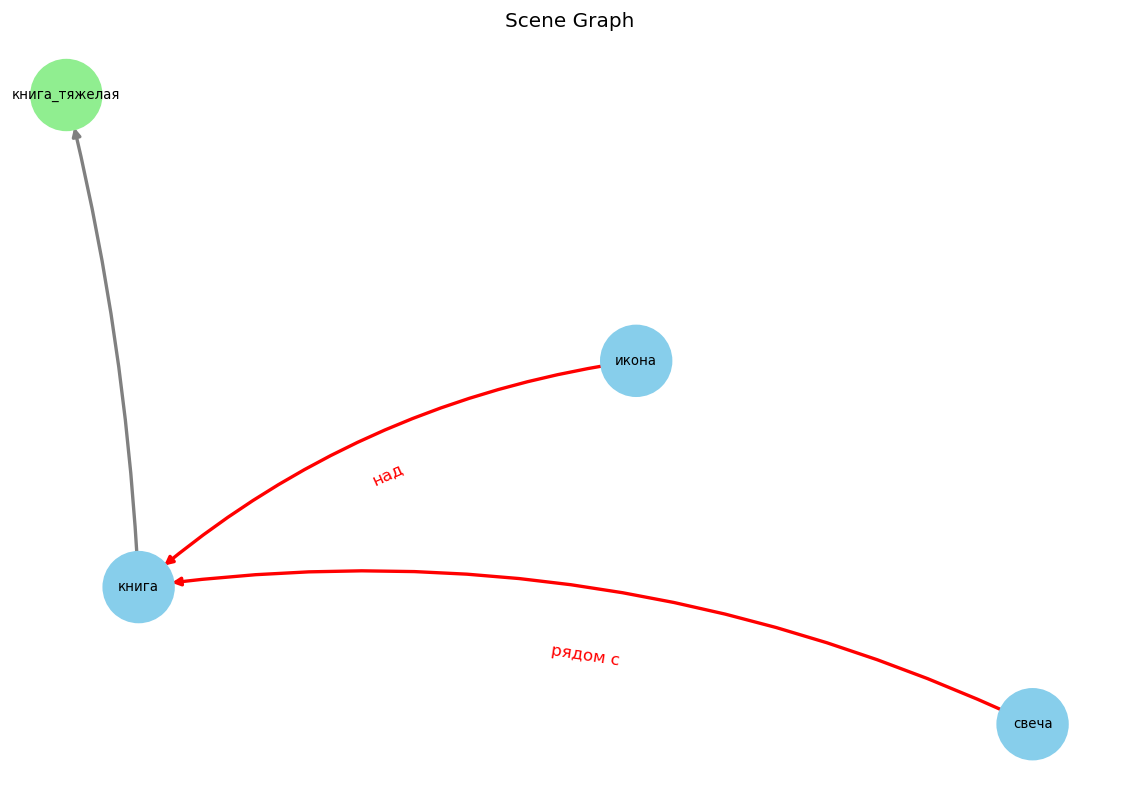


{"scene": {"location": "монастырь", "objects": [{"икона": []}, {"свеча": []}, {"книга": ["тяжелая"]}], "relations": [["свеча", "рядом с", "книга"], ["икона", "над", "книга"]]}, "description": "Свеча стоит рядом с тяжелой книгой, перед которой висит икона."}



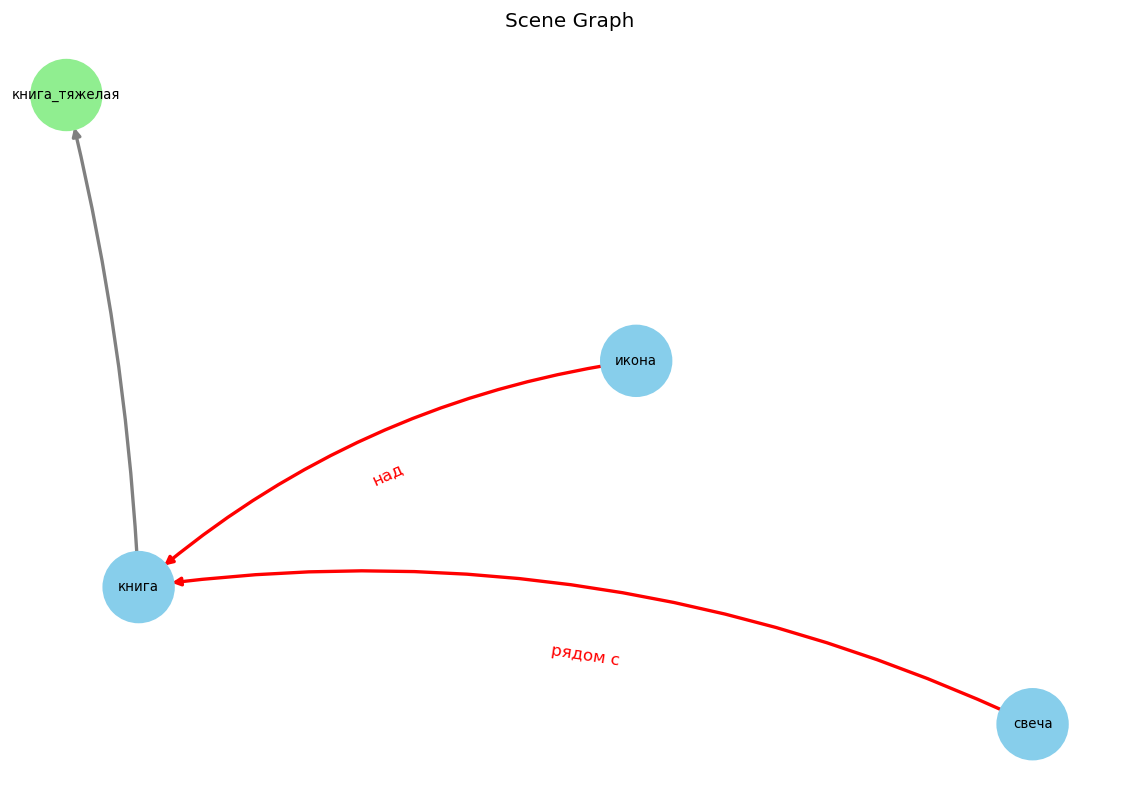


{"scene": {"location": "монастырь", "objects": [{"икона": []}, {"свеча": []}, {"книга": ["тяжелая"]}], "relations": [["свеча", "перед", "икона"], ["книга", "рядом с", "свеча"]]}, "description": "Свеча стоит перед иконой, рядом лежит тяжелая книга."}




{"scene": {"location": "тамбур", "objects": [{"вешалка": ["металлическая"]}, {"зонт": ["чёрный", "лёгкий"]}, {"чемодан": []}], "relations": [["зонт", "на", "вешалка"], ["чемодан", "рядом с", "вешалка"]]}, "description": "Металлическая вешалка держит легкий черный зонт, рядом стоит чемодан."}



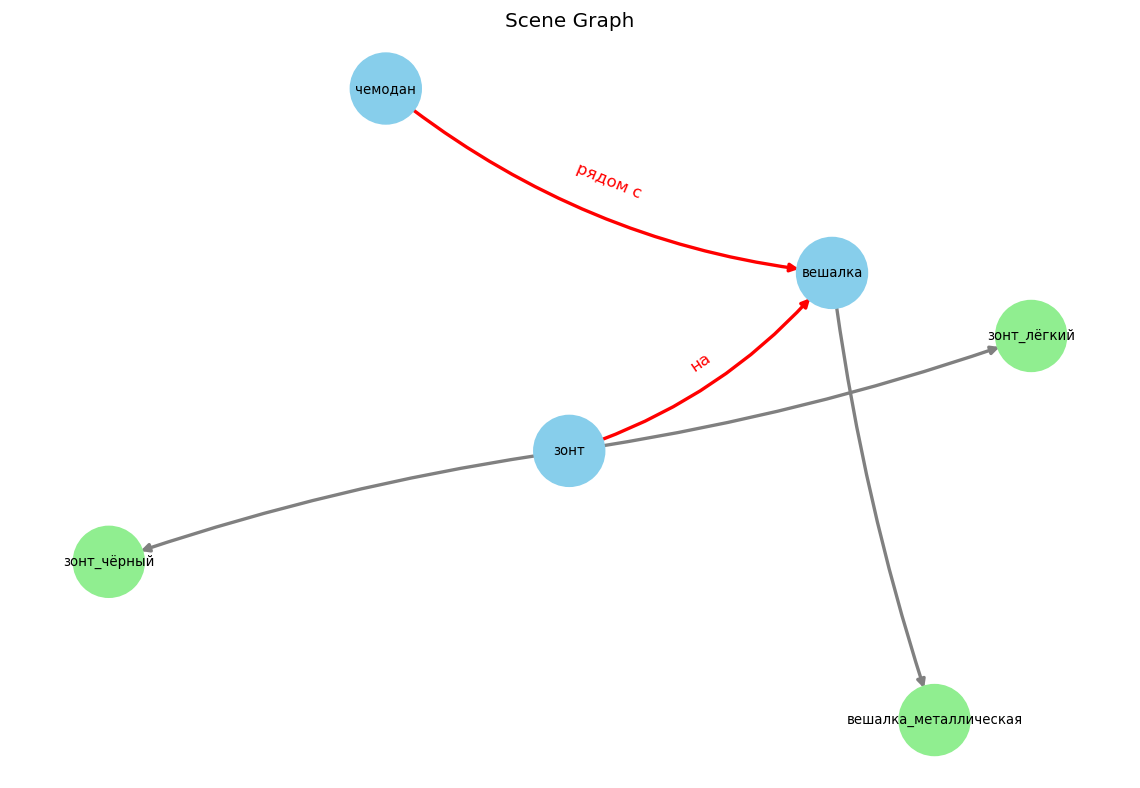


{"scene": {"location": "тамбур", "objects": [{"вешалка": ["металлическая"]}, {"зонт": ["чёрный", "лёгкий"]}, {"чемодан": []}], "relations": [["чемодан", "рядом с", "зонт"], ["зонт", "на", "вешалка"]]}, "description": "Чемодан стоит рядом с черным легким зонтом, висящим на металлической вешалке."}



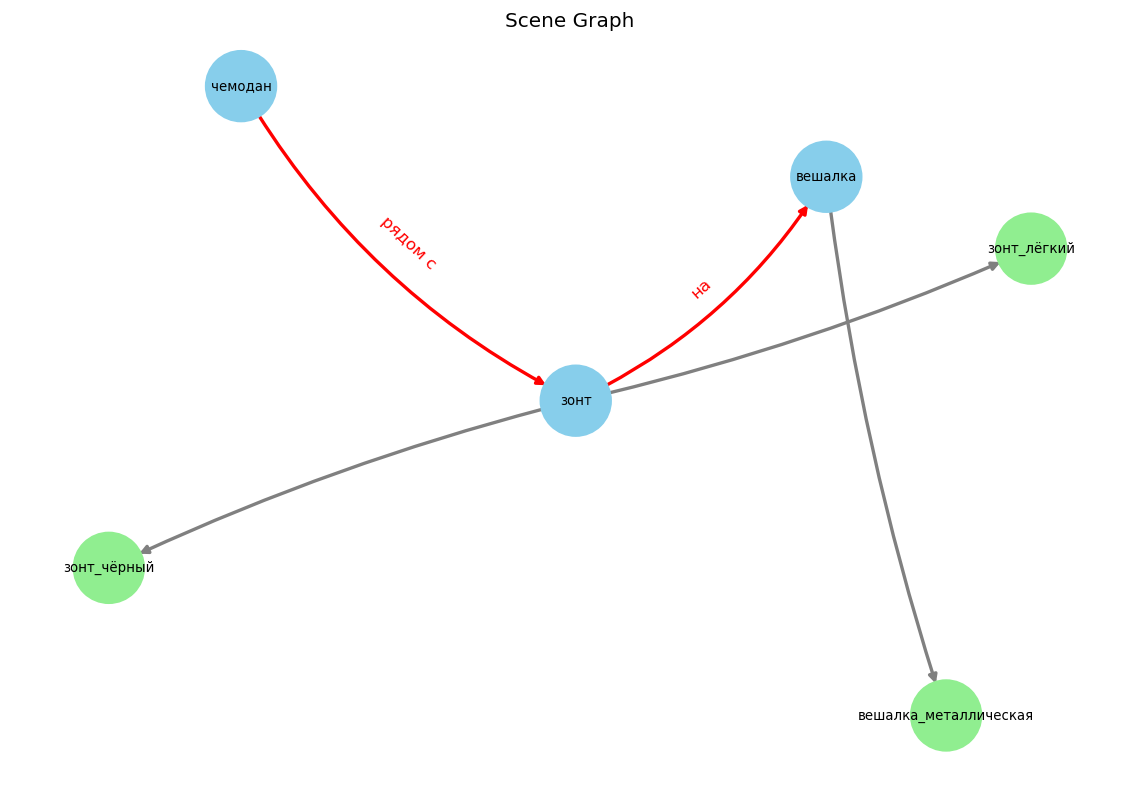


{"scene": {"location": "тамбур", "objects": [{"вешалка": ["металлическая"]}, {"зонт": ["чёрный", "лёгкий"]}, {"чемодан": []}], "relations": [["чемодан", "рядом с", "вешалка"], ["зонт", "на", "вешалка"]]}, "description": "Чемодан стоит рядом с металлической вешалкой, на которой висит черный легкий зонт."}



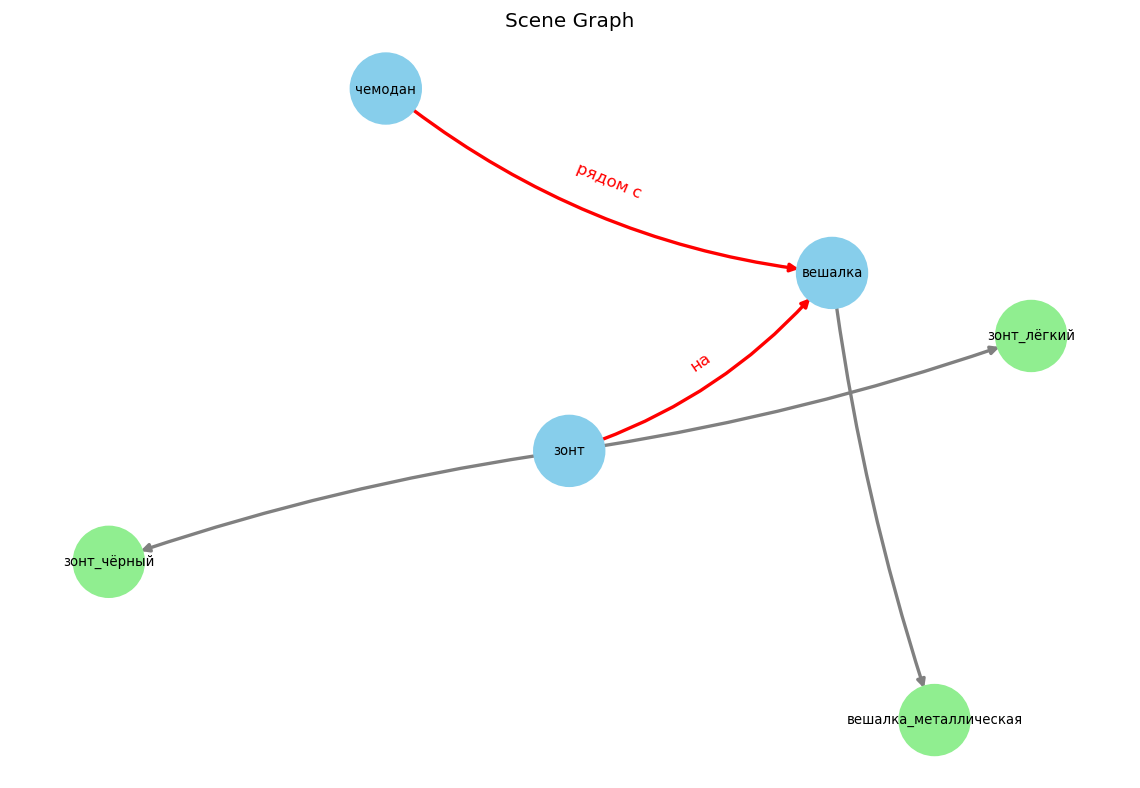


{"scene": {"location": "стадион", "objects": [{"мяч": ["круглый"]}, {"сетка": ["гибкая"]}], "relations": [["мяч", "рядом с", "сетка"]]}, "description": "Круглый мяч лежит рядом с гибкой сеткой."}



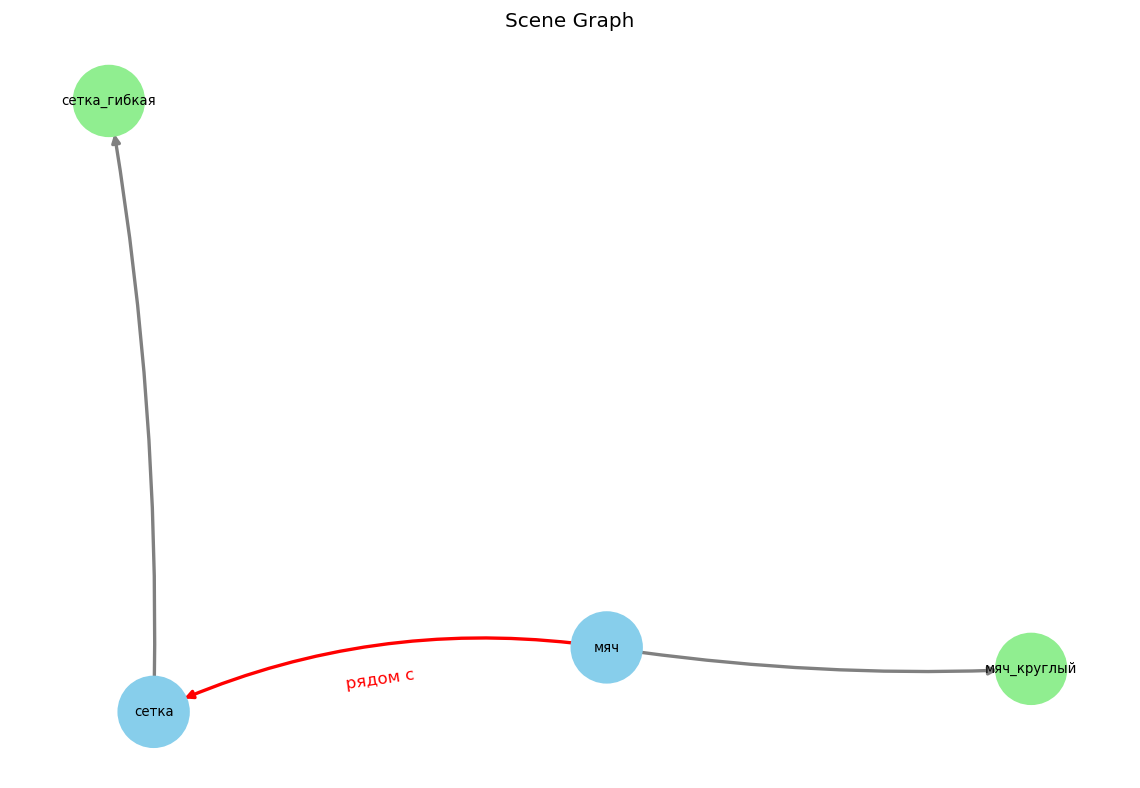


{"scene": {"location": "стадион", "objects": [{"мяч": ["круглый"]}, {"сетка": ["гибкая"]}], "relations": [["мяч", "перед", "сетка"]]}, "description": "Гибкая сетка натянута перед круглым мячом."}



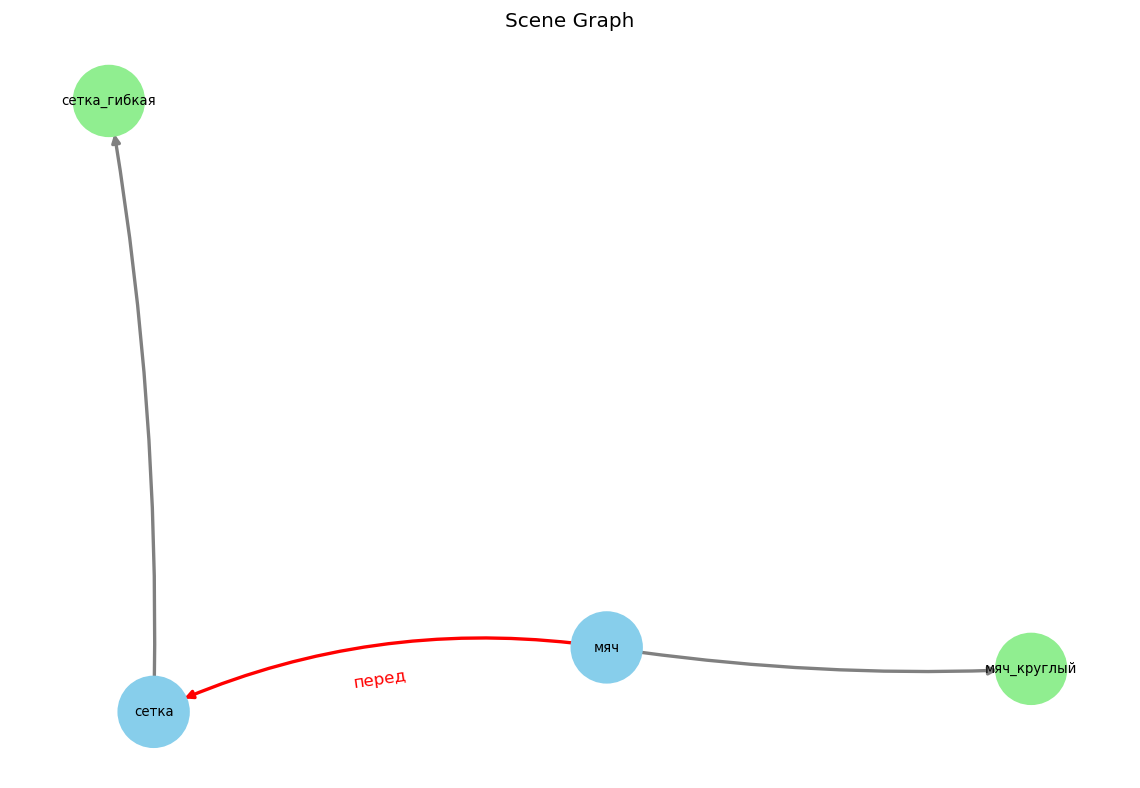


{"scene": {"location": "гардероб", "objects": [{"куртка": ["тёплая"]}, {"рюкзак": []}], "relations": [["куртка", "рядом с", "рюкзак"]]}, "description": "Теплая куртка висит рядом с рюкзаком."}



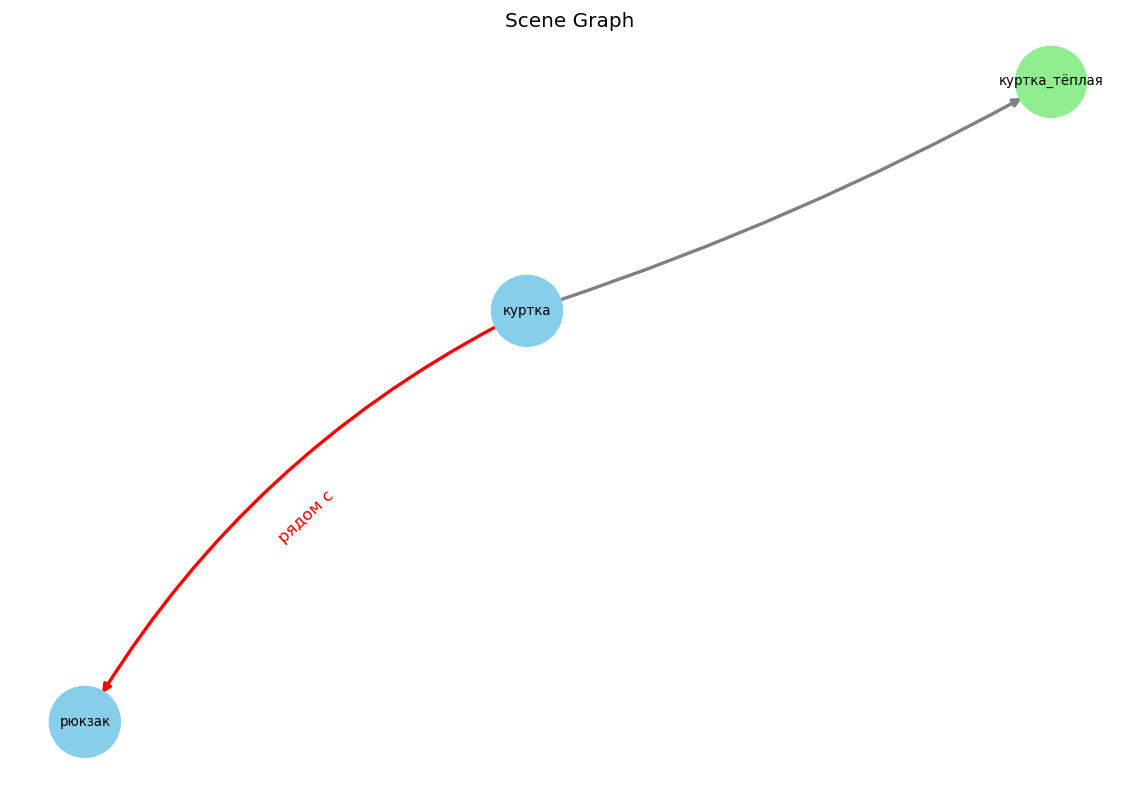


{"scene": {"location": "гардероб", "objects": [{"куртка": ["тёплая"]}, {"рюкзак": []}], "relations": [["рюкзак", "рядом с", "куртка"]]}, "description": "Рюкзак лежит рядом с теплой курткой."}



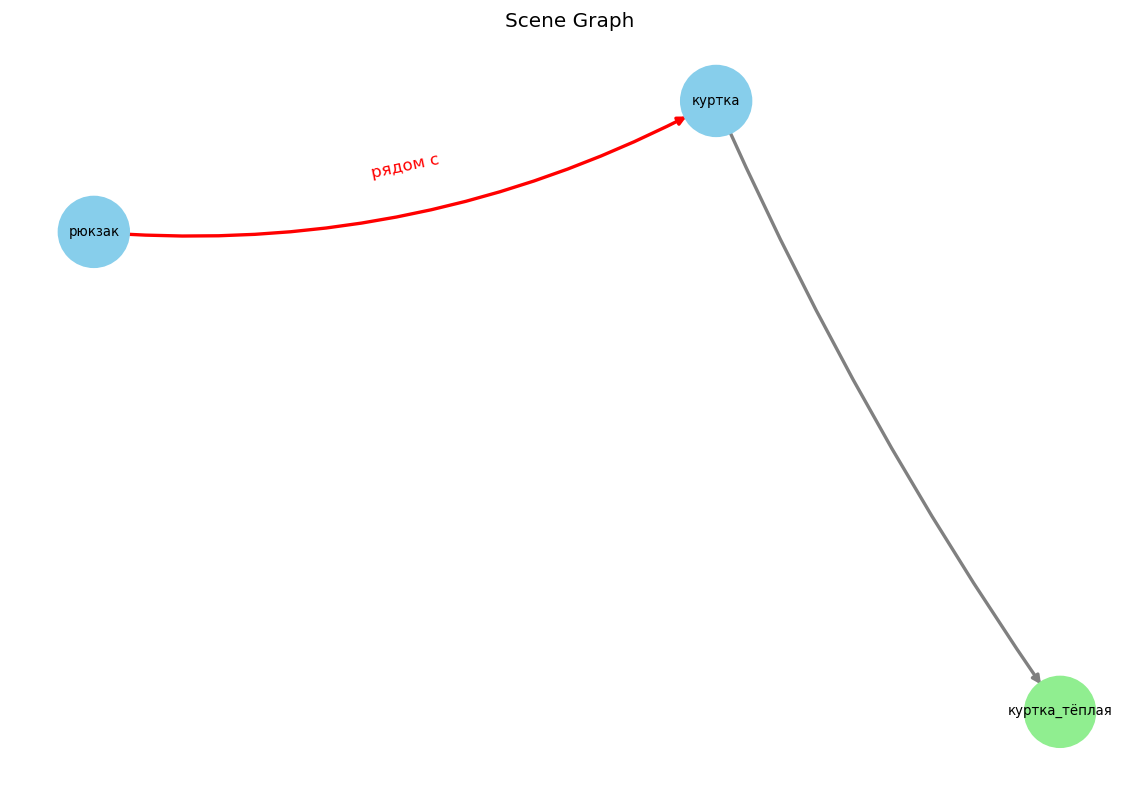


{"scene": {"location": "камера хранения", "objects": [{"чемодан": ["тяжелый"]}, {"рюкзак": ["большой"]}], "relations": [["чемодан", "рядом с", "рюкзак"]]}, "description": "Тяжелый чемодан стоит рядом с большим рюкзаком."}




{"scene": {"location": "камера хранения", "objects": [{"чемодан": ["тяжелый"]}, {"рюкзак": ["большой"]}], "relations": [["рюкзак", "рядом с", "чемодан"]]}, "description": "Большой рюкзак лежит рядом с тяжелым чемоданом."}



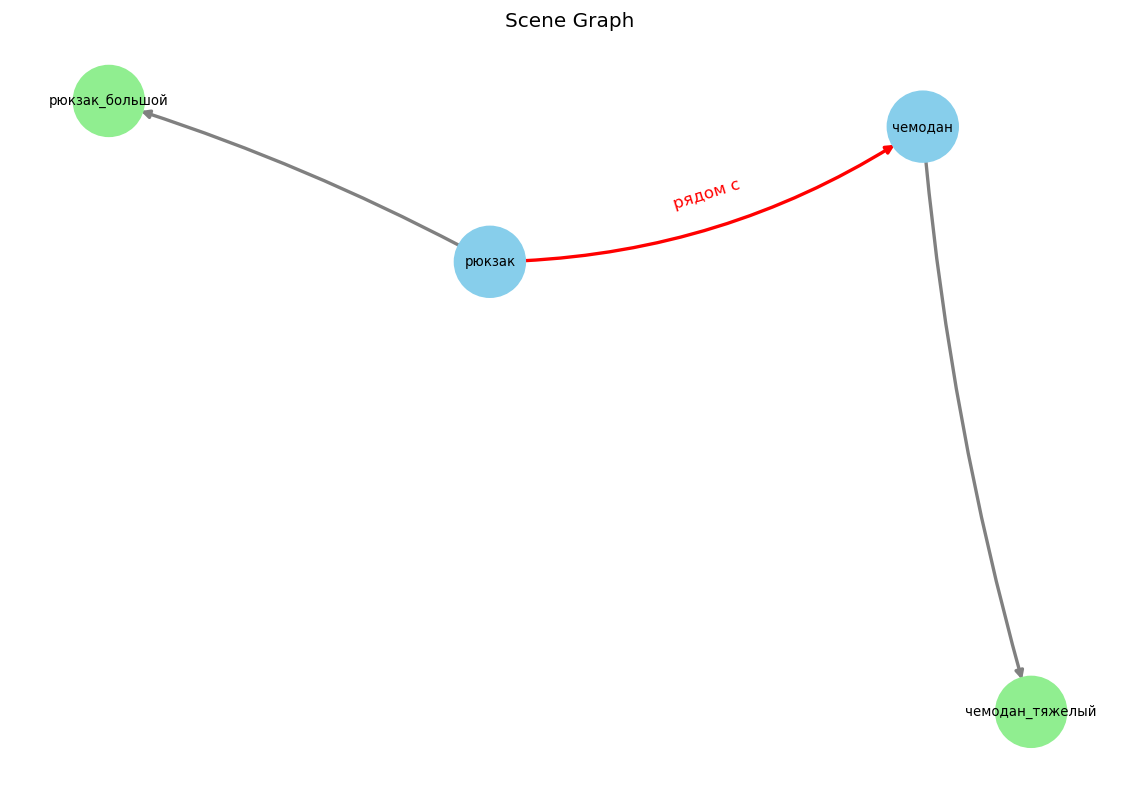


{"scene": {"location": "аэропорт", "objects": [{"чемодан": ["тяжелый", "квадратный", "черный"]}, {"билет": ["маленький", "прямоугольный", "бумажный"]}, {"телефон": ["маленький", "тяжелый"]}], "relations": [["телефон", "на", "чемодан"], ["билет", "рядом с", "чемодан"]]}, "description": "Маленький тяжелый телефон лежит на тяжелом черном квадратном чемодане, рядом с которым лежит бумажный прямоугольный маленький билет."}




{"scene": {"location": "аэропорт", "objects": [{"чемодан": ["тяжелый", "квадратный", "черный"]}, {"билет": ["маленький", "прямоугольный", "бумажный"]}, {"телефон": ["маленький", "тяжелый"]}], "relations": [["телефон", "на", "билет"], ["чемодан", "рядом с", "билет"]]}, "description": "Маленький тяжелый телефон лежит на маленьком прямоугольном бумажном билете, рядом стоит тяжелый черный квадратный чемодан."}




{"scene": {"location": "аэропорт", "objects": [{"чемодан": ["тяжелый", "квадратный", "черный"]}, {"билет": ["маленький", "прямоугольный", "бумажный"]}, {"телефон": ["маленький", "тяжелый"]}], "relations": [["телефон", "на", "чемодан"], ["билет", "рядом с", "чемодан"]]}, "description": "Тяжелый маленький телефон лежит на квадратном тяжелом черном чемодане, рядом с прямоугольным бумажным маленьким билетом."}




{"scene": {"location": "кладовка", "objects": [{"метла": []}, {"ведро": ["большое", "пластиковое", "тяжёлое"]}, {"тряпка": ["мягкая", "влажная", "чистая"]}], "relations": [["тряпка", "рядом с", "метла"], ["метла", "у", "ведро"]]}, "description": "Чистая, мягкая, влажная тряпка лежит рядом с метлой. Метла стоит у пластикового, тяжелого, большого ведра."}




{"scene": {"location": "кладовка", "objects": [{"метла": []}, {"ведро": ["большое", "пластиковое", "тяжёлое"]}, {"тряпка": ["мягкая", "влажная", "чистая"]}], "relations": [["тряпка", "на", "метла"], ["метла", "рядом с", "ведро"]]}, "description": "Тяжелое, большое, пластиковое ведро стоит рядом с метлой, на которой лежит влажная, мягкая, чистая тряпка."}




{"scene": {"location": "кладовка", "objects": [{"метла": []}, {"ведро": ["большое", "пластиковое", "тяжёлое"]}, {"тряпка": ["мягкая", "влажная", "чистая"]}], "relations": [["ведро", "рядом с", "тряпка"], ["метла", "далеко от", "тряпка"], ["метла", "далеко от", "ведро"]]}, "description": "Пластиковое тяжелое большое ведро стоит рядом с влажной мягкой чистой тряпкой, а чуть дальше лежит метла."}




{"scene": {"location": "автосервис", "objects": [{"гаечный ключ": ["металлический", "тяжёлый"]}, {"домкрат": ["металлический"]}, {"аккумулятор": ["тяжелый", "плоский"]}, {"шина": ["резиновая", "круглая"]}], "relations": [["гаечный ключ", "рядом с", "шина"], ["шина", "возле", "домкрат"], ["домкрат", "рядом с", "аккумулятор"]]}, "description": "Металлический тяжелый гаечный ключ лежит рядом с круглой резиновой шиной.  \n\nШина стоит возле металлического домкрата.  \n\nДомкрат расположен рядом с плоским тяжелым аккумулятором."}



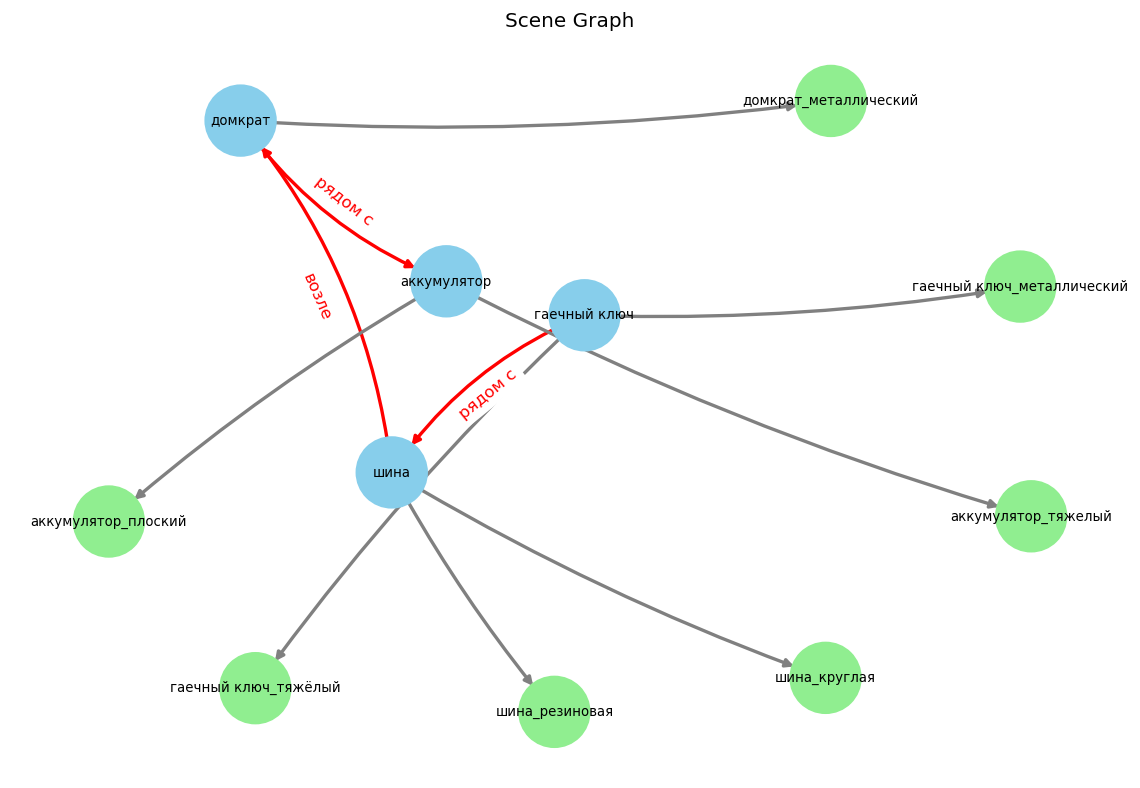


{"scene": {"location": "автосервис", "objects": [{"гаечный ключ": ["металлический", "тяжёлый"]}, {"домкрат": ["металлический"]}, {"аккумулятор": ["тяжелый", "плоский"]}, {"шина": ["резиновая", "круглая"]}], "relations": [["шина", "рядом с", "гаечный ключ"], ["аккумулятор", "возле", "домкрат"]]}, "description": "Круглая резиновая шина лежит рядом с тяжелым металлическим гаечным ключом. Плоский тяжелый аккумулятор стоит возле металлического домкрата."}



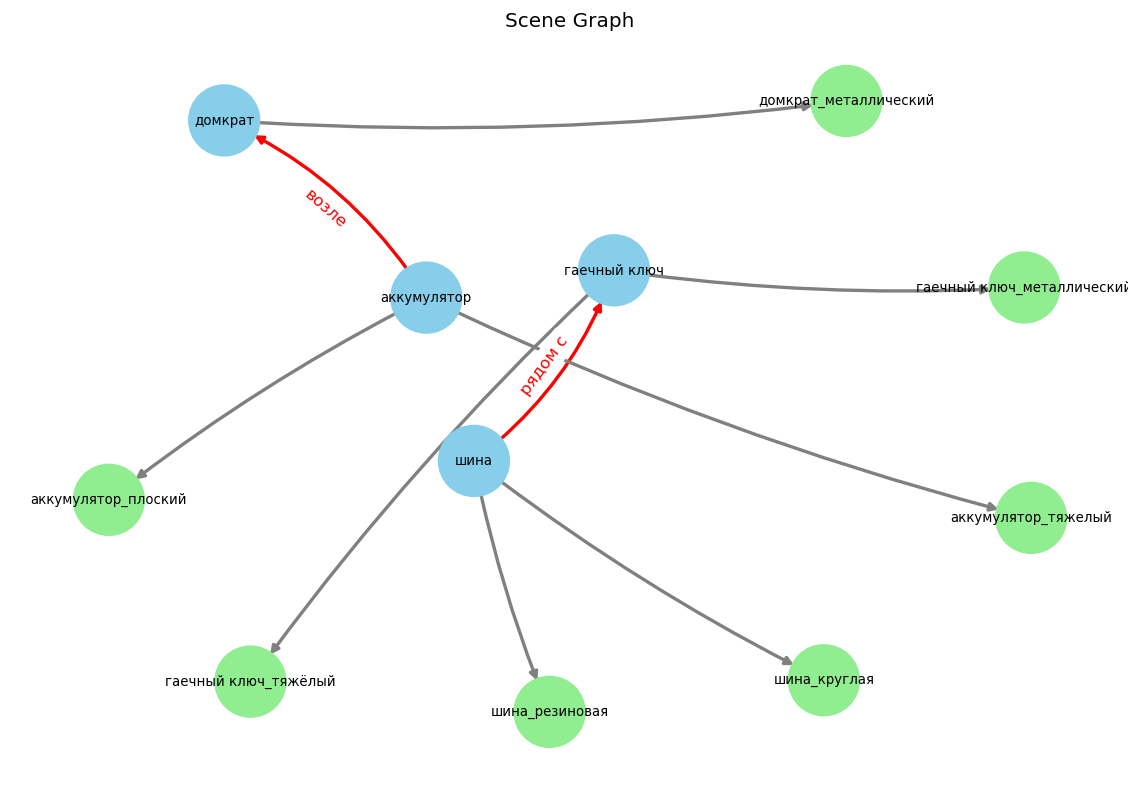


{"scene": {"location": "автосервис", "objects": [{"гаечный ключ": ["металлический", "тяжёлый"]}, {"домкрат": ["металлический"]}, {"аккумулятор": ["тяжелый", "плоский"]}, {"шина": ["резиновая", "круглая"]}], "relations": [["домкрат", "рядом с", "аккумулятор"], ["шина", "возле", "гаечный ключ"]]}, "description": "Металлический домкрат стоит рядом с плоским тяжелым аккумулятором.  \n\nКруглая резиновая шина лежит возле металлического тяжелого гаечного ключа."}




{"scene": {"location": "сарай", "objects": [{"лопата": ["металлическая"]}, {"грабли": []}, {"ведро": ["пластиковое"]}, {"топор": ["острый"]}], "relations": [["лопата", "рядом с", "грабли"], ["топор", "за", "грабли"], ["ведро", "перед", "топор"]]}, "description": "Металлическая лопата стоит рядом с граблями, за которыми лежит острый топор, а перед ним — пластиковое ведро."}




{"scene": {"location": "сарай", "objects": [{"лопата": ["металлическая"]}, {"грабли": []}, {"ведро": ["пластиковое"]}, {"топор": ["острый"]}], "relations": [["лопата", "прислонена к", "грабли"], ["топор", "рядом с", "ведро"]]}, "description": "Металлическая лопата прислонена к граблям, рядом лежит острый топор, а перед ним стоит пластиковое ведро."}



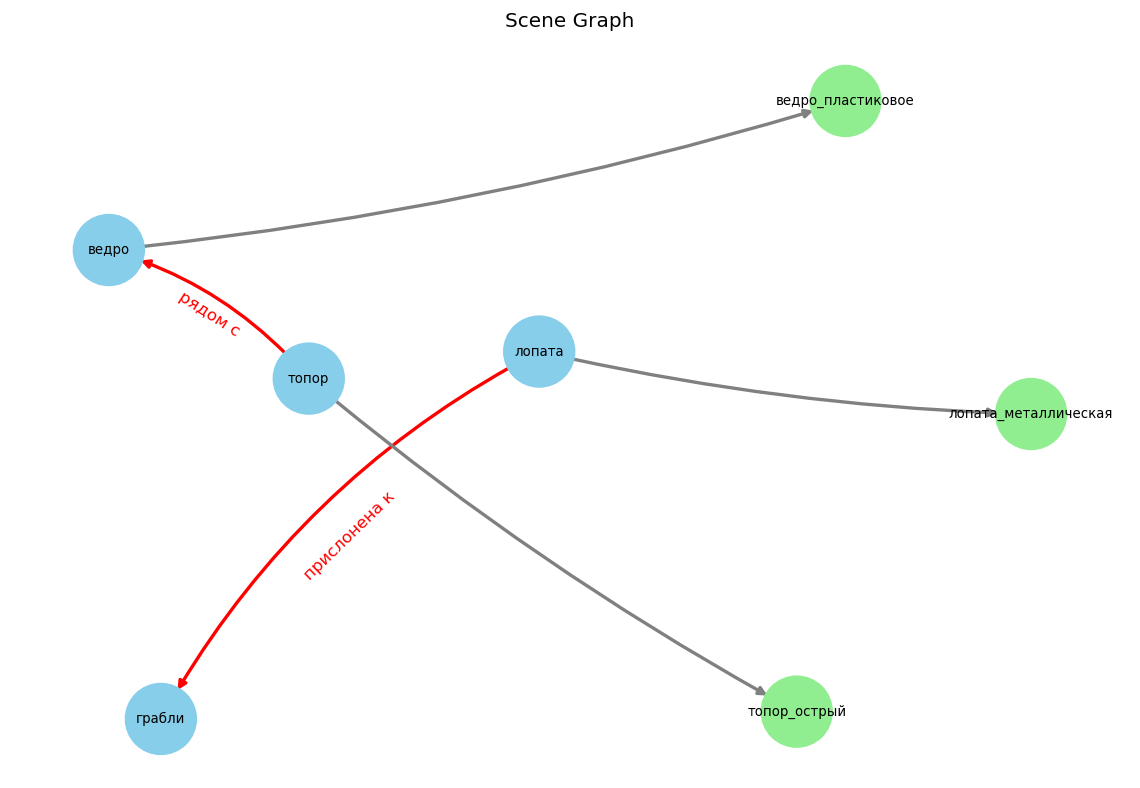


{"scene": {"location": "сарай", "objects": [{"лопата": ["металлическая"]}, {"грабли": []}, {"ведро": ["пластиковое"]}, {"топор": ["острый"]}], "relations": [["грабли", "рядом с", "топор"], ["топор", "на", "ведро"], ["лопата", "под", "ведро"]]}, "description": "Грабли прислонены рядом с острым топором, лежащим на пластиковом ведре, под которым стоит металлическая лопата."}



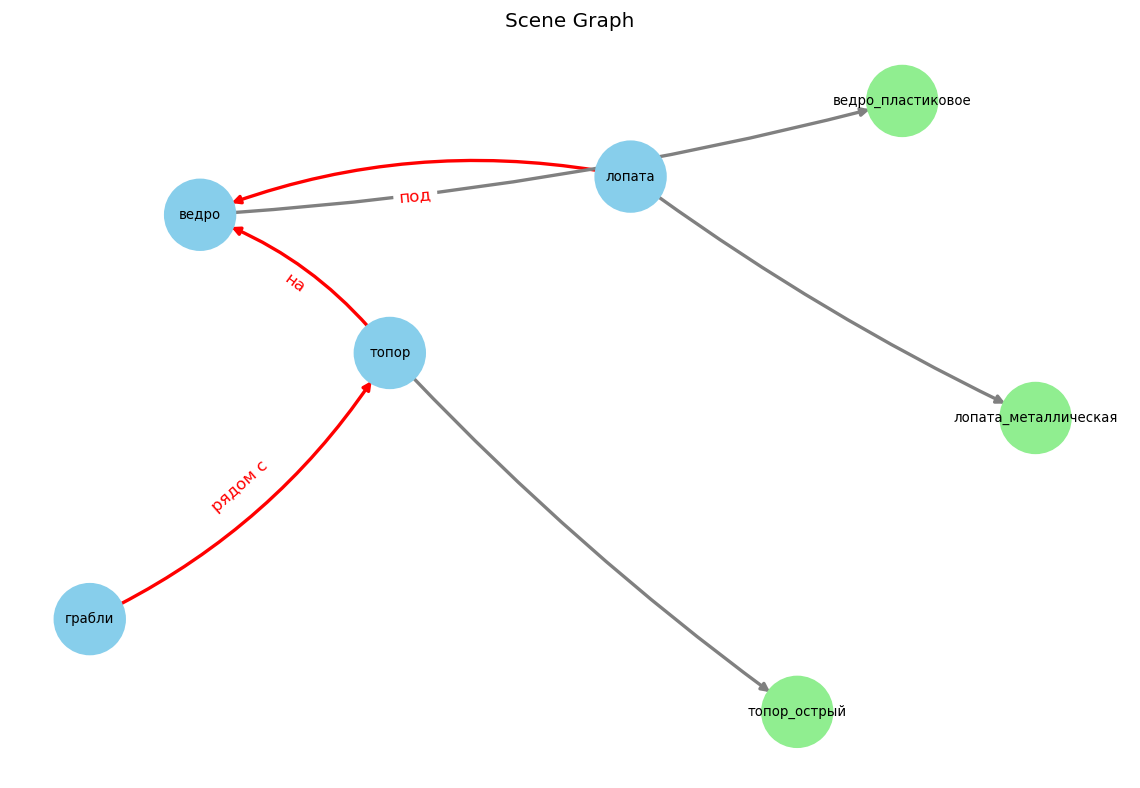


{"scene": {"location": "медпункт", "objects": [{"бинт": ["стерильный", "эластичный", "белый"]}, {"шприц": ["пластиковый"]}, {"тонометр": ["электронный"]}], "relations": [["бинт", "рядом с", "тонометр"], ["шприц", "возле", "тонометр"]]}, "description": "Стерильный эластичный белый бинт лежит рядом с электронным тонометром, возле которого стоит пластиковый шприц."}




{"scene": {"location": "медпункт", "objects": [{"бинт": ["стерильный", "эластичный", "белый"]}, {"шприц": ["пластиковый"]}, {"тонометр": ["электронный"]}], "relations": [["шприц", "рядом с", "тонометр"], ["бинт", "возле", "тонометр"]]}, "description": "Пластиковый шприц лежит рядом с электронным тонометром, возле которого лежит эластичный белый стерильный бинт."}




{"scene": {"location": "медпункт", "objects": [{"бинт": ["стерильный", "эластичный", "белый"]}, {"шприц": ["пластиковый"]}, {"тонометр": ["электронный"]}], "relations": [["шприц", "рядом с", "бинт"], ["тонометр", "возле", "бинт"]]}, "description": "Пластиковый шприц лежит рядом с белым эластичным стерильным бинтом.  \nЭлектронный тонометр расположен возле бинта."}



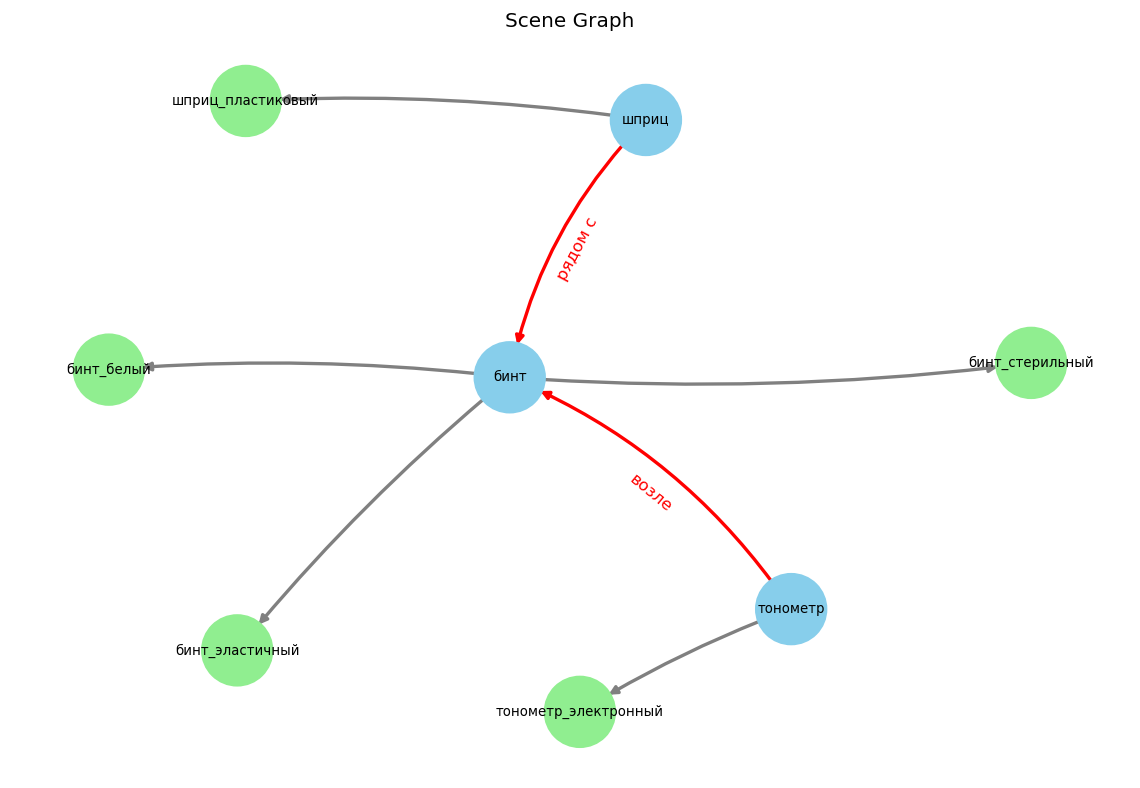


{"scene": {"location": "оранжерея", "objects": [{"горшок": ["глиняный"]}, {"лопата": ["металлическая", "острая"]}, {"лейка": ["пластиковая"]}], "relations": [["горшок", "рядом с", "лейка"], ["лейка", "за", "лопата"]]}, "description": "Глиняный горшок стоит рядом с пластиковой лейкой, за которой лежит острая металлическая лопата."}



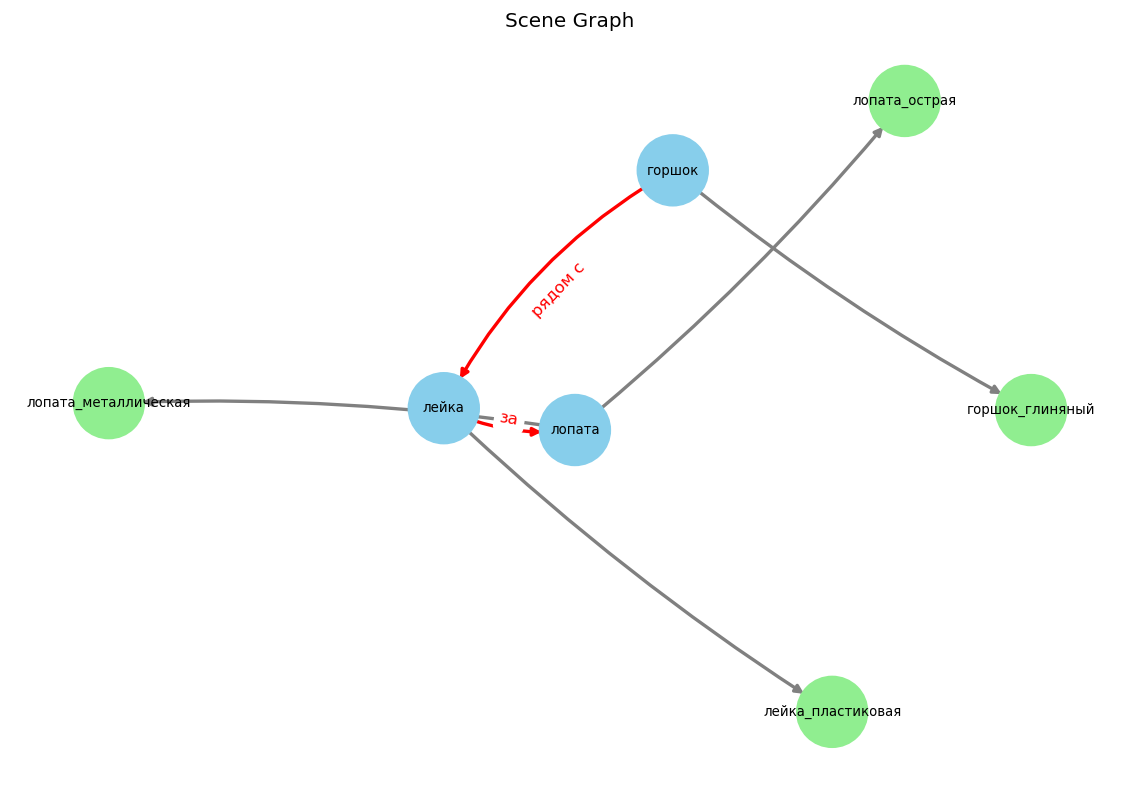


{"scene": {"location": "оранжерея", "objects": [{"горшок": ["глиняный"]}, {"лопата": ["металлическая", "острая"]}, {"лейка": ["пластиковая"]}], "relations": [["горшок", "рядом с", "лопата"], ["лопата", "за", "лейка"]]}, "description": "Глиняный горшок стоит рядом с металлической острой лопатой, за которой лежит пластиковая лейка."}



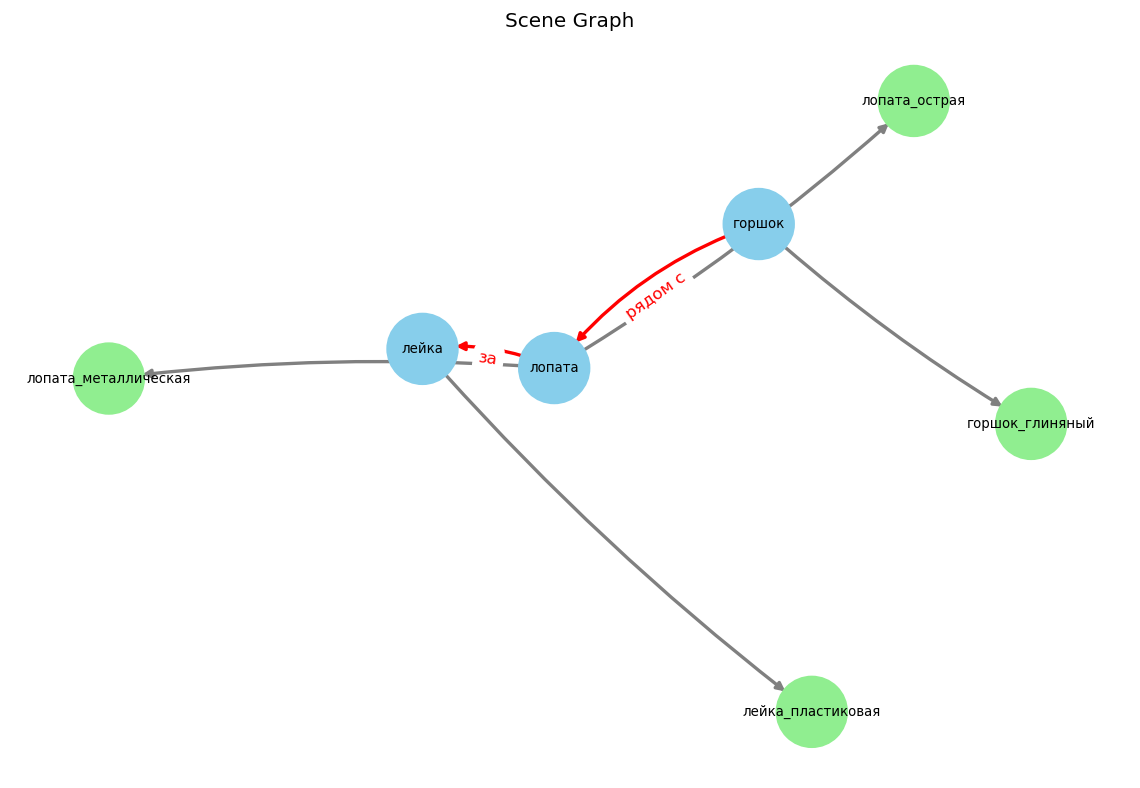


{"scene": {"location": "оранжерея", "objects": [{"горшок": ["глиняный"]}, {"лопата": ["металлическая", "острая"]}, {"лейка": ["пластиковая"]}], "relations": [["горшок", "рядом с", "лейка"], ["лейка", "за", "лопата"]]}, "description": "Глиняный горшок стоит рядом с пластиковой лейкой, за которой лежит металлическая острая лопата."}



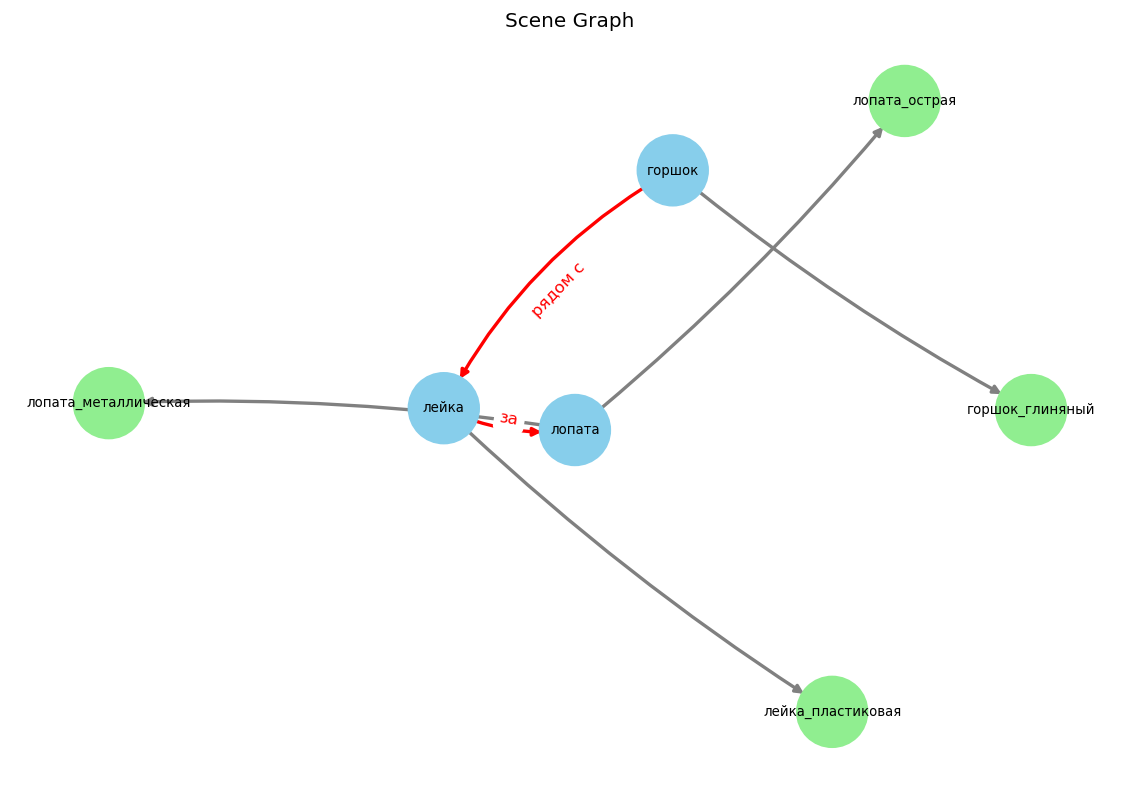


{"scene": {"location": "суд", "objects": [{"стол": ["круглый"]}, {"стул": ["деревянный"]}, {"документ": ["бумажный"]}], "relations": [["стул", "рядом с", "стол"], ["документ", "на", "стол"]]}, "description": "Деревянный стул стоит рядом с круглым столом, на котором лежит бумажный документ."}



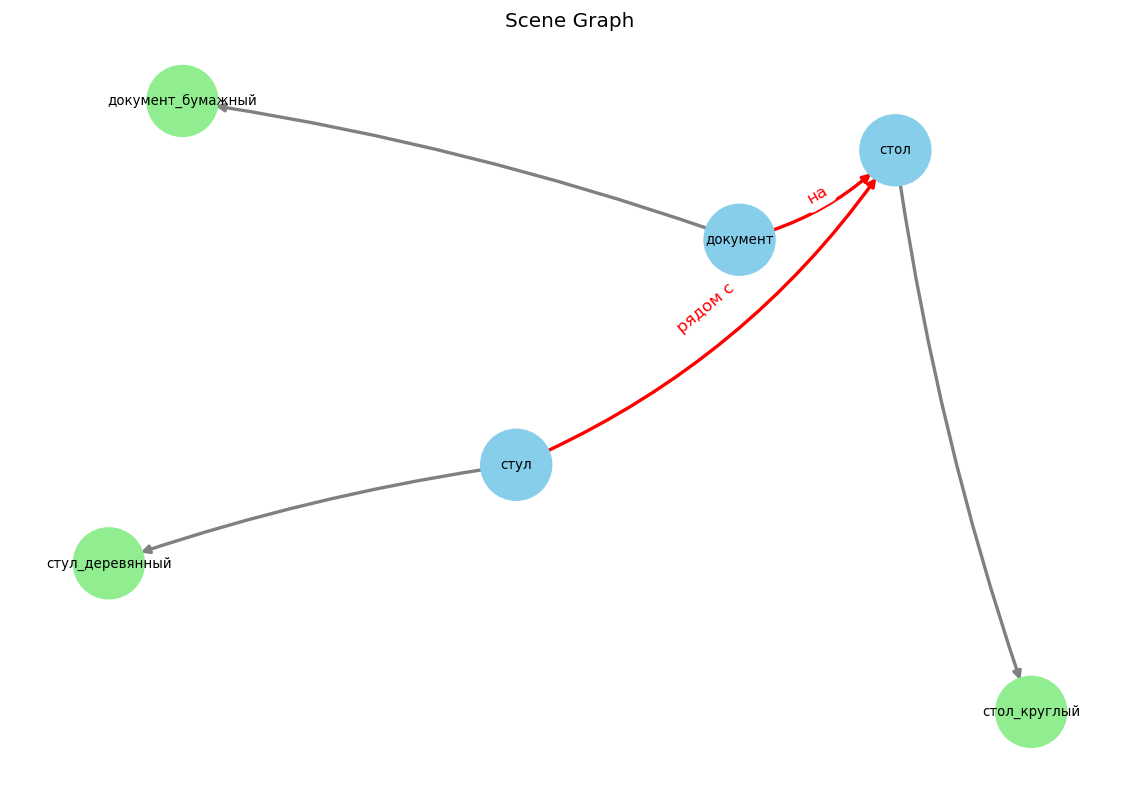


{"scene": {"location": "кабинет", "objects": [{"стол": []}, {"стул": ["деревянный"]}, {"лампа": ["яркая"]}], "relations": [["лампа", "над", "стол"], ["стул", "рядом с", "стол"]]}, "description": "Яркая лампа висит над столом, рядом с которым стоит деревянный стул."}




{"scene": {"location": "кабинет", "objects": [{"стол": []}, {"стул": ["деревянный"]}, {"лампа": ["яркая"]}], "relations": [["лампа", "над", "стул"], ["стул", "рядом с", "стол"]]}, "description": "Яркая лампа висит над деревянным стулом, стоящим рядом со столом."}



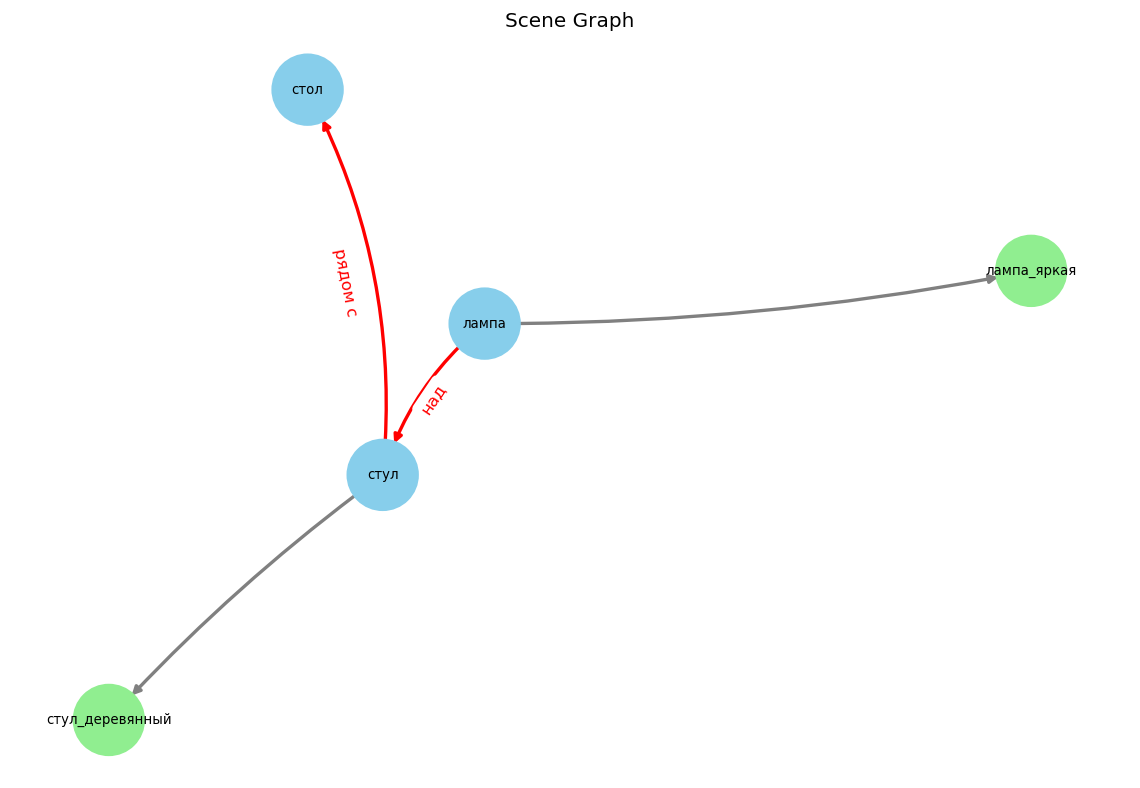


{"scene": {"location": "кабинет", "objects": [{"стол": []}, {"стул": ["деревянный"]}, {"лампа": ["яркая"]}], "relations": [["стул", "рядом с", "стол"], ["лампа", "на", "стол"]]}, "description": "Деревянный стул стоит рядом со столом, на котором лежит яркая лампа."}




{"scene": {"location": "гостиная", "objects": [{"диван": ["мягкий"]}, {"телевизор": ["большой"]}, {"лампа": ["яркая"]}, {"книга": ["тяжелая", "красная"]}], "relations": [["книга", "рядом с", "диван"], ["лампа", "слева от", "диван"]]}, "description": "Большой телевизор стоит напротив мягкого дивана, рядом с которым лежит тяжелая красная книга. Яркая лампа расположена слева от дивана."}



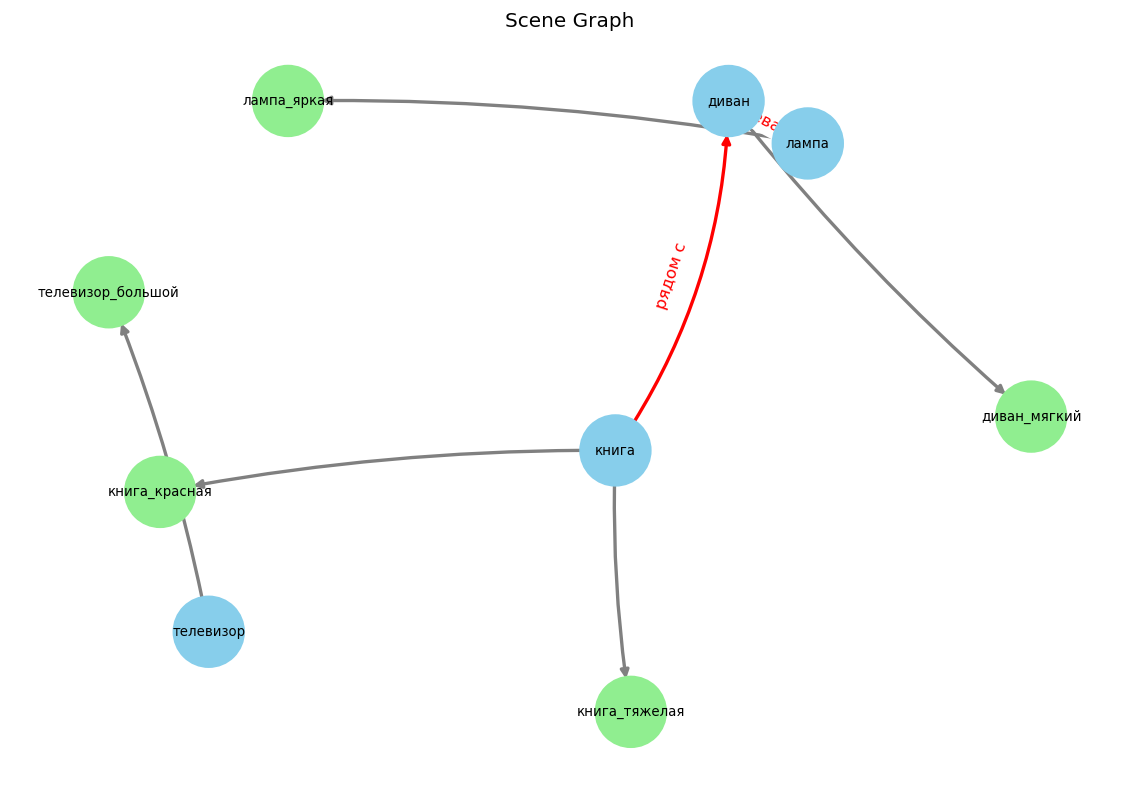


{"scene": {"location": "гостиная", "objects": [{"диван": ["мягкий"]}, {"телевизор": ["большой"]}, {"лампа": ["яркая"]}, {"книга": ["тяжелая", "красная"]}], "relations": [["книга", "на", "диван"], ["лампа", "рядом с", "диван"]]}, "description": "Большой телевизор стоит напротив мягкого дивана, на котором лежит тяжелая красная книга. Рядом с диваном расположена яркая лампа."}



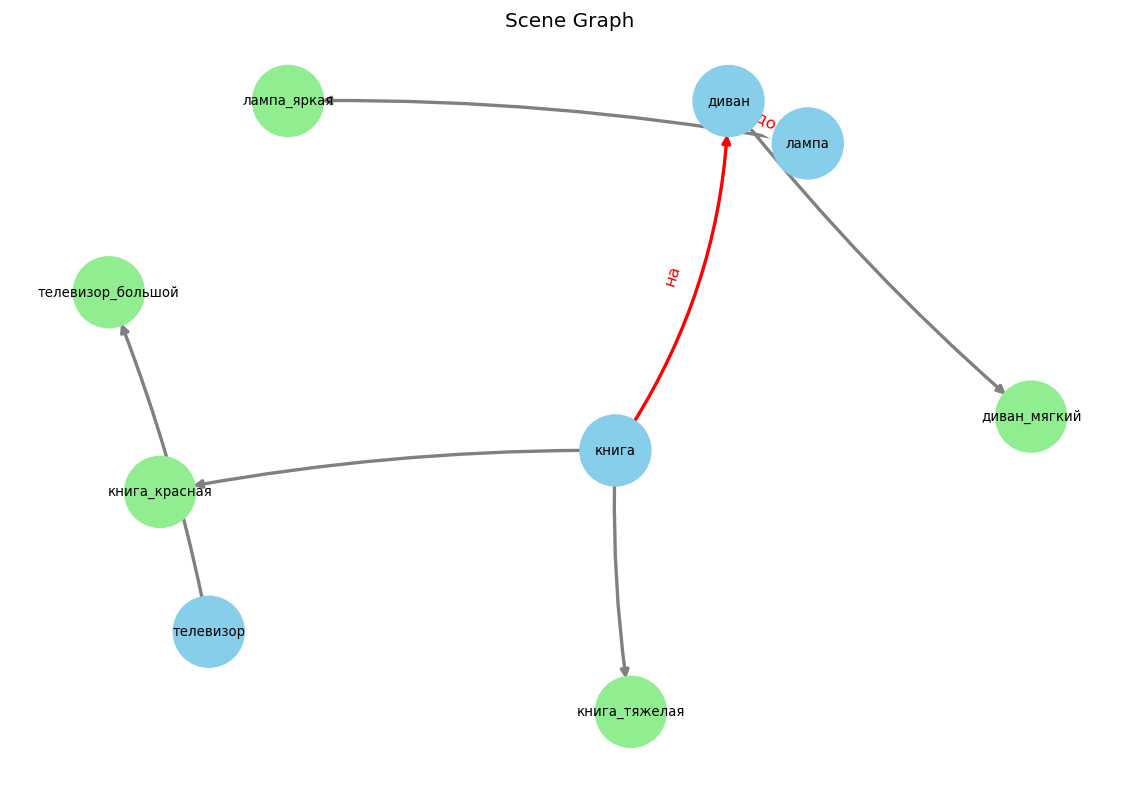


{"scene": {"location": "гостиная", "objects": [{"диван": ["мягкий"]}, {"телевизор": ["большой"]}, {"лампа": ["яркая"]}, {"книга": ["тяжелая", "красная"]}], "relations": [["книга", "на", "диван"], ["книга", "рядом с", "лампа"], ["лампа", "перед", "телевизор"]]}, "description": "Красная тяжелая книга лежит на мягком диване рядом с яркой лампой, перед большим телевизором."}



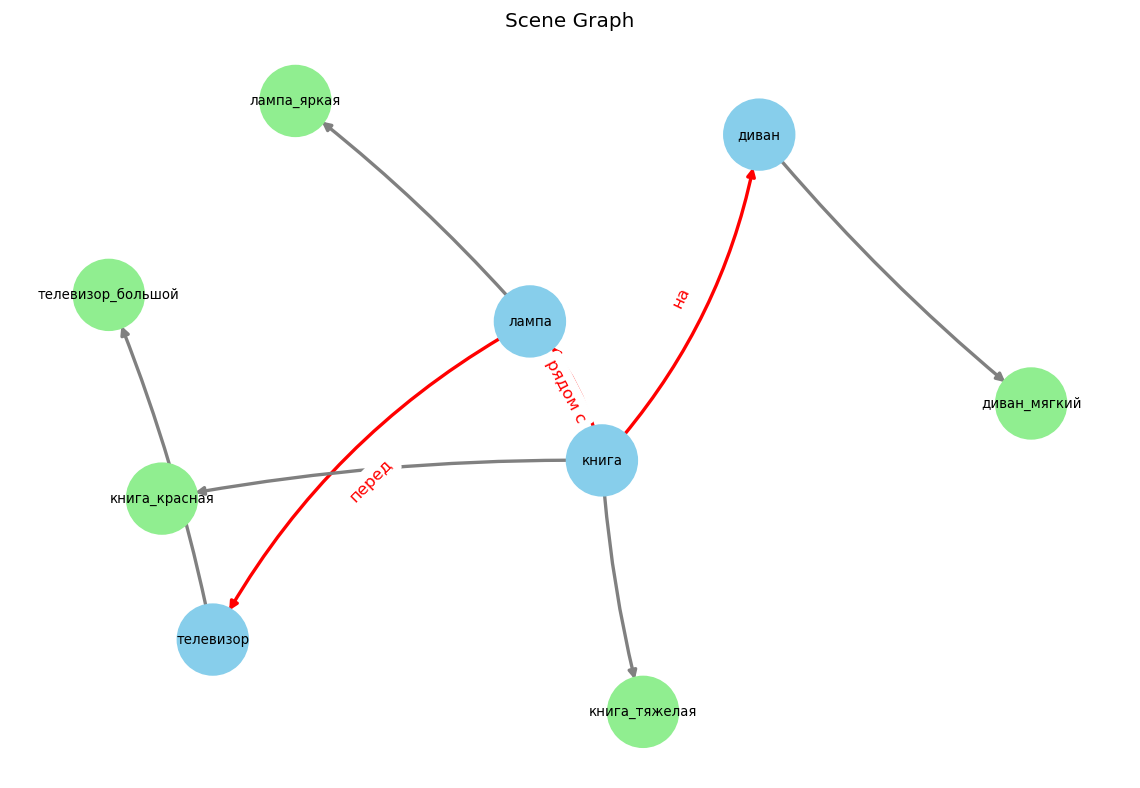


{"scene": {"location": "гардероб", "objects": [{"куртка": ["тёплая"]}, {"шапка": ["тёплая", "мягкая", "круглая"]}], "relations": [["шапка", "рядом с", "куртка"]]}, "description": "Мягкая, теплая, круглая шапка лежит рядом с теплой курткой."}



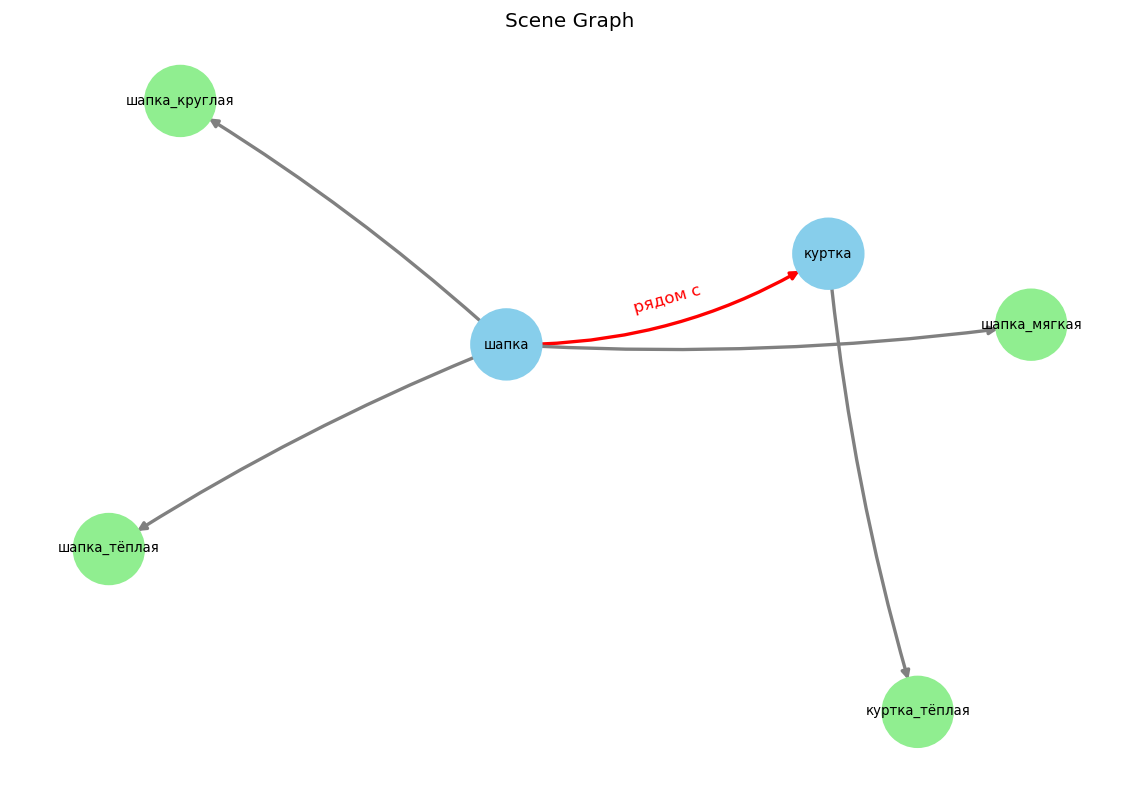


{"scene": {"location": "гардероб", "objects": [{"куртка": ["тёплая"]}, {"шапка": ["тёплая", "мягкая", "круглая"]}], "relations": [["куртка", "рядом с", "шапка"]]}, "description": "Теплая куртка лежит рядом с теплой круглой мягкой шапкой."}



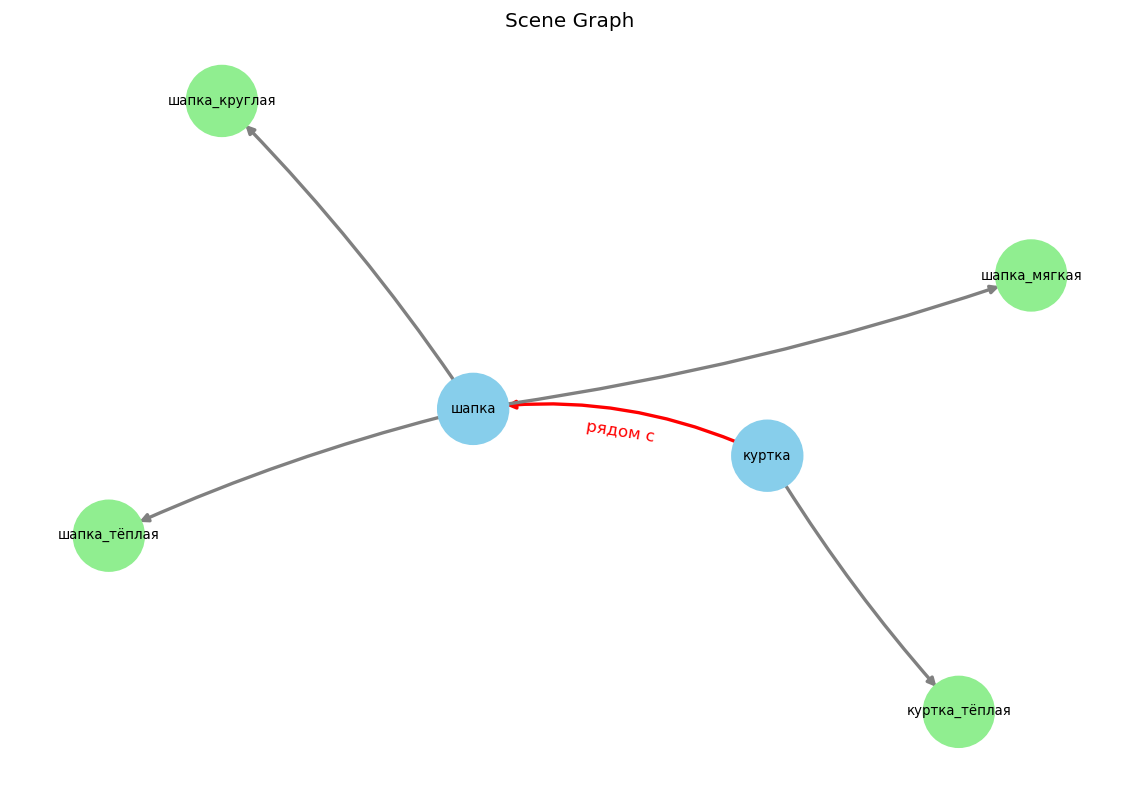


{"scene": {"location": "гардероб", "objects": [{"куртка": ["тёплая"]}, {"шапка": ["тёплая", "мягкая", "круглая"]}], "relations": [["куртка", "рядом с", "шапка"]]}, "description": "Теплая куртка лежит рядом с мягкой, теплой, круглой шапкой."}



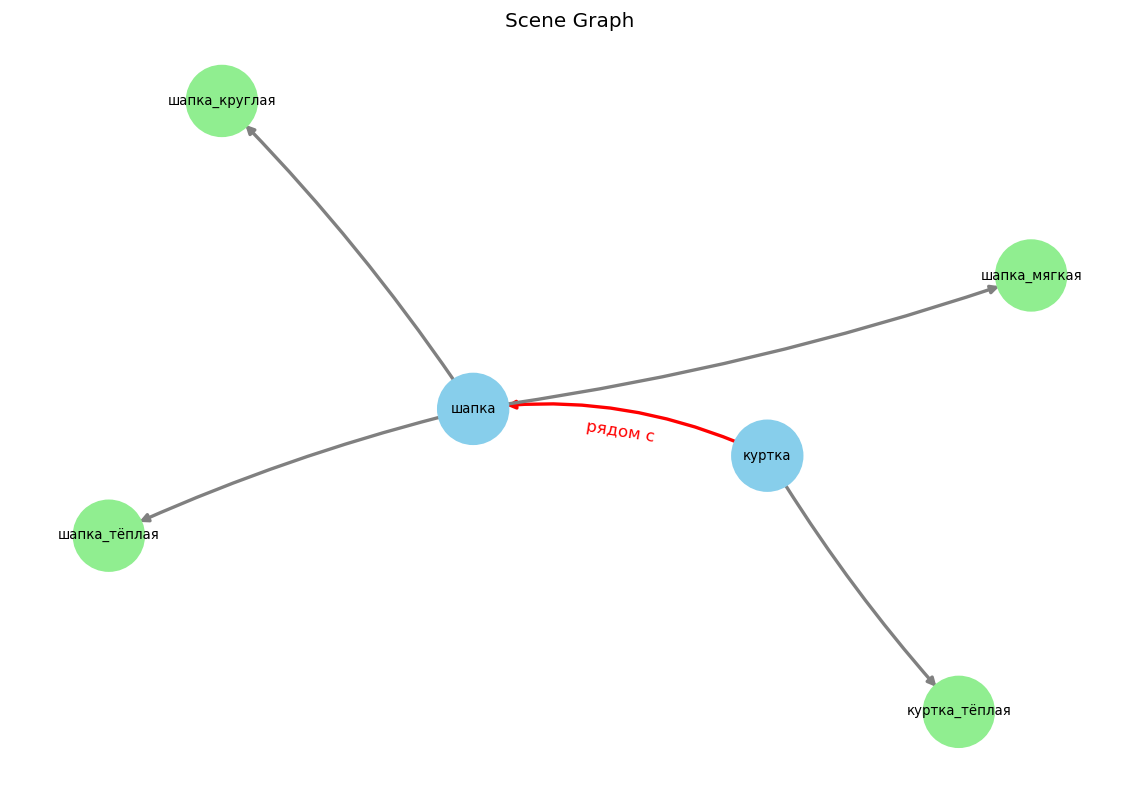


{"scene": {"location": "стадион", "objects": [{"мяч": ["круглый", "резиновый"]}, {"трибуна": ["высокая", "деревянная"]}, {"ворота": ["высокие", "широкие", "тяжёлые"]}, {"свисток": ["металлический", "легкий"]}], "relations": [["свисток", "перед", "трибуна"], ["мяч", "рядом с", "ворота"]]}, "description": "Легкий металлический свисток лежит перед высокой деревянной трибуной. За ней стоят тяжелые широкие высокие ворота, рядом с которыми лежит круглый резиновый мяч."}



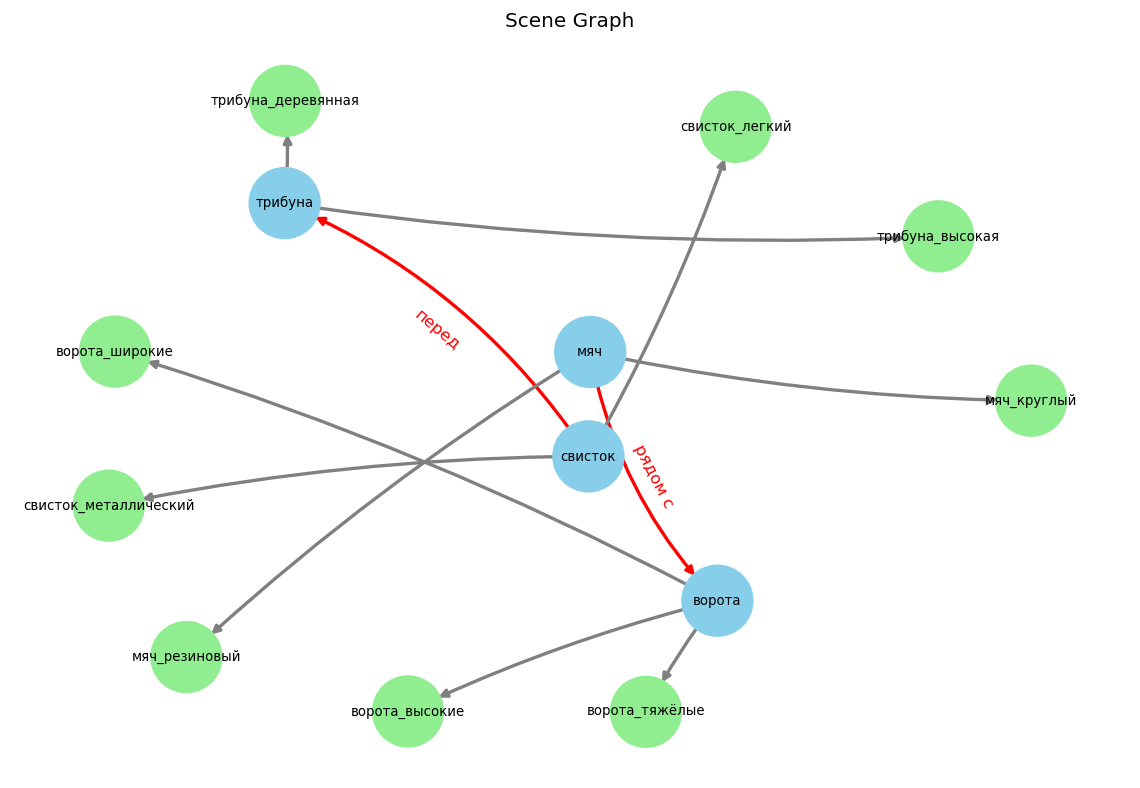


{"scene": {"location": "стадион", "objects": [{"мяч": ["круглый", "резиновый"]}, {"трибуна": ["высокая", "деревянная"]}, {"ворота": ["высокие", "широкие", "тяжёлые"]}, {"свисток": ["металлический", "легкий"]}], "relations": [["ворота", "перед", "трибуна"], ["мяч", "рядом с", "ворота"], ["свисток", "на", "трибуна"]]}, "description": "Тяжелые, широкие и высокие ворота стоят перед высокой деревянной трибуной.  \n\nРядом лежит круглый резиновый мяч.  \n\nНа трибуне лежит легкий металлический свисток."}



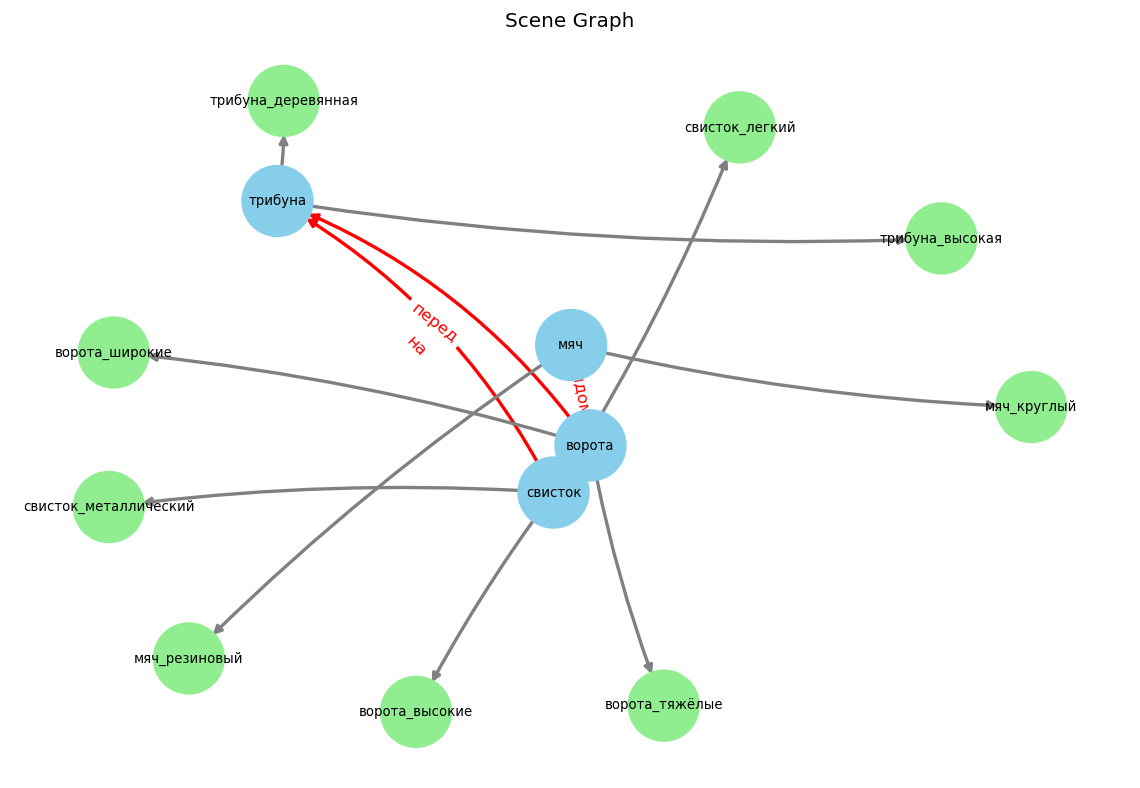


{"scene": {"location": "стадион", "objects": [{"мяч": ["круглый", "резиновый"]}, {"трибуна": ["высокая", "деревянная"]}, {"ворота": ["высокие", "широкие", "тяжёлые"]}, {"свисток": ["металлический", "легкий"]}], "relations": [["свисток", "рядом с", "мяч"], ["мяч", "катится к", "ворота"], ["трибуна", "за", "ворота"]]}, "description": "Легкий металлический свисток лежит рядом с резиновым круглым мячом.  \nМяч катится к высоким широким тяжелым воротам.  \nЗа воротами возвышается высокая деревянная трибуна."}



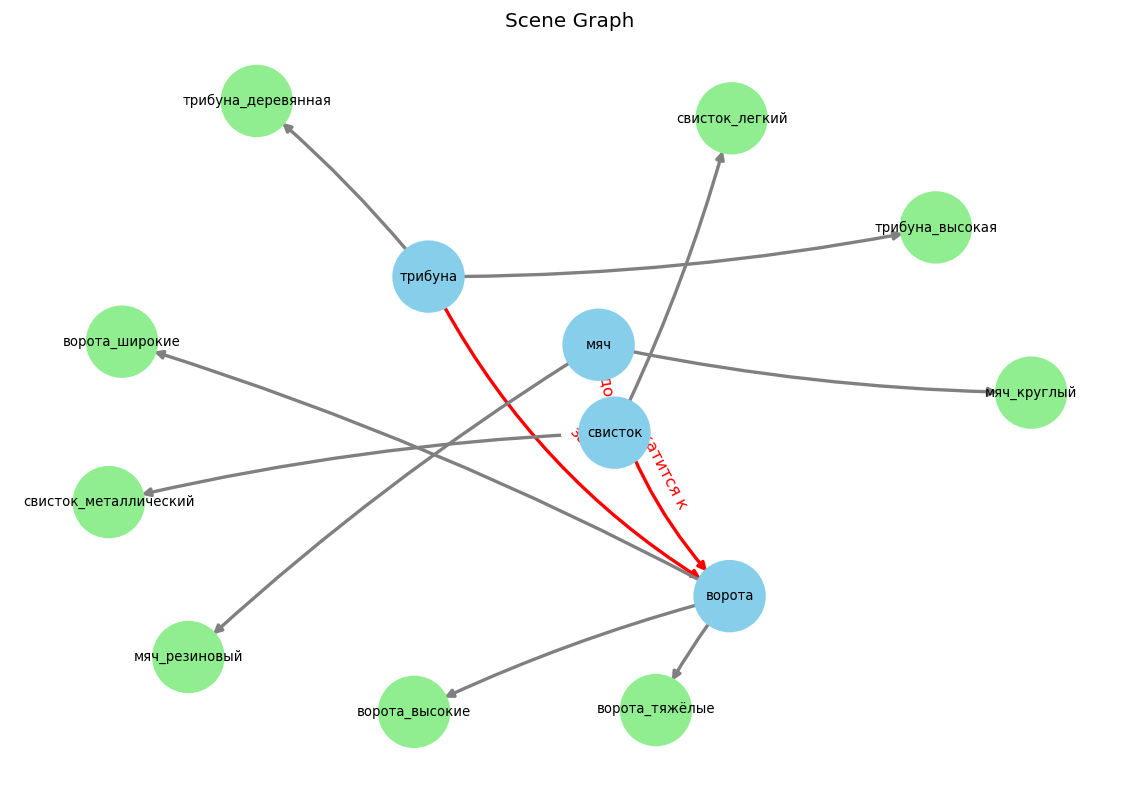


{"scene": {"location": "студия", "objects": [{"микрофон": ["чёрный"]}, {"наушники": ["чёрные", "лёгкие"]}, {"стул": ["деревянный", "высокий"]}], "relations": [["наушники", "на", "стул"], ["наушники", "рядом с", "микрофон"]]}, "description": "Черные легкие наушники лежат на высоком деревянном стуле рядом с черным микрофоном."}




{"scene": {"location": "студия", "objects": [{"микрофон": ["чёрный"]}, {"наушники": ["чёрные", "лёгкие"]}, {"стул": ["деревянный", "высокий"]}], "relations": [["микрофон", "перед", "стул"], ["наушники", "на", "стул"]]}, "description": "Черный микрофон стоит перед высоким деревянным стулом, на котором лежат легкие черные наушники."}



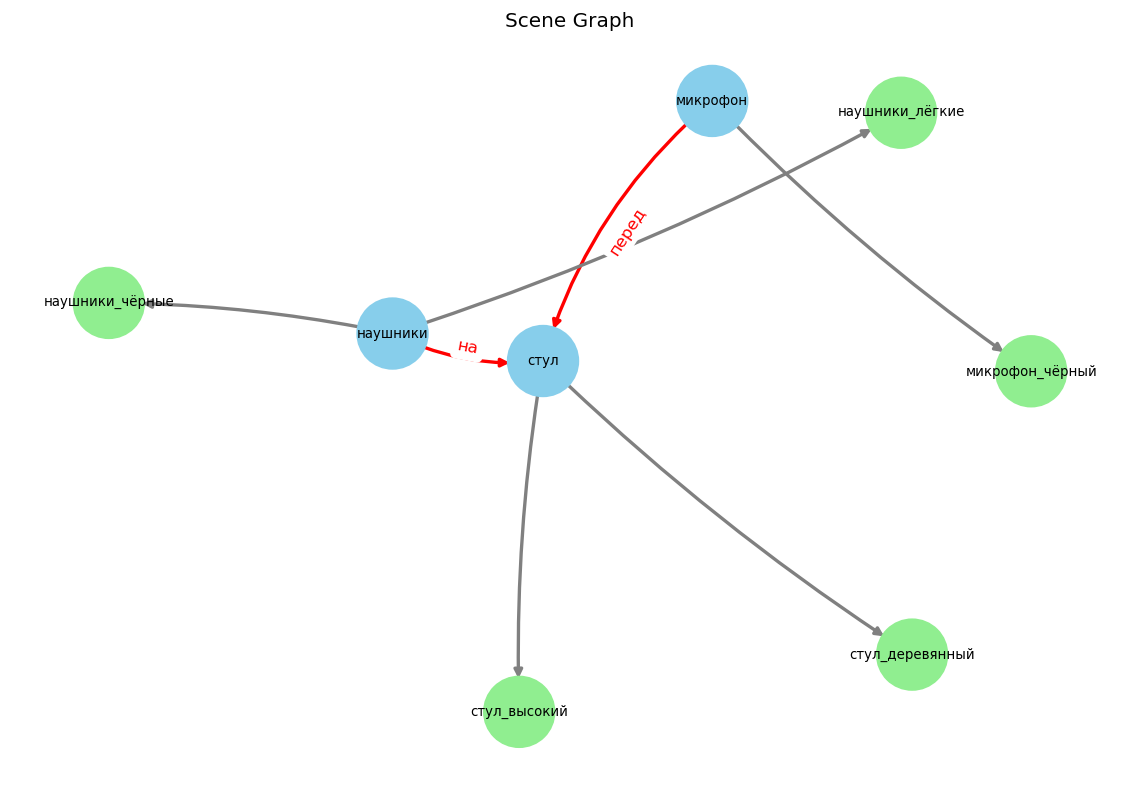


{"scene": {"location": "студия", "objects": [{"микрофон": ["чёрный"]}, {"наушники": ["чёрные", "лёгкие"]}, {"стул": ["деревянный", "высокий"]}], "relations": [["наушники", "рядом с", "микрофон"], ["микрофон", "перед", "стул"]]}, "description": "Черные легкие наушники лежат рядом с черным микрофоном, который стоит перед высоким деревянным стулом."}



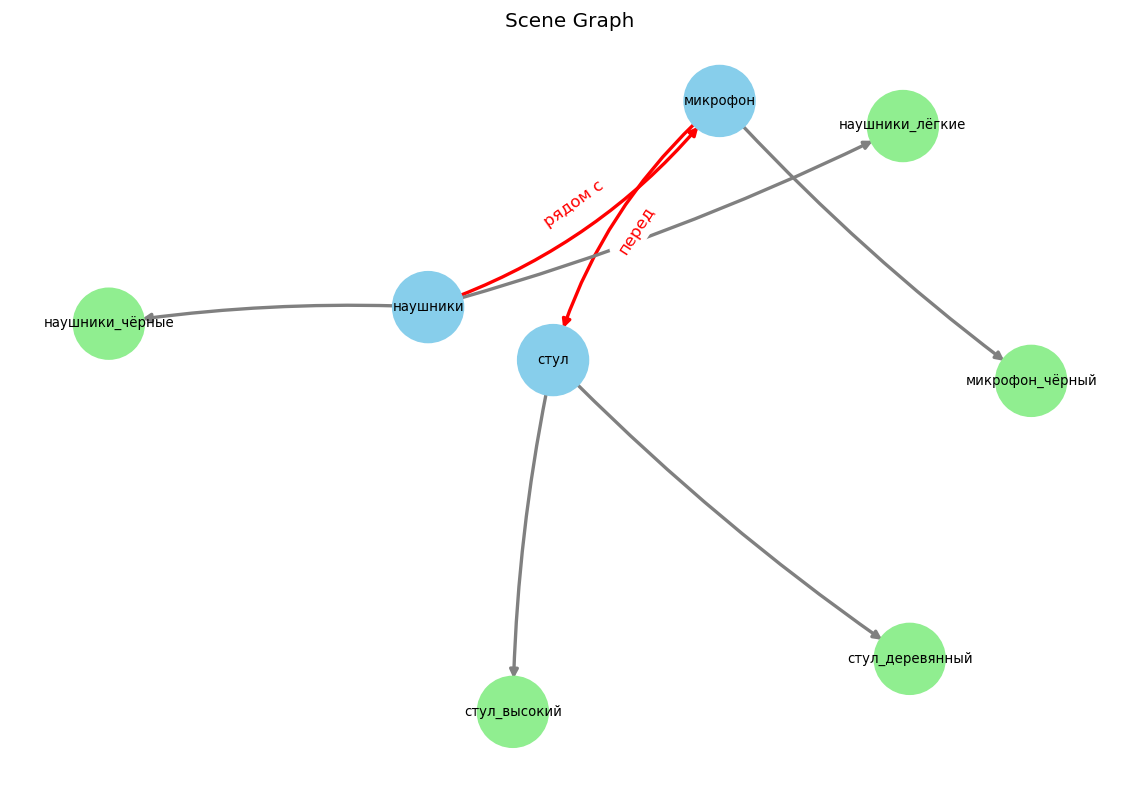


{"scene": {"location": "амбар", "objects": [{"мешок": ["большой", "тяжелый"]}, {"лопата": ["металлическая"]}, {"грабли": ["металлические", "тяжелые"]}, {"ведро": ["пластиковое"]}], "relations": [["ведро", "рядом с", "мешок"], ["лопата", "возле", "грабли"]]}, "description": "Пластиковое ведро стоит рядом с тяжелым большим мешком.  \n\nМеталлическая лопата лежит возле металлических тяжелых граблей."}



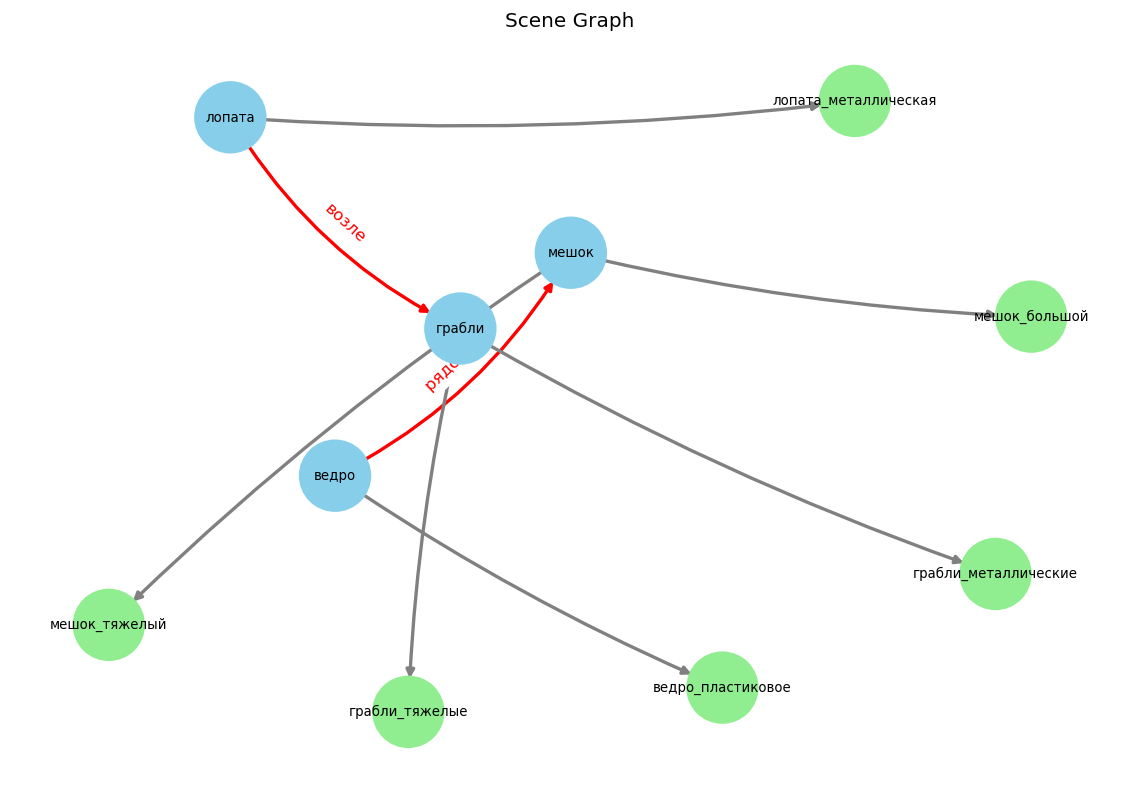


{"scene": {"location": "амбар", "objects": [{"мешок": ["большой", "тяжелый"]}, {"лопата": ["металлическая"]}, {"грабли": ["металлические", "тяжелые"]}, {"ведро": ["пластиковое"]}], "relations": [["грабли", "прислонены к", "лопата"], ["мешок", "рядом с", "ведро"]]}, "description": "Металлические тяжелые грабли прислонены к металлической лопате. Рядом лежит большой тяжелый мешок, а перед ним стоит пластиковое ведро."}



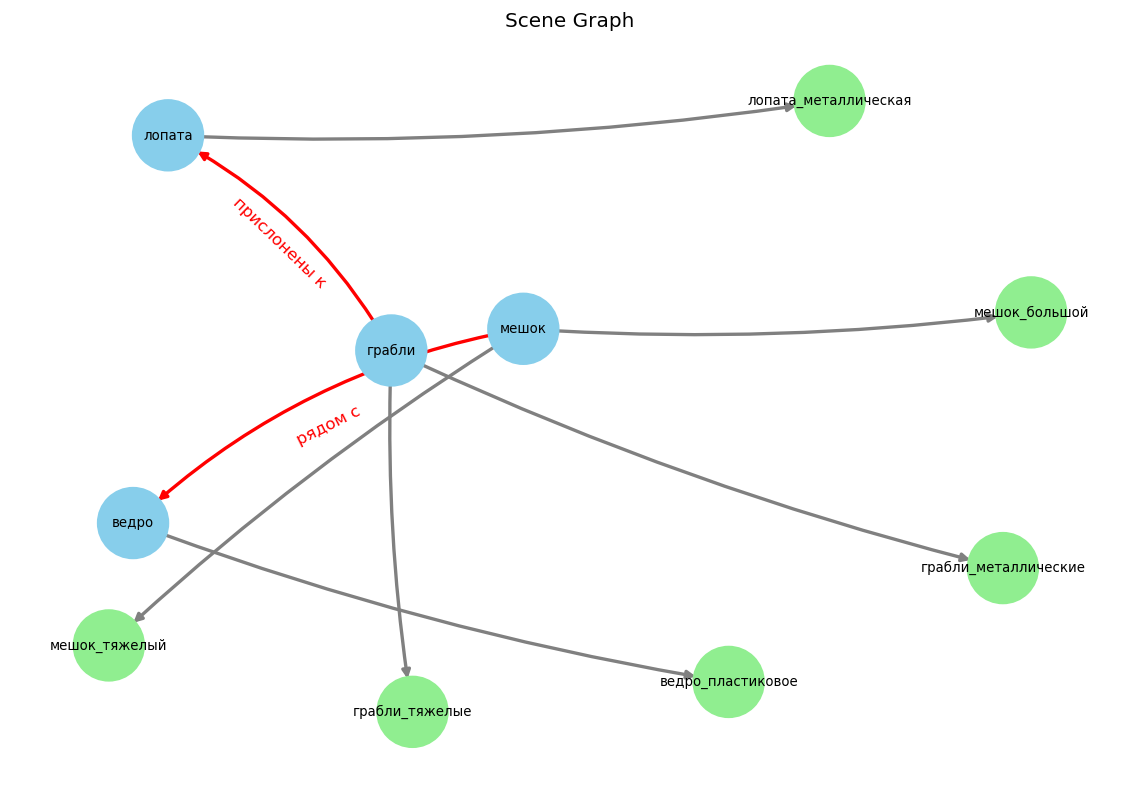


{"scene": {"location": "амбар", "objects": [{"мешок": ["большой", "тяжелый"]}, {"лопата": ["металлическая"]}, {"грабли": ["металлические", "тяжелые"]}, {"ведро": ["пластиковое"]}], "relations": [["ведро", "рядом с", "лопата"], ["лопата", "возле", "мешок"], ["мешок", "прислонен к", "грабли"], ["грабли", "лежат рядом с", "ведро"]]}, "description": "Пластиковое ведро стоит рядом с металлической лопатой.  \n\nМеталлическая лопата лежит возле тяжелого большого мешка.  \n\nТяжелый большой мешок прислонен к тяжелым металлическим граблям.  \n\nТяжелые металлические грабли лежат рядом с пластиковым ведром."}



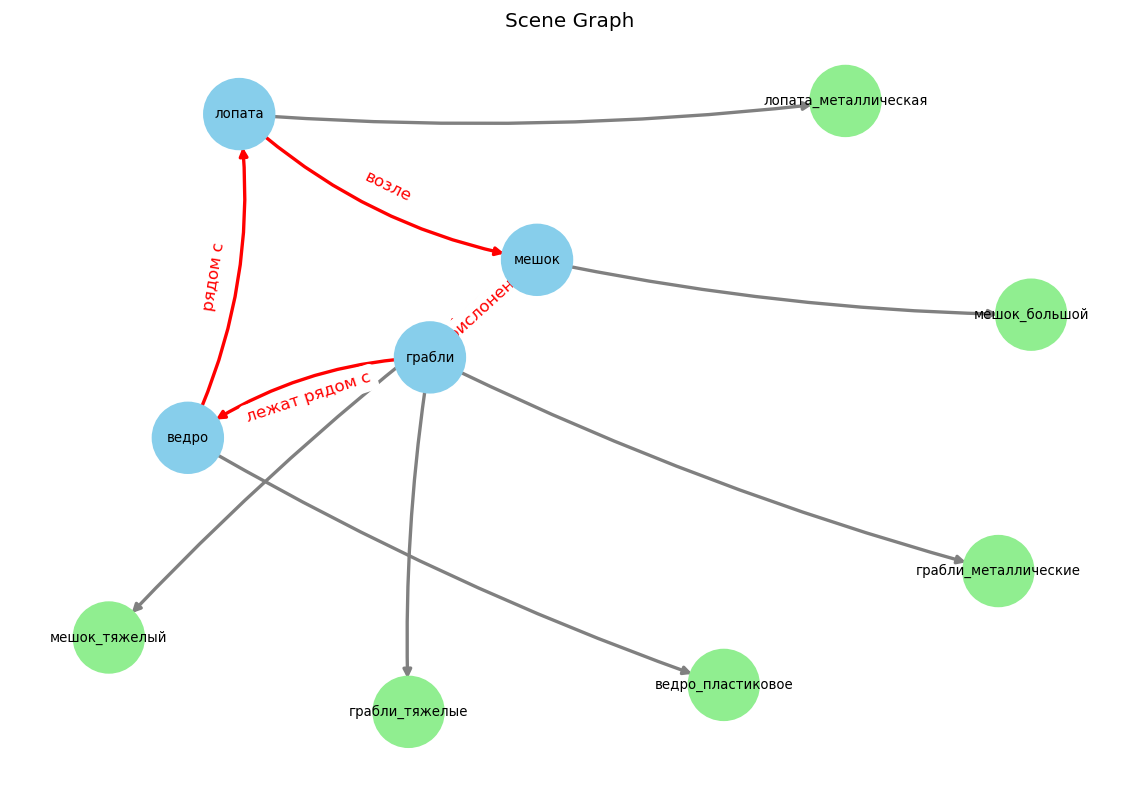


{"scene": {"location": "ресторан", "objects": [{"стол": ["деревянный"]}, {"стул": []}, {"меню": ["цветное"]}], "relations": [["стол", "рядом с", "стул"], ["меню", "на", "стул"]]}, "description": "Деревянный стол стоит рядом со стулом, на котором лежит цветное меню."}



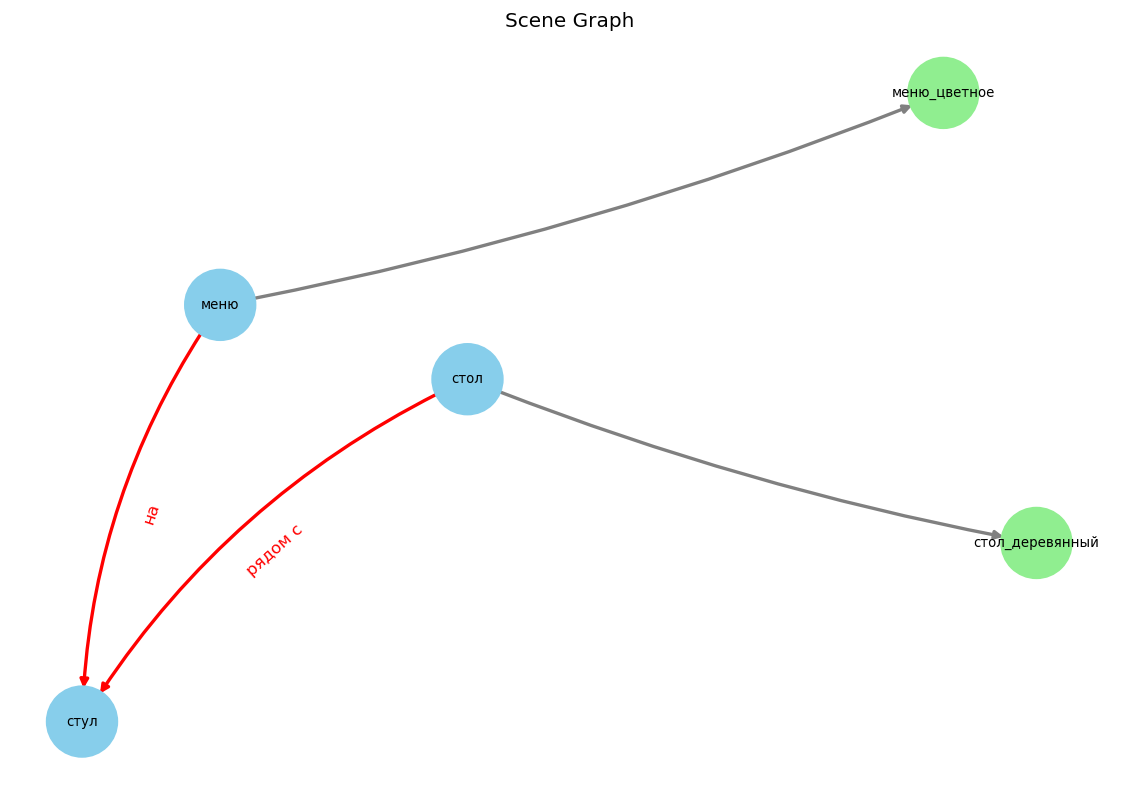


{"scene": {"location": "ресторан", "objects": [{"стол": ["деревянный"]}, {"стул": []}, {"меню": ["цветное"]}], "relations": [["стол", "рядом с", "стул"], ["меню", "на", "стол"]]}, "description": "Деревянный стол стоит рядом со стулом, на нем лежит цветное меню."}



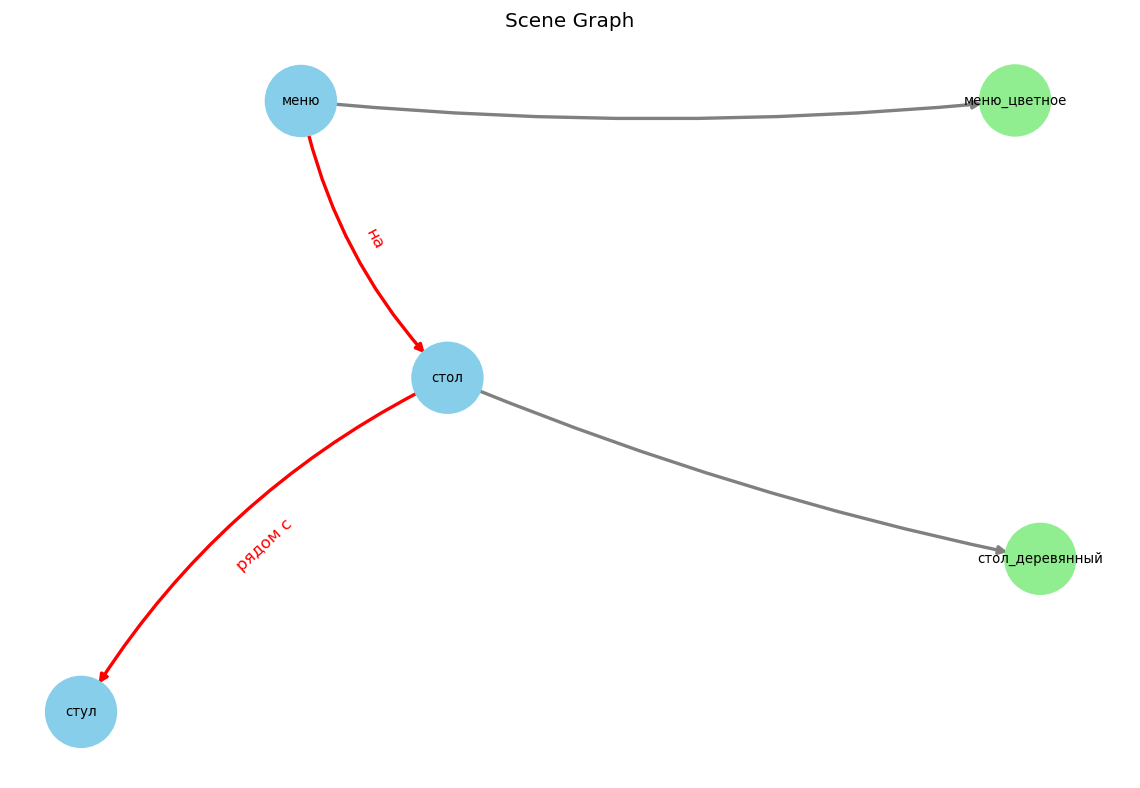


{"scene": {"location": "ресторан", "objects": [{"стол": ["деревянный"]}, {"стул": []}, {"меню": ["цветное"]}], "relations": [["меню", "на", "стол"], ["стул", "рядом с", "стол"]]}, "description": "Цветное меню лежит на деревянном столе, рядом стоит стул."}



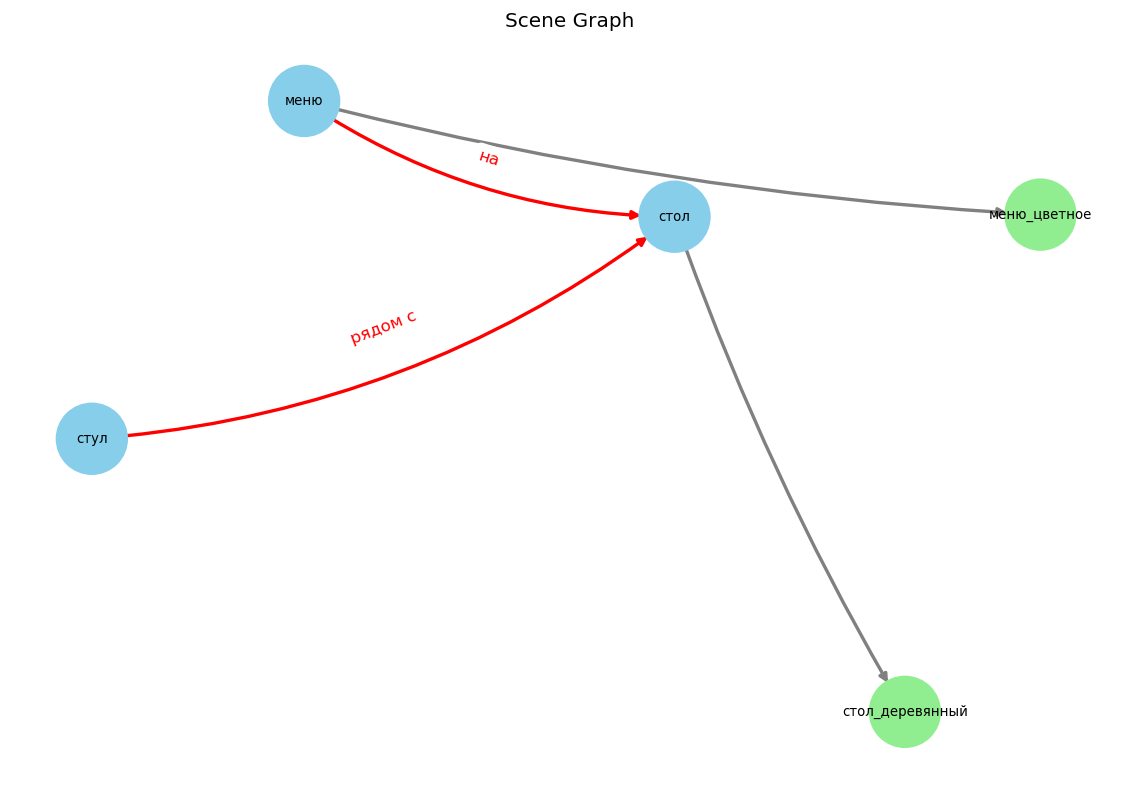

In [15]:
with open(f"dataset_syntetic_v5_spacial/dataset_spacial_batch_{BATCH_NUM}.jsonl", "r", encoding="utf-8") as f:
    for i, line in enumerate(f, 1):
        print(line)
        data = json.loads(line)
        G = scene_to_graph_sp(data.get("scene", {}))
        draw_scene_graph_sp(G)            
        print()